<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We"re going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you"ll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> Preparing the tools </font></h2>

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
import plotly.express as px
from datetime import datetime, date, timedelta

# Set the style
plt.style.use("ggplot")
# plt.style.available

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h3><font color=steelblue>Zicht op Data dataset </font></h3>

<h4><font color=mediumvioletred>Read CSV files </font></h4>

In [2]:
# read zichtop dataset csv file
df_zichtop = pd.read_csv("data/zichtop.csv", 
                    parse_dates=["date"])

# read air_pollution dataset csv file
df_air_pollution = pd.read_csv("data/air_pollution.csv",
                    parse_dates=["date"])

<h4><font color=mediumvioletred>Get a sample </font></h4>

In [3]:
# zichtop sample
df_zichtop.head(10)

PC4                date  pop_tot  m00_30  m30_60  H1_2  H2_4   H4_8  \
0  5611 2021-01-01 00:00:00      830   136.0    80.0  34.0  57.0   34.0   
1  5611 2021-01-01 01:00:00      837   138.0    11.0  23.0  92.0   23.0   
2  5611 2021-01-01 02:00:00      745    41.0     0.0   0.0  82.0   51.0   
3  5611 2021-01-01 03:00:00      876   115.0     0.0   0.0  52.0   21.0   
4  5611 2021-01-01 04:00:00      714    49.0     0.0   0.0  37.0   25.0   
5  5611 2021-01-01 05:00:00      702    28.0     0.0   0.0   0.0   28.0   
6  5611 2021-01-01 06:00:00      888    53.0     0.0   0.0  18.0   89.0   
7  5611 2021-01-01 07:00:00     1182   148.0     0.0   0.0   0.0   84.0   
8  5611 2021-01-01 08:00:00     1263   134.0    38.0   0.0  19.0  115.0   
9  5611 2021-01-01 09:00:00     1514   214.0    71.0   0.0  71.0  160.0   

   H8_16  H16plus  
0   34.0    455.0  
1   80.0    470.0  
2   71.0    500.0  
3  125.0    563.0  
4  111.0    492.0  
5  183.0    463.0  
6  160.0    568.0  
7  169.0    781.0  
8  268.0    689.0  
9  303.0    695.0

In [4]:
# air_pollution sample
df_air_pollution.sample(5)

date   PC4       pm10      pm2.5        no2         no  \
70767 2021-12-23 14:00:00  5625  37.974120  66.960960  21.804221   2.476815   
30264 2021-11-19 00:00:00  5633  13.063332   9.526624  32.256694  21.104114   
40966 2021-10-26 22:00:00  5651   9.015907   5.446528  18.289970  11.966310   
65043 2021-12-16 02:00:00  5615  32.200630  52.906510  38.386225   3.414680   
8779  2021-10-25 19:00:00  5616  13.671910   8.699615  30.282495  19.812483   

            so2  
70767  4.305121  
30264  6.689611  
40966  2.067180  
65043  3.807812  
8779   5.302131

<h4><font color=mediumvioletred>Get number of rows and columns </font></h4>

In [5]:
df_zichtop.shape

(255024, 10)

<h4><font color=mediumvioletred>Get types of columns </font></h4>

In [6]:
df_zichtop.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
dtype: object

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..) </font></h4>

In [7]:
df_zichtop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   PC4      255024 non-null  int64         
 1   date     255024 non-null  datetime64[ns]
 2   pop_tot  255024 non-null  int64         
 3   m00_30   254276 non-null  float64       
 4   m30_60   254276 non-null  float64       
 5   H1_2     254276 non-null  float64       
 6   H2_4     254276 non-null  float64       
 7   H4_8     254276 non-null  float64       
 8   H8_16    254276 non-null  float64       
 9   H16plus  254276 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 19.5 MB


<h4><font color=mediumvioletred>Get some info about numerical columns (count, mean, min...) </font></h4>

In [8]:
df_zichtop.describe()

PC4        pop_tot         m00_30         m30_60  \
count  255024.000000  255024.000000  254276.000000  254276.000000   
mean     5633.818182    1984.896131     334.580322      41.012966   
std        15.168687    1285.972747     376.307733      61.055502   
min      5611.000000       5.000000       0.000000       0.000000   
25%      5622.000000    1060.000000      56.000000       0.000000   
50%      5631.000000    1703.000000     222.000000      15.000000   
75%      5646.000000    2615.000000     481.000000      60.000000   
max      5658.000000   11617.000000    4885.000000    2090.000000   

               H1_2           H2_4           H4_8          H8_16  \
count  254276.00000  254276.000000  254276.000000  254276.000000   
mean       73.50676     126.323121     237.291384     349.584455   
std       104.01577     186.176472     331.758108     380.206726   
min         0.00000       0.000000       0.000000       0.000000   
25%         0.00000       9.000000      38.000000      98.000000   
50%        32.00000      62.000000     119.000000     236.000000   
75%       107.00000     173.000000     292.000000     454.000000   
max      1564.00000    5326.000000    3515.000000    3368.000000   

             H16plus  
count  254276.000000  
mean      827.626296  
std       538.795020  
min        -3.000000  
25%       471.000000  
50%       781.000000  
75%      1093.000000  
max      3409.000000

<h4><font color=mediumvioletred>Get start and end dates </font></h4>

In [9]:
df_zichtop["date"].min(), df_zichtop["date"].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-11-18 23:00:00'))

<h4><font color=mediumvioletred>Merge zichtop and air_pollution datasets </font></h4>

In [10]:
df_zichtop_air_pollution = pd.merge(df_zichtop, df_air_pollution[["PC4","date", "pm2.5"]], on=["PC4", "date"])
df_zichtop_air_pollution.sample(5)

PC4                date  pop_tot  m00_30  m30_60   H1_2   H2_4   H4_8  \
10404  5621 2021-11-12 12:00:00     2378   889.0    67.0  133.0  422.0  333.0   
25669  5641 2021-10-19 13:00:00     2399   471.0    29.0  103.0  118.0  648.0   
10243  5621 2021-11-05 19:00:00     1650   326.0     0.0  134.0  211.0  134.0   
41781  5657 2021-10-30 21:00:00     1818   606.0    50.0   84.0  219.0  370.0   
31207  5645 2021-10-30 07:00:00     1291   191.0    15.0    0.0  117.0   73.0   

       H8_16  H16plus      pm2.5  
10404  222.0    312.0  29.108496  
25669  383.0    647.0   7.819602  
10243  211.0    634.0   7.454261  
41781  303.0    186.0   3.537094  
31207  191.0    704.0   3.620806

In [11]:
df_zichtop_air_pollution.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
pm2.5             float64
dtype: object

<h4><font color=mediumvioletred>Reorder columns in zichtop air pollution dataset </font></h4>

In [12]:
zichtop_air_pollution_features = [
    "PC4",
    "date",
    "pop_tot",
    "pm2.5",
    "m00_30",
    "m30_60",
    "H1_2",
    "H2_4",
    "H4_8",
    "H8_16",
    "H16plus"
]

df_zichtop_air_pollution = df_zichtop_air_pollution.reindex(zichtop_air_pollution_features, axis=1)

df_zichtop_air_pollution.sample(5)

PC4                date  pop_tot      pm2.5  m00_30  m30_60   H1_2  \
2688   5613 2021-09-27 00:00:00      676   7.662141     0.0     0.0    0.0   
17216  5627 2021-09-27 08:00:00     4260  10.065165   605.0    61.0   85.0   
24565  5633 2021-10-28 13:00:00     2408   3.564495   860.0     0.0  143.0   
28899  5643 2021-11-13 03:00:00      988   3.614129    16.0     0.0    0.0   
26314  5641 2021-11-15 10:00:00     2205  24.581802   234.0    16.0   81.0   

        H2_4    H4_8  H8_16  H16plus  
2688    31.0     0.0    0.0    645.0  
17216  206.0  1125.0  799.0   1379.0  
24565  229.0   803.0  287.0     86.0  
28899    0.0     8.0   88.0    876.0  
26314  428.0   679.0  250.0    517.0

<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [13]:
df_zichtop_air_pollution.rename(columns={"date": "date_time"}, inplace=True)

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [14]:
df_zichtop_air_pollution["date"] = df_zichtop_air_pollution["date_time"].dt.date.astype(str)
df_zichtop_air_pollution["time"] = df_zichtop_air_pollution["date_time"].dt.time.astype(str)

In [15]:
df_zichtop_air_pollution.sample(5)

PC4           date_time  pop_tot      pm2.5  m00_30  m30_60   H1_2  \
19928  5629 2021-09-30 08:00:00     3083   6.050046   565.0    40.0  162.0   
6011   5615 2021-10-25 11:00:00     2426   4.971026   757.0   134.0   89.0   
35883  5653 2021-10-05 03:00:00     1436   1.500994    64.0     0.0    0.0   
1628   5612 2021-10-07 20:00:00     3735  30.109533   799.0    86.0   65.0   
3012   5613 2021-10-10 12:00:00     3505  32.414558   910.0   213.0  252.0   

        H2_4   H4_8  H8_16  H16plus        date      time  
19928  310.0  337.0  350.0   1319.0  2021-09-30  08:00:00  
6011   223.0  156.0  423.0    644.0  2021-10-25  11:00:00  
35883    0.0   80.0   96.0   1196.0  2021-10-05  03:00:00  
1628   173.0  216.0  820.0   1576.0  2021-10-07  20:00:00  
3012   504.0  329.0  620.0    677.0  2021-10-10  12:00:00

<h4><font color=mediumvioletred>Get start and end dates </font></h4>

In [16]:
df_zichtop_air_pollution["date"].min(), df_zichtop_air_pollution["date"].max()

('2021-09-25', '2021-11-18')

<h4><font color=mediumvioletred>Correlation between numerical columns </font></h4>

In [17]:
df_zichtop_air_pollution.corr()

C:\Users\rawan\AppData\Local\Temp\ipykernel_36828\331212103.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_zichtop_air_pollution.corr()


PC4   pop_tot     pm2.5    m00_30    m30_60      H1_2      H2_4  \
PC4      1.000000 -0.085402 -0.040311  0.050393 -0.068758 -0.123084 -0.137336   
pop_tot -0.085402  1.000000 -0.016892  0.750560  0.708953  0.749542  0.761389   
pm2.5   -0.040311 -0.016892  1.000000 -0.094783 -0.025442 -0.015412 -0.017758   
m00_30   0.050393  0.750560 -0.094783  1.000000  0.640048  0.621415  0.589695   
m30_60  -0.068758  0.708953 -0.025442  0.640048  1.000000  0.749745  0.676787   
H1_2    -0.123084  0.749542 -0.015412  0.621415  0.749745  1.000000  0.805084   
H2_4    -0.137336  0.761389 -0.017758  0.589695  0.676787  0.805084  1.000000   
H4_8    -0.118519  0.815847  0.005160  0.550787  0.609642  0.656044  0.724193   
H8_16   -0.033977  0.842051  0.018352  0.616381  0.572131  0.571656  0.540605   
H16plus -0.052989  0.199654  0.025760 -0.189647 -0.137459 -0.132161 -0.144004   

             H4_8     H8_16   H16plus  
PC4     -0.118519 -0.033977 -0.052989  
pop_tot  0.815847  0.842051  0.199654  
pm2.5    0.005160  0.018352  0.025760  
m00_30   0.550787  0.616381 -0.189647  
m30_60   0.609642  0.572131 -0.137459  
H1_2     0.656044  0.571656 -0.132161  
H2_4     0.724193  0.540605 -0.144004  
H4_8     1.000000  0.692728 -0.154635  
H8_16    0.692728  1.000000 -0.002266  
H16plus -0.154635 -0.002266  1.000000

<h4><font color=mediumvioletred>Visualize correlation between numerical columns </font></h4>

C:\Users\rawan\AppData\Local\Temp\ipykernel_36828\893774120.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_zichtop_air_pollution.corr()


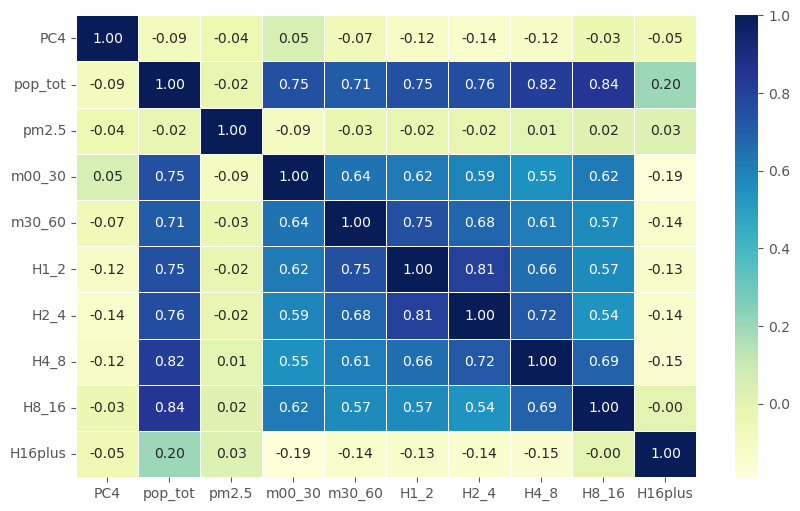

In [18]:
corr_matrix = df_zichtop_air_pollution.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

The correlation matrix demonstrates that PC4, m00_30 and m30_60 have the highest coreelation with our target column pm2.5.

<h4><font color=mediumvioletred>Get number of people in zip code 5611 on 2021-09-25 </font></h4>

In [19]:
people_air_quality_area = df_zichtop_air_pollution[(df_zichtop_air_pollution["PC4"] == 5611) & (df_zichtop_air_pollution["date"] == "2021-09-25")]
people_air_quality_area.sample(5)

PC4           date_time  pop_tot      pm2.5  m00_30  m30_60   H1_2  \
6   5611 2021-09-25 06:00:00     2771  13.031172   513.0    16.0   16.0   
11  5611 2021-09-25 11:00:00     8275   4.867302  1029.0   296.0  748.0   
14  5611 2021-09-25 14:00:00     8035   4.974612   995.0   357.0  699.0   
20  5611 2021-09-25 20:00:00     6183  15.954722   652.0    65.0  117.0   
19  5611 2021-09-25 19:00:00     6924  15.411076   718.0   256.0  295.0   

      H2_4    H4_8   H8_16  H16plus        date      time  
6     64.0   224.0   529.0   1409.0  2021-09-25  06:00:00  
11  1886.0  1652.0  1590.0   1074.0  2021-09-25  11:00:00  
14  1445.0  2020.0  1492.0   1027.0  2021-09-25  14:00:00  
20  1291.0  1631.0  1448.0    979.0  2021-09-25  20:00:00  
19  1410.0  1975.0  1282.0    988.0  2021-09-25  19:00:00

<h4><font color=mediumvioletred>Visualize number of people in zip code 5611 on 2021-09-25 </font></h4>

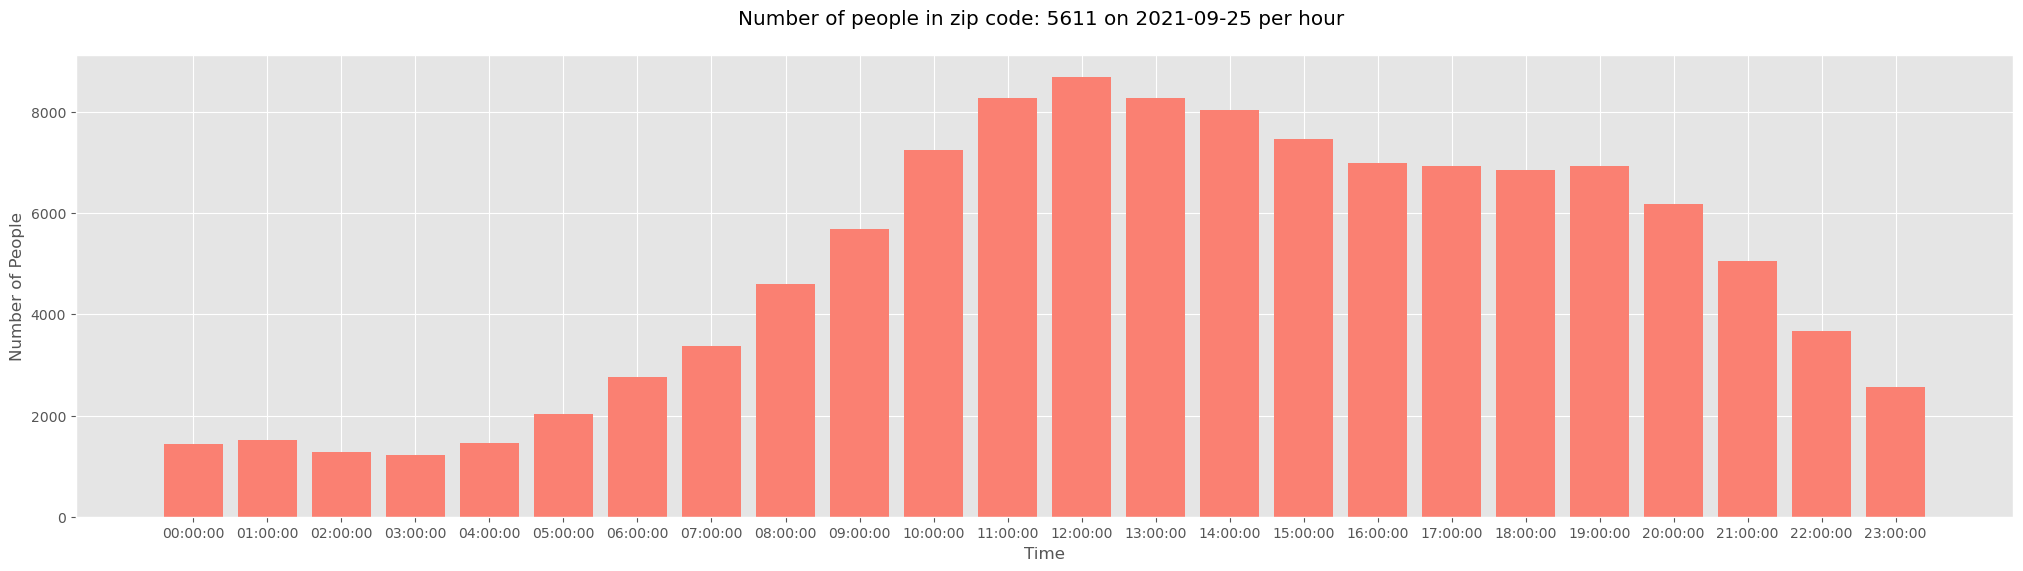

In [20]:
fig, ax = plt.subplots(figsize=(25, 6))
# Plot the data
barplot = ax.bar(list(people_air_quality_area["time"]),
                list(people_air_quality_area["pop_tot"]),
                color="salmon");

# Customize the plot
ax.set(title="Number of people in zip code: 5611 on 2021-09-25 per hour \n",
      xlabel="Time",
      ylabel="Number of People");

The bar chart shows that on September 25, 2021, the population of zip code 5611 starts increasing at 5 AM, peaks at 12 PM, and then begins to decline around 7 PM.

<h4><font color=mediumvioletred> Get maximum number of people per zip code </font></h4>

In [21]:
max_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg("max").reset_index()
max_people.head()

PC4  pop_tot
0  5611    11617
1  5612    10250
2  5613     5925
3  5614     3504
4  5615     4408

<h4><font color=mediumvioletred> Visualize maximum number of people per zip code </font></h4>

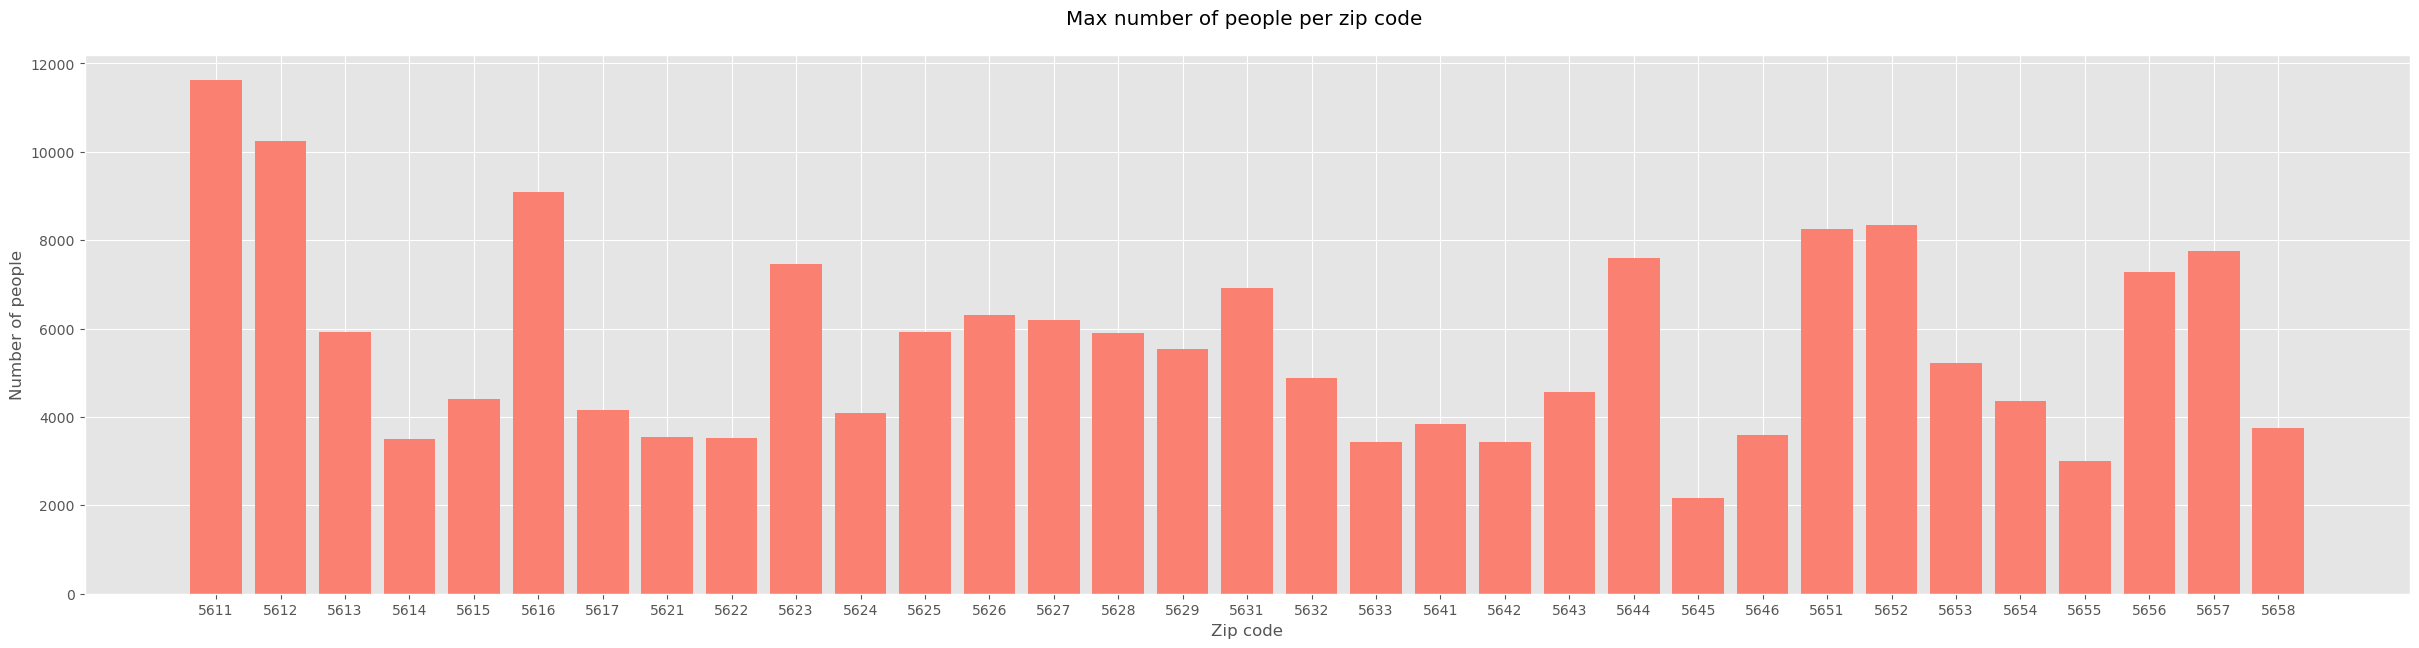

In [22]:
fig, ax = plt.subplots(figsize=(30, 7))
# Plot the data
barplot = ax.bar(max_people["PC4"].astype(str),
                max_people["pop_tot"],
                color="salmon");

# Customize the plot
ax.set(title="Max number of people per zip code \n",
      xlabel="Zip code",
      ylabel="Number of people");

According to the graph, zip codes 5611, 5612 and 5616 have the highest number of people. These areas are at the city center of Eindhoven, so that is to be expected.

<h4><font color=mediumvioletred> Get maximum, average and minimum number of people per zip code </font></h4>

In [23]:
max_mean_min_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_people.head()

PC4    max  min         mean
0  5611  11617  708  4676.526515
1  5612  10250  737  4052.258333
2  5613   5925  537  2504.754545
3  5614   3504  217  1509.311364
4  5615   4408  394  1933.862121

<h4><font color=mediumvioletred> Visualize maximum, average and minimum number of people per zip code </font></h4>

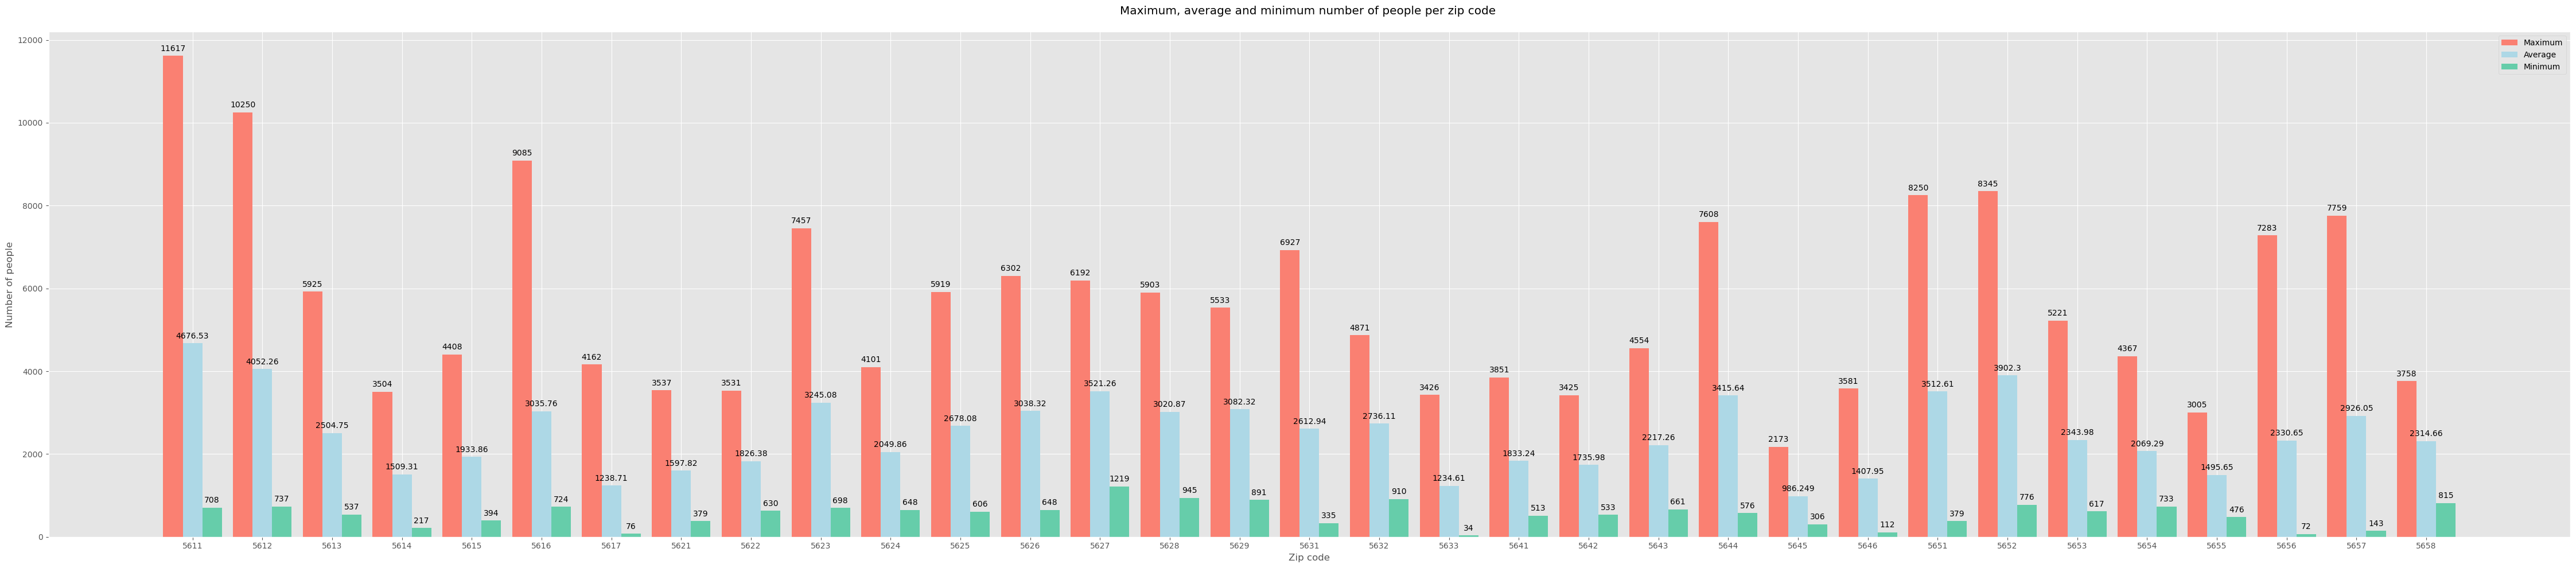

In [24]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_people["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, max_mean_min_people["max"], width, label="Maximum", color="salmon")
rects2 = ax.bar(x, max_mean_min_people["mean"], width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, max_mean_min_people["min"], width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Number of people")
ax.set_xlabel("Zip code")
ax.set_title("Maximum, average and minimum number of people per zip code \n")
ax.set_xticks(x, max_mean_min_people["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

plt.show()

The graph shows that zip codes 5611, 5612 and 5616 have the highest number of people, while zip codes 5633, 5656, 5617 have the lowest number of people.

<h4><font color=mediumvioletred> Get number of people vs. air quality </font></h4>

In [25]:
# get data for zip code 5611 on 2021-09-25
people_air_quality_area.head(5)

PC4           date_time  pop_tot     pm2.5  m00_30  m30_60  H1_2  H2_4  \
0  5611 2021-09-25 00:00:00     1438  4.531522   155.0     0.0   0.0   0.0   
1  5611 2021-09-25 01:00:00     1516  3.434374   130.0     0.0   0.0   0.0   
2  5611 2021-09-25 02:00:00     1283  4.274056    44.0     0.0   0.0   0.0   
3  5611 2021-09-25 03:00:00     1223  5.396931    14.0     0.0   0.0  14.0   
4  5611 2021-09-25 04:00:00     1464  6.389200    56.0     0.0  14.0  28.0   

   H4_8  H8_16  H16plus        date      time  
0   0.0   77.0   1206.0  2021-09-25  00:00:00  
1  29.0   72.0   1285.0  2021-09-25  01:00:00  
2  15.0   73.0   1151.0  2021-09-25  02:00:00  
3  14.0   86.0   1095.0  2021-09-25  03:00:00  
4  28.0  155.0   1183.0  2021-09-25  04:00:00

<h4><font color=mediumvioletred> Visualize number of people vs. air quality </font></h4>

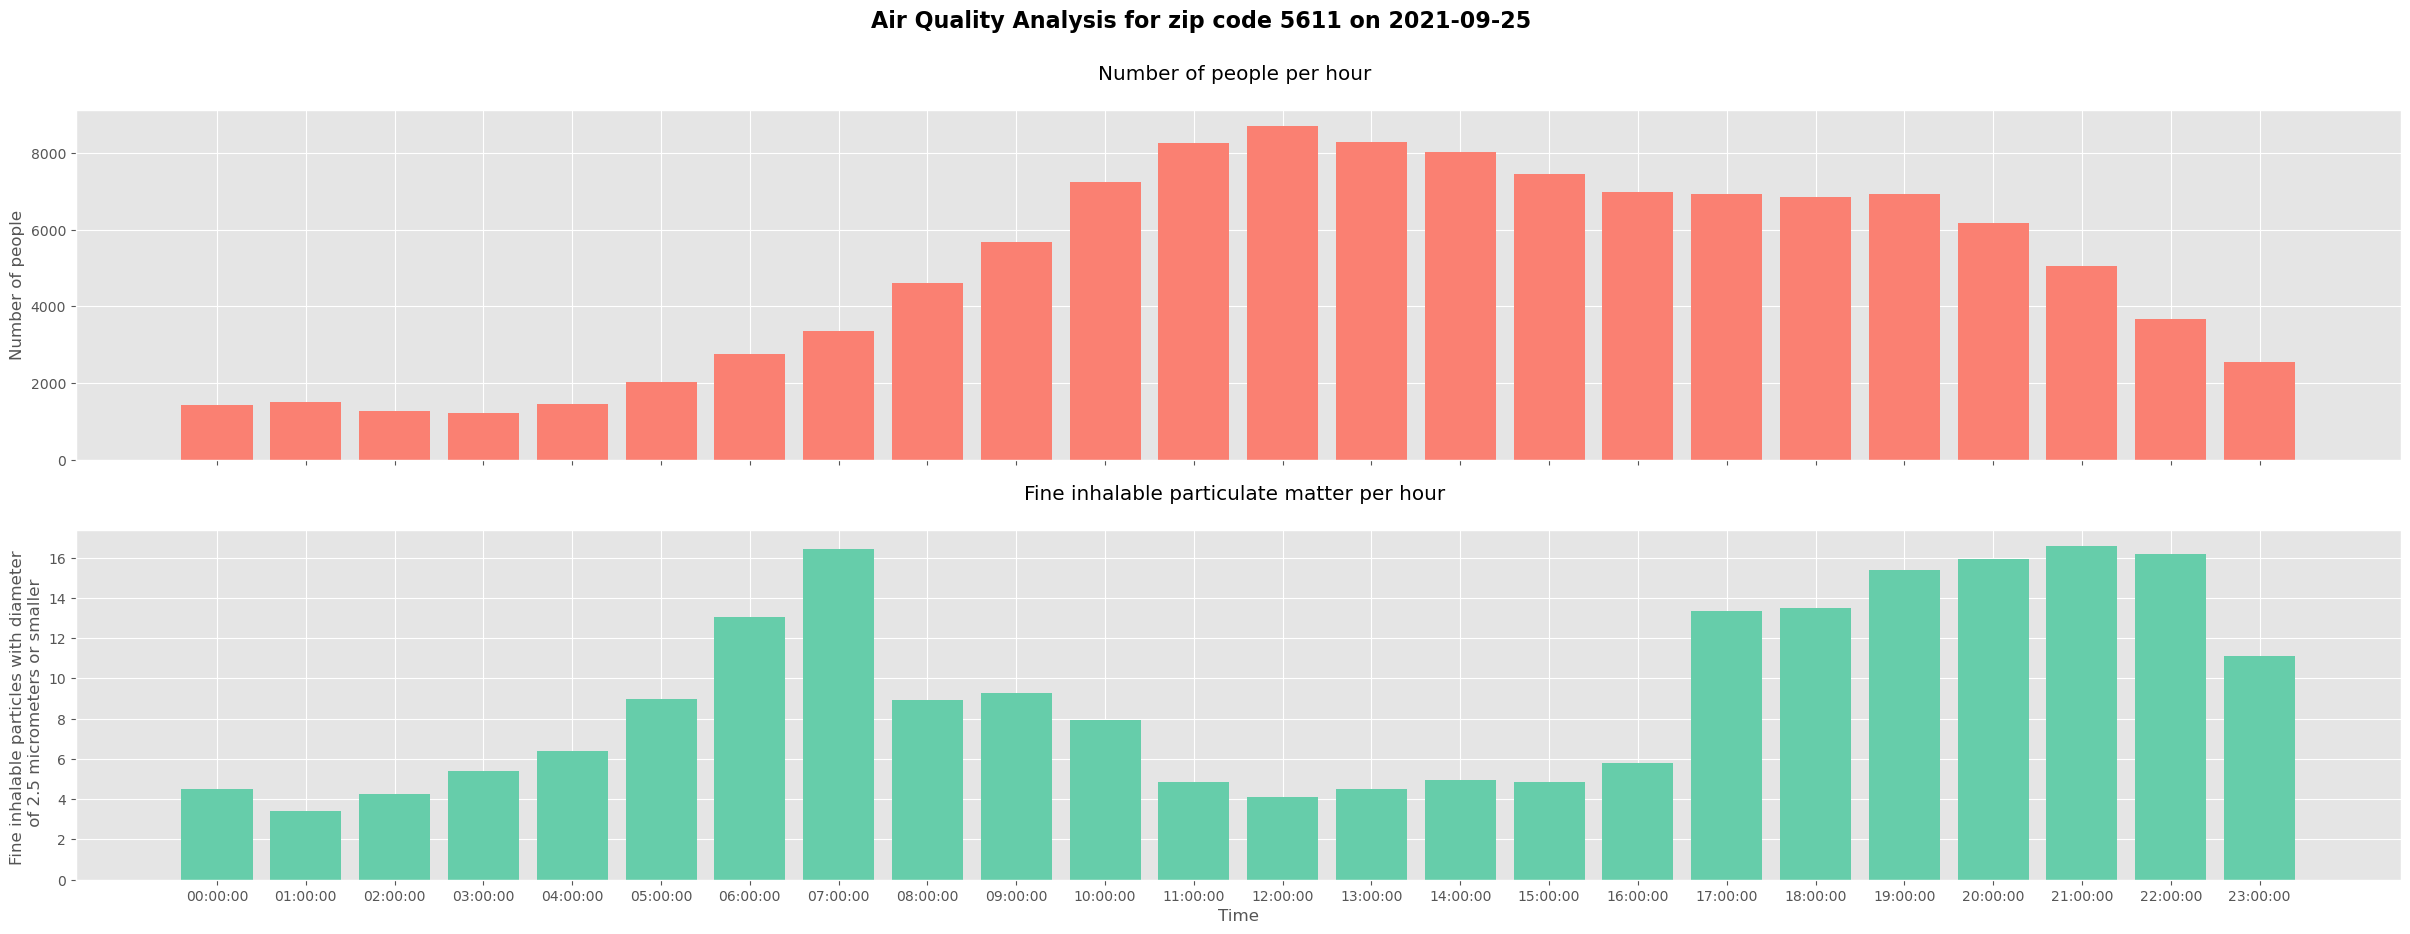

In [26]:
# Subplot of number of people, pollution, time
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 10),
                                sharex=True)

# Add data to ax0
ax0.bar(people_air_quality_area["time"], people_air_quality_area["pop_tot"], color="salmon");
# Add data to ax1
ax1.bar(people_air_quality_area["time"], people_air_quality_area["pm2.5"], color="mediumaquamarine");

# Customize ax0
ax0.set(title="Number of people per hour \n",
      ylabel="Number of people");

# Customize ax1
ax1.set(title="Fine inhalable particulate matter per hour \n",
        xlabel="Time",
        ylabel="Fine inhalable particles with diameter \n of 2.5 micrometers or smaller");

# Add a title to the figure
fig.suptitle("Air Quality Analysis for zip code 5611 on 2021-09-25", fontsize=16, fontweight="bold");

The bar chart illustrates that the pm2.5 in zip code 5611 on September 25, 2021 increases during the rush hours because of traffic, and decreases and stabilizes during the off-peak hours.

<h4><font color=mediumvioletred> Get maximum, average and minimum fine inhalable particulate matter per zip code </font></h4>

In [27]:
# Get daily average of pm2.5 per zip code
average_pm_per_day = df_zichtop_air_pollution.groupby(["PC4", "date"])["pm2.5"].agg({"mean"}).reset_index()

# Get maximum, average and minimum of pm2.5 per zip code
max_mean_min_pm = average_pm_per_day.groupby(["PC4"])["mean"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_pm.head()

PC4        max       min       mean
0  5611  36.353814  2.800860  11.384660
1  5612  36.713622  2.803116  11.319719
2  5613  33.850463  2.651556  10.836317
3  5614  33.032114  2.573862  10.658091
4  5615  35.662240  2.660535  11.044525

<h4><font color=mediumvioletred> Visualize maximum, average and minimum fine inhalable particulate matter per zip code </font></h4>

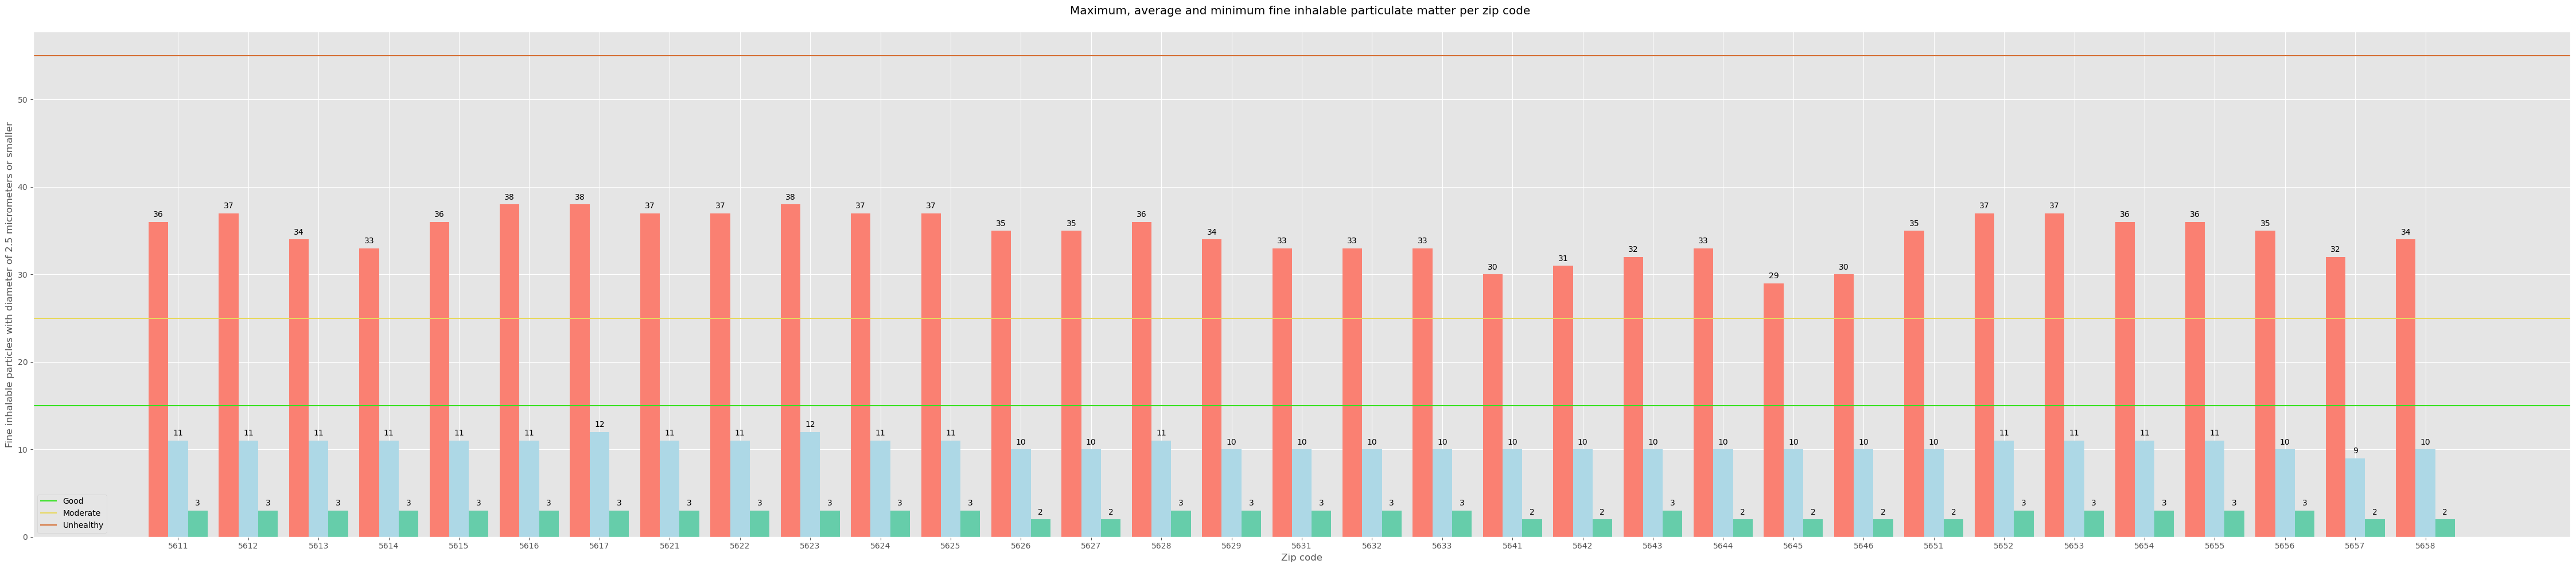

In [28]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_pm["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, round(max_mean_min_pm["max"]), width, label="Maximum", color="salmon")
rects2 = ax.bar(x, round(max_mean_min_pm["mean"]), width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, round(max_mean_min_pm["min"]), width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Fine inhalable particles with diameter of 2.5 micrometers or smaller")
ax.set_xlabel("Zip code")
ax.set_title("Maximum, average and minimum fine inhalable particulate matter per zip code \n")
ax.set_xticks(x, max_mean_min_pm["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

# adding air quality limits
good_limit = [15]
moderate_limit = [25]
unhealthy_limit = [55]

plt.axhline(y = good_limit, color = '#36e221', linestyle = '-')
plt.axhline(y = moderate_limit, color = '#e7d85d', linestyle = '-')
plt.axhline(y = unhealthy_limit, color = '#d56f33', linestyle = '-')
plt.legend(['Good', 'Moderate', 'Unhealthy'])

plt.show()

The graph indicates, that for each zip code the average and minimum pm2.5 levels are good while the maximum pm2.5 levels are unhealthy.

![title](images/pm2.5_chart.jpg)

<h4><font color=mediumvioletred>Calculate number of people per hour </font></h4>

In [29]:
# Get specific columns
people_per_hour = df_zichtop_air_pollution.iloc[:, [0, 3, 4, 5, 11, 12]].copy()
# Calculate number of people per hour
people_per_hour["people_number"] = people_per_hour["m00_30"] + people_per_hour["m30_60"]

people_per_hour.head(5)

PC4     pm2.5  m00_30  m30_60        date      time  people_number
0  5611  4.531522   155.0     0.0  2021-09-25  00:00:00          155.0
1  5611  3.434374   130.0     0.0  2021-09-25  01:00:00          130.0
2  5611  4.274056    44.0     0.0  2021-09-25  02:00:00           44.0
3  5611  5.396931    14.0     0.0  2021-09-25  03:00:00           14.0
4  5611  6.389200    56.0     0.0  2021-09-25  04:00:00           56.0

<h4><font color=mediumvioletred>Get number of people and average fine particulate matter (pm2.5) per day and area</font></h4>

In [30]:
# Calculate people number (sum) and pm2.5 (average) per day
people_pollution_per_day_area = people_per_hour.groupby(["PC4", "date"]).agg({"people_number": "sum", "pm2.5": "mean"}).reset_index()
# Round to 2 decimal places
people_pollution_per_day_area = people_pollution_per_day_area.round(decimals=2)

people_pollution_per_day_area.head(5)

PC4        date  people_number  pm2.5
0  5611  2021-09-25        16501.0   9.16
1  5611  2021-09-26        13175.0   8.11
2  5611  2021-09-27        24414.0   6.65
3  5611  2021-09-28        20980.0   5.89
4  5611  2021-09-29        21242.0   3.48

<h4><font color=mediumvioletred> Visualize the distribution of population </font></h4>

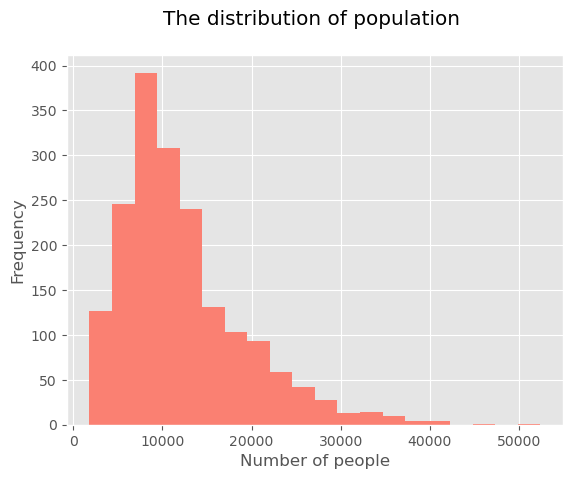

In [31]:
ax = people_pollution_per_day_area["people_number"].plot.hist(bins=20, 
                                                         title="The distribution of population \n", 
                                                         color="salmon");

ax.set_xlabel("Number of people");

After visualizing the distribution of the population, we can see that there are a few outliers, starting around 40000.

<h4><font color=mediumvioletred> Visualize the distribution of the fine particulate matter (pm2.5) </font></h4>

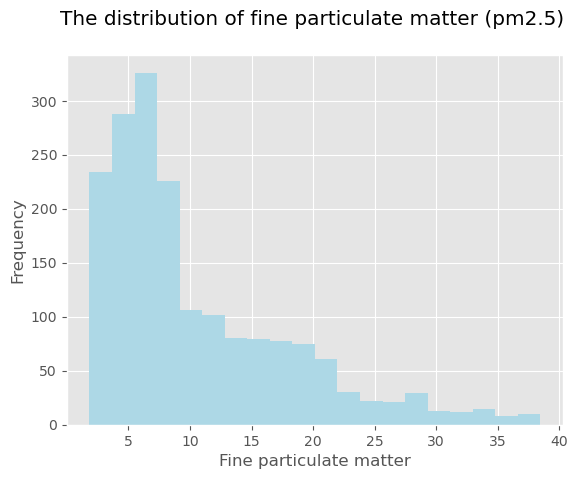

In [32]:
ax = people_pollution_per_day_area["pm2.5"].plot.hist(bins=20,
                                                title="The distribution of fine particulate matter (pm2.5) \n", 
                                                color="lightblue");

ax.set_xlabel("Fine particulate matter");

We can observe that there are a few outliers in the graph above, starting around 35.

<h4><font color=mediumvioletred> Get number of people and fine particulate matter (pm2.5) for multiple weeks in zip code 5611 </font></h4>

In [33]:
people_pollution_multiple_weeks_5611 = people_pollution_per_day_area[(people_pollution_per_day_area["date"] >= "2021-11-01") & 
                                                                    (people_pollution_per_day_area["date"] < "2021-11-18") & 
                                                                    (people_pollution_per_day_area["PC4"] == 5611)]
people_pollution_multiple_weeks_5611.sample(5)

PC4        date  people_number  pm2.5
44  5611  2021-11-08        11474.0  17.89
41  5611  2021-11-05        12134.0   8.44
48  5611  2021-11-12        14474.0  23.06
38  5611  2021-11-02         9742.0   7.45
39  5611  2021-11-03         9865.0  18.89

<h4><font color=mediumvioletred> Visualize number of people for multiple weeks in zip code 5611 </font></h4>

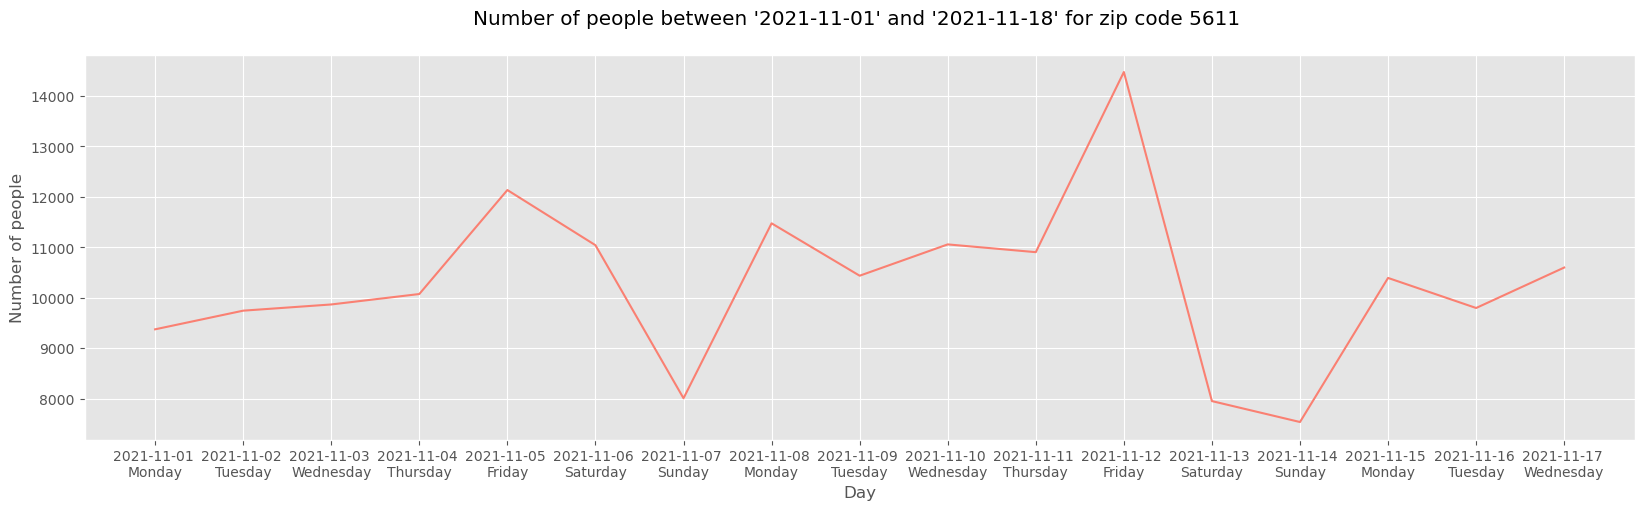

In [34]:
plt.figure(figsize = (20 ,5))

plt.plot(people_pollution_multiple_weeks_5611["date"] + " \n" + pd.DatetimeIndex(people_pollution_multiple_weeks_5611["date"]).day_name(), 
         people_pollution_multiple_weeks_5611["people_number"], color="salmon")
 
# Adding Title to the Plot
plt.title("Number of people between '2021-11-01' and '2021-11-18' for zip code 5611 \n")

# Setting the X and Y labels
plt.xlabel("Day")
plt.ylabel("Number of people")
  
plt.show()

After looking at the population for a few weeks, we can notice a pattern. The number of people balances during the week; it begins to rise on Thursday and peaks on Friday before falling on Saturday, reaching its lowest point on Sunday, and then rising once more on Monday.

<h4><font color=mediumvioletred> Visualize the distribution of population using Boxplot and Histogram</font></h4>

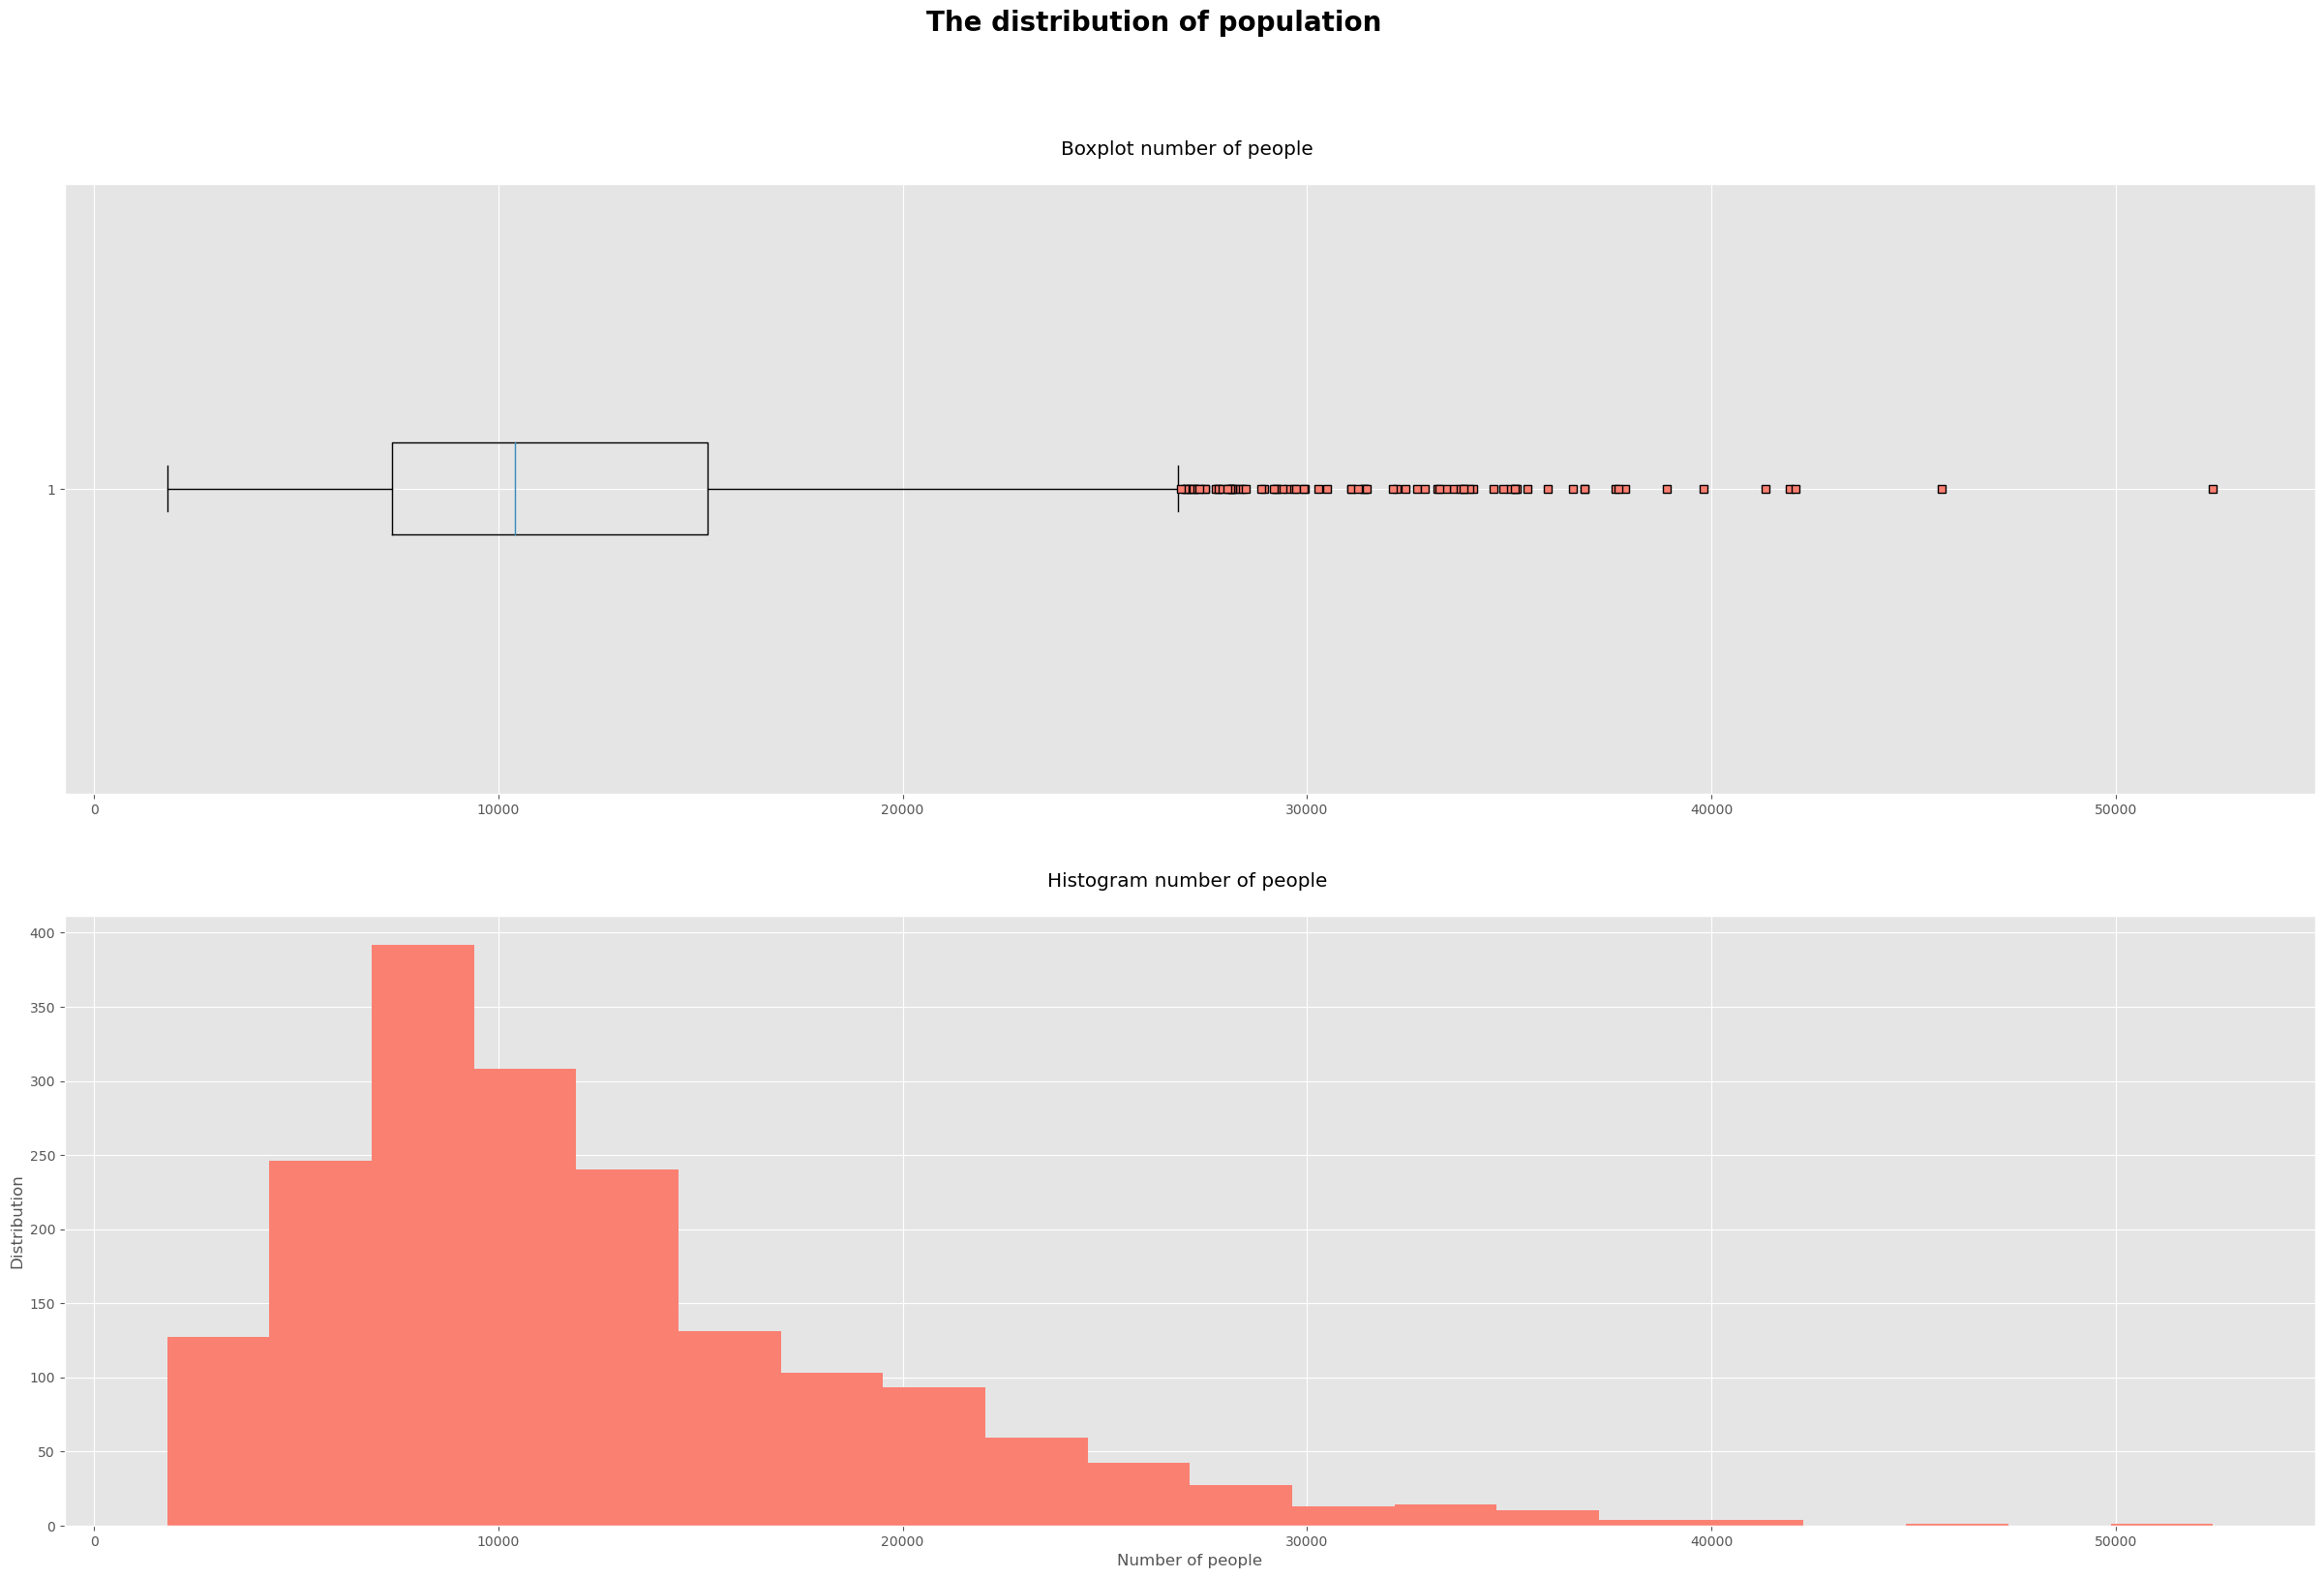

In [35]:
# Subplot of number of people distribution
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 18),
                                sharex=False)

# Add data to ax0
red_square = dict(markerfacecolor="salmon", marker="s")
ax0.boxplot(people_pollution_per_day_area["people_number"], vert=False, flierprops=red_square);
# Add data to ax1
ax1.hist(people_pollution_per_day_area["people_number"], bins=20, color="salmon");

# Customize ax0
ax0.set(title="Boxplot number of people \n");

# Customize ax1
ax1.set(title="Histogram number of people \n",
        xlabel="Number of people",
        ylabel="Distribution");

# Add a title to the figure
fig.suptitle("The distribution of population", fontsize=20, fontweight="bold");

From the graphs, we can derive that there are a few outliers, starting around 27000.

<h4><font color=mediumvioletred> Visualize the distribution of fine particulate matter using Boxplot and Histogram</font></h4>

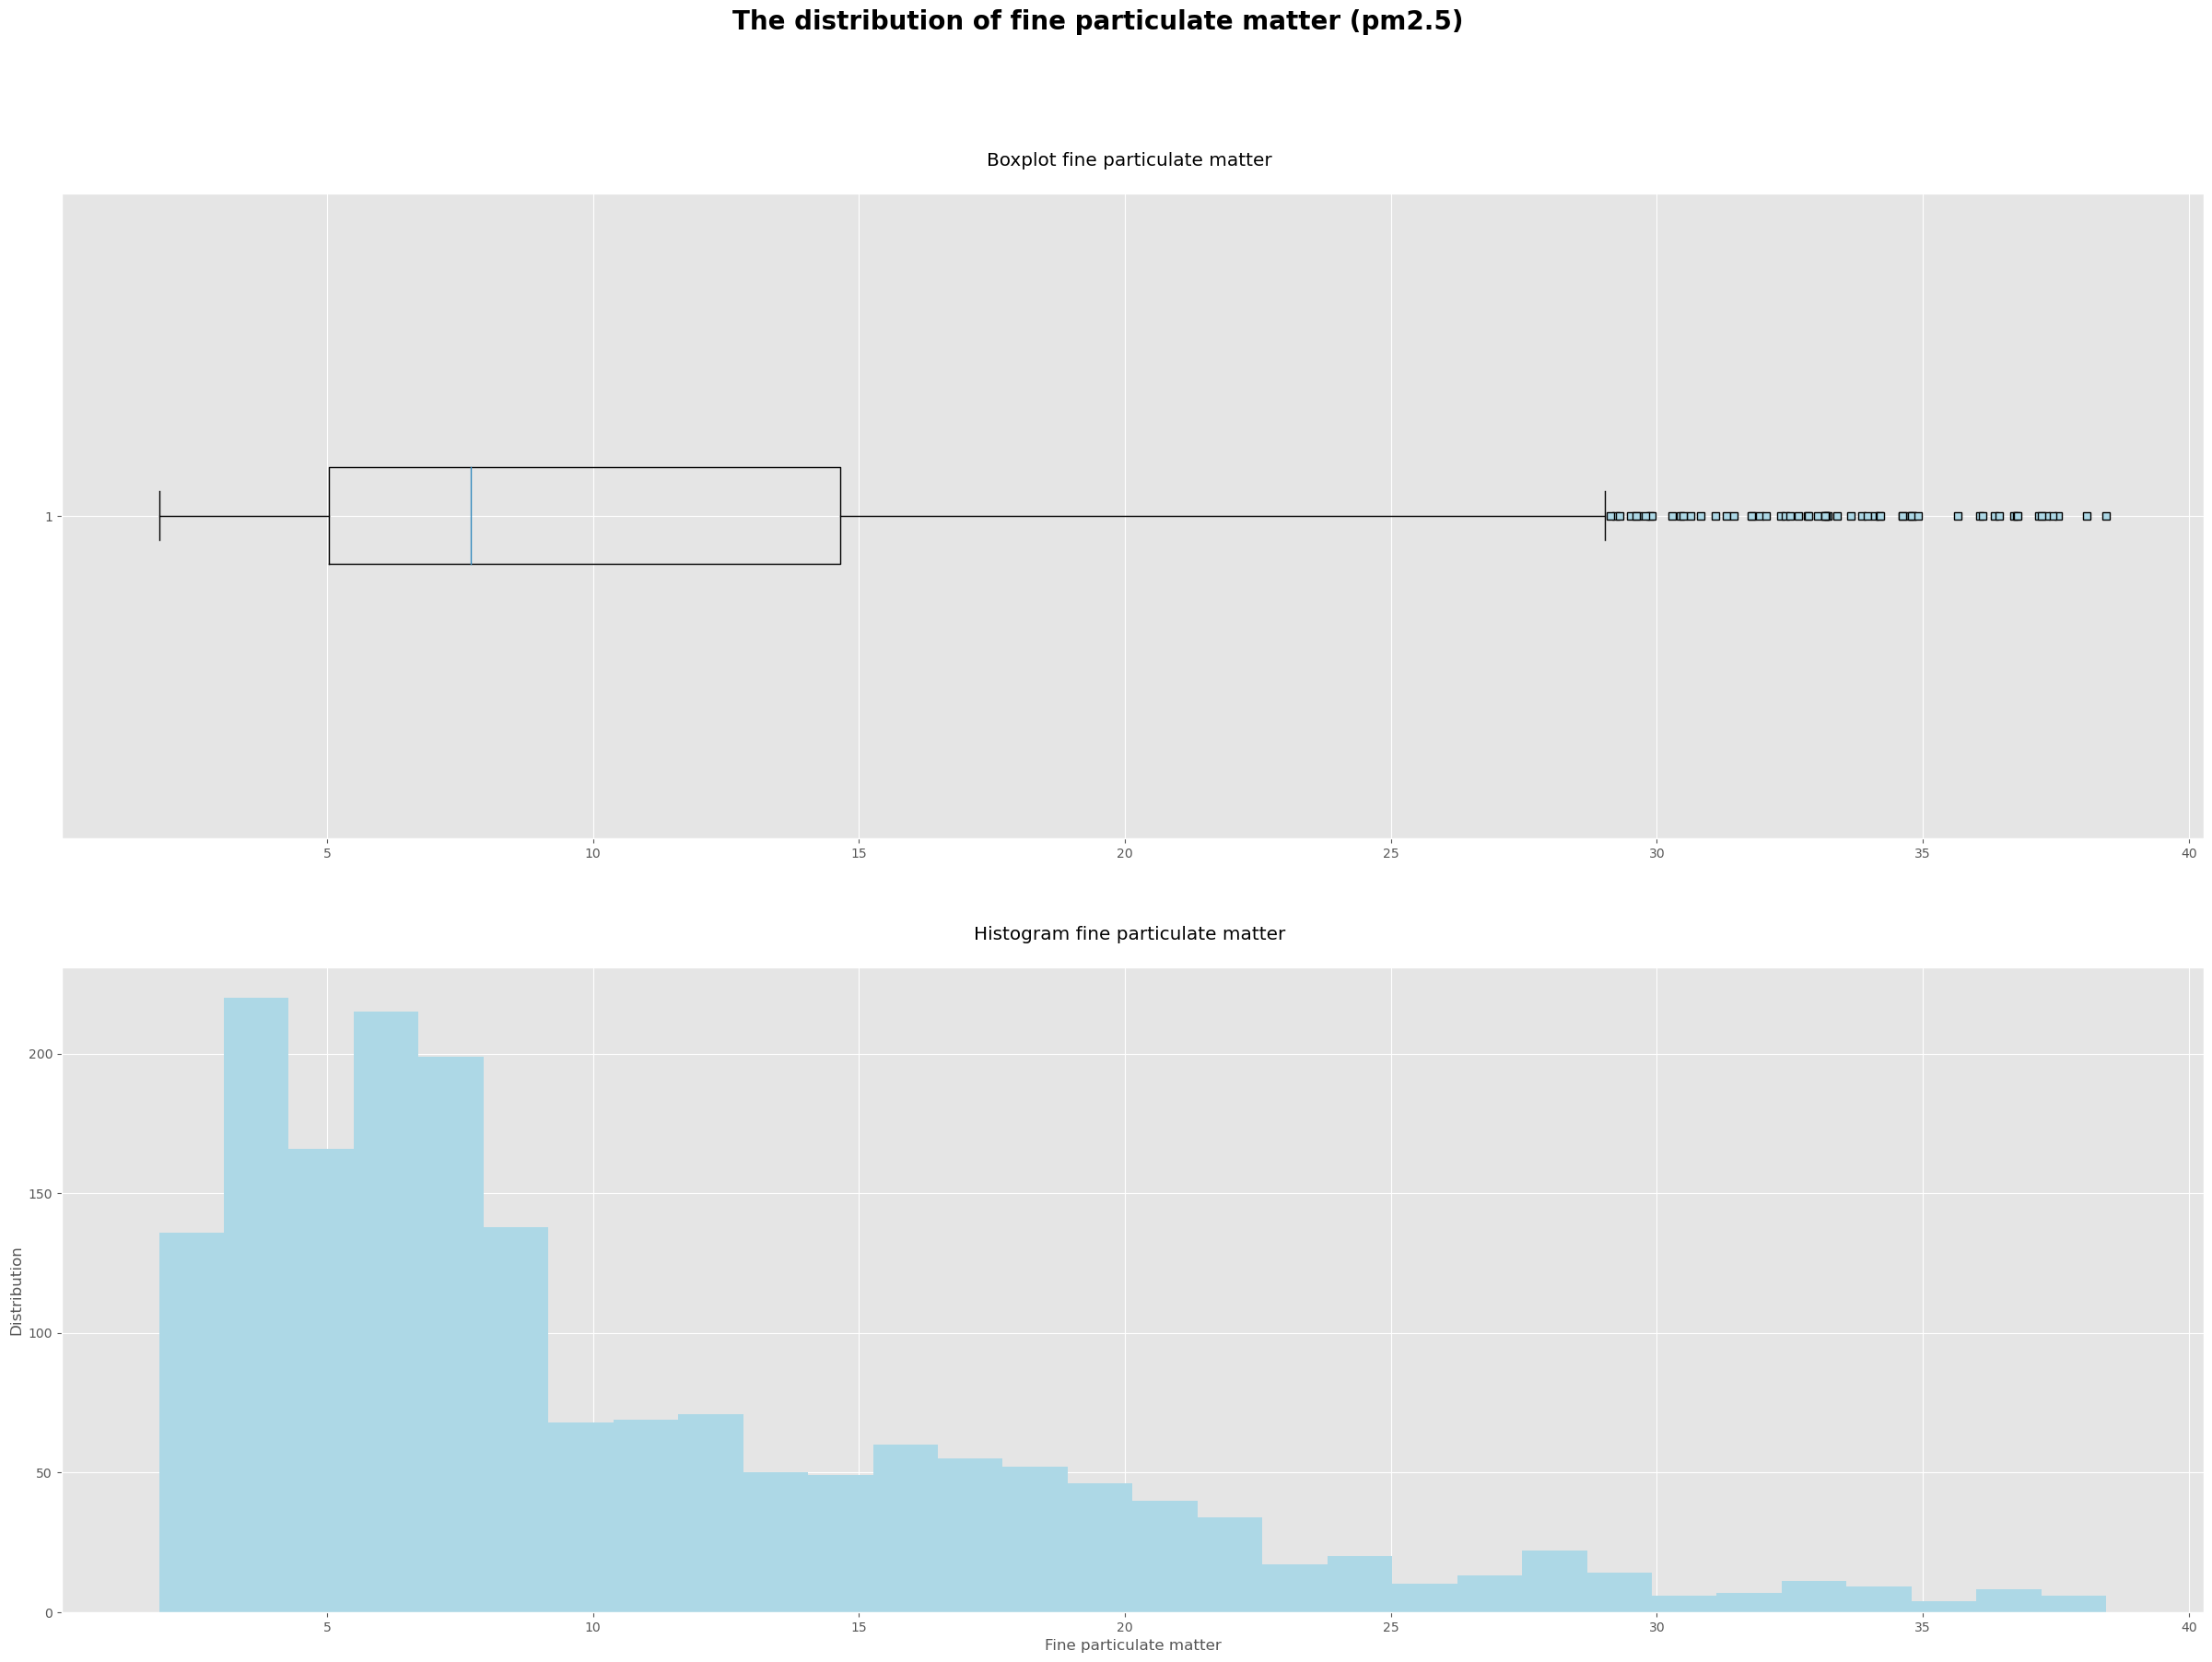

In [36]:
# Subplot of pollution distribution
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 20),
                                sharex=False)

# Add data to ax0
red_square = dict(markerfacecolor="lightblue", marker="s")
ax0.boxplot(people_pollution_per_day_area["pm2.5"], vert=False, flierprops=red_square);
# Add data to ax1
ax1.hist(people_pollution_per_day_area["pm2.5"], bins=30, color="lightblue");

# Customize ax0
ax0.set(title="Boxplot fine particulate matter \n");

# Customize ax1
ax1.set(title="Histogram fine particulate matter \n",
        xlabel="Fine particulate matter",
        ylabel="Distribution");

# Add a title to the figure
fig.suptitle("The distribution of fine particulate matter (pm2.5)", fontsize=20, fontweight="bold");

From the graphs, we can derive that there are a few outliers, starting around 28.

<h4><font color=mediumvioletred> Visualize the population vs fine particulate matter (pm2.5) per area</font></h4>

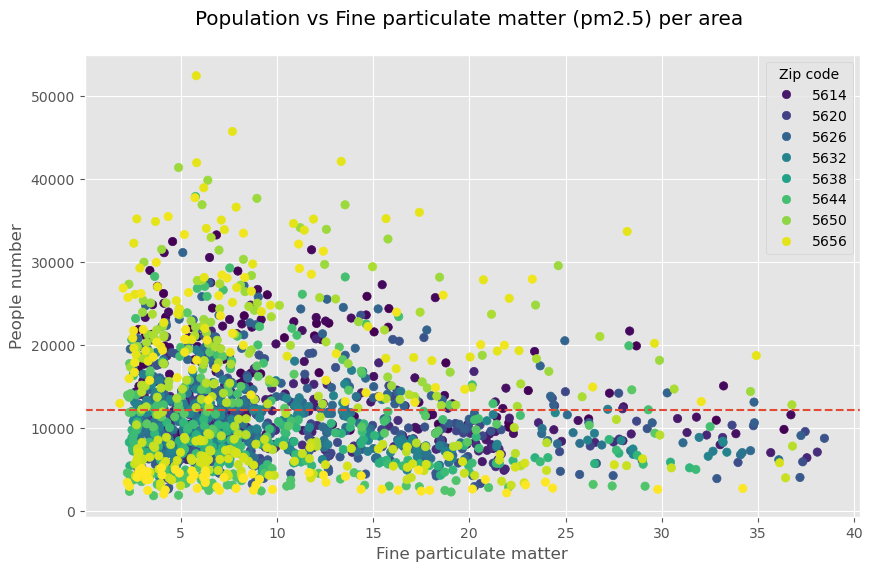

In [37]:
# OO method
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
scatter = ax.scatter(x=people_pollution_per_day_area["pm2.5"],
                    y=people_pollution_per_day_area["people_number"],
                    c=people_pollution_per_day_area["PC4"]);

# Customize the plot
ax.set(title="Population vs Fine particulate matter (pm2.5) per area \n",
      xlabel="Fine particulate matter",
      ylabel="People number");

# Add a legend
ax.legend(*scatter.legend_elements(), title="Zip code");

# Add a horizontal line
ax.axhline(people_pollution_per_day_area["people_number"].mean(),
          linestyle="--");

The above scatter plot confirms our previous findings, that both the people number and fine particulate matter have some outliers which need to be handled in order to produce an accurate model.

<h4><font color=mediumvioletred>Specify country code in Pgeocode library </font></h4>

In [38]:
nomi = pgeocode.Nominatim('nl')

<h4><font color=mediumvioletred>Get postal code information for zip code 5621 </font></h4>

In [39]:
nomi.query_postal_code("5621")

postal_code                5621
country_code                 NL
place_name            Eindhoven
state_name        Noord-Brabant
state_code                    6
county_name           Eindhoven
county_code                 772
community_name              NaN
community_code              NaN
latitude                51.4549
longitude                 5.457
accuracy                    6.0
Name: 0, dtype: object

<h4><font color=mediumvioletred>Get sample of of zichtop air pollution dataframe </font></h4>

In [40]:
df_zichtop_air_pollution.sample(5)

PC4           date_time  pop_tot      pm2.5  m00_30  m30_60   H1_2  \
1064   5611 2021-11-08 08:00:00     5078  21.845526   586.0    75.0  192.0   
5866   5615 2021-10-19 10:00:00     3048   5.347233   828.0   141.0   53.0   
41050  5657 2021-09-30 10:00:00     5261   1.813743   995.0   218.0  422.0   
30122  5644 2021-11-09 02:00:00     1061  19.408897    32.0     0.0    0.0   
28697  5643 2021-11-04 17:00:00     2339  14.257953   192.0    71.0   40.0   

        H2_4    H4_8   H8_16  H16plus        date      time  
1064   468.0  1927.0  1278.0    552.0  2021-11-08  08:00:00  
5866   476.0   846.0   194.0    510.0  2021-10-19  10:00:00  
41050  572.0  1104.0  1840.0    110.0  2021-09-30  10:00:00  
30122    8.0   113.0    24.0    884.0  2021-11-09  02:00:00  
28697  272.0   161.0   413.0   1190.0  2021-11-04  17:00:00

<h4><font color=mediumvioletred>Create a new dataframe containing unique zip codes </font></h4>

In [41]:
zipcodes = pd.DataFrame({"PC4": df_zichtop_air_pollution["PC4"].unique()})
zipcodes.head(5)

PC4
0  5611
1  5612
2  5613
3  5614
4  5615

<h4><font color=mediumvioletred>Add latitude, longitude data to the zip codes dataframe </font></h4>

In [42]:
# add latitude, longitude data to the dataframe
zipcodes["latitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
zipcodes["longitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [43]:
zipcodes["PC4"] = zipcodes["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of zip codes </font></h4>

In [44]:
zipcodes.sample(5)

PC4  latitude  longitude
14  5628   51.4801     5.4724
18  5633   51.4899     5.4954
3   5614   51.4284     5.4921
32  5658   51.4405     5.4098
9   5623   51.4595     5.4782

<h4><font color=mediumvioletred>Plot the map with the latitude, longitude and zip code in Eindhoven</font></h4>

In [45]:
fig = px.scatter_mapbox(zipcodes, 
                        title="Eindhoven map with latitude, longitude and zip code", 
                        lat="latitude", 
                        lon="longitude", 
#                         text="PC4", 
                        hover_name="PC4", 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>Get min and max number of people per area</font></h4>

In [46]:
min_max_people_per_area = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min"]).rename(columns={'max': 'max_number_people', "min": "min_number_people"}).reset_index()
min_max_people_per_area.head(5)

PC4  max_number_people  min_number_people
0  5611              11617                708
1  5612              10250                737
2  5613               5925                537
3  5614               3504                217
4  5615               4408                394

<h4><font color=mediumvioletred>Add latitude, longitude data to the min_max_people_per_area dataframe </font></h4>

In [47]:
min_max_people_per_area["latitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
min_max_people_per_area["longitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [48]:
min_max_people_per_area["PC4"] = min_max_people_per_area["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of min_max_people_per_area </font></h4>

In [49]:
min_max_people_per_area.sample(5)

PC4  max_number_people  min_number_people  latitude  longitude
6   5617               4162                 76   51.4470     5.4573
14  5628               5903                945   51.4801     5.4724
5   5616               9085                724   51.4396     5.4592
31  5657               7759                143   51.4512     5.4008
11  5625               5919                606   51.4719     5.4754

<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zip code, minimum and maximum number of people in Eindhoven</font></h4>

In [50]:
fig = px.scatter_mapbox(min_max_people_per_area, 
                        title="Eindhoven map with latitude, longitude, zip code, maximum and minimum number of people", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        hover_data=["min_number_people"], 
                        color="max_number_people", 
                        size="max_number_people", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>People vs. pollution on 25-09-2021 </font></h4>

In [51]:
# Calculate people number (sum) and pm2.5 (average) on 2021-09-25
people_pollution_per_day = people_pollution_per_day_area[people_pollution_per_day_area.date == "2021-09-25"].reset_index(drop=True)
# Round to 2 decimal places
people_pollution_per_day = people_pollution_per_day.round(decimals=2)

people_pollution_per_day.head(5)

PC4        date  people_number  pm2.5
0  5611  2021-09-25        16501.0   9.16
1  5612  2021-09-25        23022.0   9.18
2  5613  2021-09-25        14987.0   8.56
3  5614  2021-09-25        10039.0   8.45
4  5615  2021-09-25        11540.0   8.97

<h4><font color=mediumvioletred>Add latitude, longitude data to the people_pollution_per_day dataframe </font></h4>

In [52]:
people_pollution_per_day["latitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
people_pollution_per_day["longitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [53]:
people_pollution_per_day["PC4"] = people_pollution_per_day["PC4"].astype("str")

<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zip code, number of people and fine inhalable particulate matter in Eindhoven</font></h4>

In [54]:
fig = px.scatter_mapbox(people_pollution_per_day, 
                        title="Number of people vs. fine inhalable particulate matter per zip code in Eindhoven on 25-09-2021", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        color="pm2.5", 
                        size="people_number", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred> Conclusion </font></h4>

After exploring and visualizing the zichtop dataset, we conclude that the only relevant columns to use in the following steps are  date, PC4 (zip code) and a new column called people_number (m00_30 + m30_60).

We need this new column because we want to group data per area and date and currently pop_tot column is the result of the sum of the following columns (m00_30, m30_60, H1_2, H2_4, H4_8, H8_16 and H16plus), so the same people are counted multiple times throughout the day and that will result in inaccurate number of people.

<h3><font color=steelblue>Meteo dataset</font></h3>

<h4><font color=mediumvioletred>Read CSV files and get meteo data sample</font></h4>

In [55]:
df_meteo = pd.read_csv("data/meteo.csv")
df_air_pollution = pd.read_csv("data/air_pollution.csv")
df_meteo.sample(10)

date   PC4          wd        ws          blh  \
1844    2021-03-18 20:00:00  5611  106.204613  4.211328   710.725586   
31149   2021-07-22 21:00:00  5614   80.656906  3.250746   305.527283   
205848  2021-07-02 00:00:00  5645  228.427032  2.128551   164.422821   
256572  2021-04-16 12:00:00  5655   53.473675  3.688630  1951.982788   
207411  2021-09-05 03:00:00  5645   25.566059  2.589992   168.847748   
242856  2021-09-22 00:00:00  5653  208.800049  1.893487    33.303474   
176320  2021-02-16 16:00:00  5642  248.383163  4.687929   491.562103   
266176  2021-05-21 16:00:00  5656  229.246674  8.858345  1946.298828   
190594  2021-10-04 10:00:00  5643  252.785278  5.756042  1406.948364   
150290  2021-02-27 02:00:00  5632  124.677338  1.584405    98.367188   

             tcc        ssrd  
1844    1.000000    0.000000  
31149   0.017297    0.000000  
205848  0.668310    0.000000  
256572  0.954135  664.227708  
207411  0.010229    0.000000  
242856  0.829455    0.000000  
176320  0.983886   72.787821  
266176  0.338827  405.111667  
190594  0.334036  445.385000  
150290  0.563043    0.000000

<h4><font color=mediumvioletred>Get air pollution data sample</font></h4>

In [56]:
df_air_pollution.sample(10)

date   PC4       pm10      pm2.5        no2         no  \
54356  2021-12-02 19:00:00  5642  25.737257  32.903534  47.858512   2.854157   
51911  2021-10-13 23:00:00  5658  12.116565   8.224682  49.081293  32.111697   
64120  2021-12-14 15:00:00  5657  36.818030  62.828250  32.798912   5.571597   
33169  2021-11-06 01:00:00  5642   9.935568   7.206686  38.225782  25.009421   
47326  2021-10-23 22:00:00  5655  20.170794  15.970255  41.138024  26.914771   
67874  2021-12-19 01:00:00  5645  21.290270  40.687480   9.868966   0.002544   
2005   2021-10-11 13:00:00  5612   6.225220   3.337911  13.151105   8.604181   
40765  2021-10-18 13:00:00  5651  20.350563   9.720498  16.942523  11.084735   
29332  2021-10-11 04:00:00  5633  10.886483   5.635964  14.862430   9.723824   
65625  2021-12-16 08:00:00  5654  46.340470  59.340610  30.747973  32.240975   

            so2  
54356  1.068630  
51911  7.427282  
64120  3.078750  
33169  5.408741  
47326  3.564192  
67874  0.261166  
2005   1.139113  
40765  4.176146  
29332  1.266883  
65625  3.067640

<h4><font color=mediumvioletred>Show all postal codes</font></h4>

In [57]:
df_meteo['PC4'].unique()

array([5611, 5612, 5613, 5614, 5615, 5616, 5617, 5621, 5622, 5623, 5624,
       5625, 5626, 5627, 5628, 5629, 5631, 5632, 5633, 5641, 5642, 5643,
       5644, 5645, 5646, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658],
      dtype=int64)

The dataset contains data from 33 different postal code areas

<h4><font color=mediumvioletred>Show the shape of the meteo data</font></h4>

In [58]:
df_meteo.shape

(289080, 7)

<h4><font color=mediumvioletred>Show all datatypes of meteo data</font></h4>

In [59]:
df_meteo['date'] = pd.to_datetime(df_meteo['date'])
df_air_pollution['date'] = pd.to_datetime(df_air_pollution['date'])
df_meteo.dtypes

date    datetime64[ns]
PC4              int64
wd             float64
ws             float64
blh            float64
tcc            float64
ssrd           float64
dtype: object

<h4><font color=mediumvioletred>Filter meteo data on single postal code and get a sample</font></h4>

In [60]:
postalcode_df_meteo = df_meteo[df_meteo['PC4'] == 5611]
postalcode_df_meteo.sample(10)

date   PC4          wd        ws          blh       tcc  \
5168 2021-08-04 08:00:00  5611  351.544342  1.118761   260.155396  0.459068   
4186 2021-06-24 10:00:00  5611   77.560036  2.710129   853.184082  1.000000   
8111 2021-12-04 23:00:00  5611  233.593628  4.824674   484.342529  0.979842   
2827 2021-04-28 19:00:00  5611   68.944695  6.276313   309.790070  0.995640   
8350 2021-12-14 22:00:00  5611  226.753830  3.767917   393.230682  1.000000   
348  2021-01-15 12:00:00  5611   99.644569  2.328954   902.983582  0.646490   
8713 2021-12-30 01:00:00  5611  213.571411  4.493748   546.324402  0.979545   
4650 2021-07-13 18:00:00  5611  103.974304  4.079460   539.555603  0.995070   
5197 2021-08-05 13:00:00  5611  281.842896  1.786347  1313.869385  0.749982   
4884 2021-07-23 12:00:00  5611   43.219925  3.073279   961.231018  0.065634   

            ssrd  
5168  348.612292  
4186  428.800104  
8111    0.000000  
2827    7.955243  
8350    0.000000  
348   187.636510  
8713    0.000000  
4650   54.788294  
5197  541.540243  
4884  789.324236

In this sample the solar surface radiation downawrd (ssrd) shows the value 0.000000. After researching this, it is normal since the sensor can measure this during 6 p.m. and 6 a.m.

<h4><font color=mediumvioletred>Show standard distribution of boundary layer height data</font></h4>

Skewness per column:
PC4     0.133640
wd     -0.214002
ws      0.931107
blh     1.054221
tcc    -0.894305
ssrd    1.656176
dtype: float64


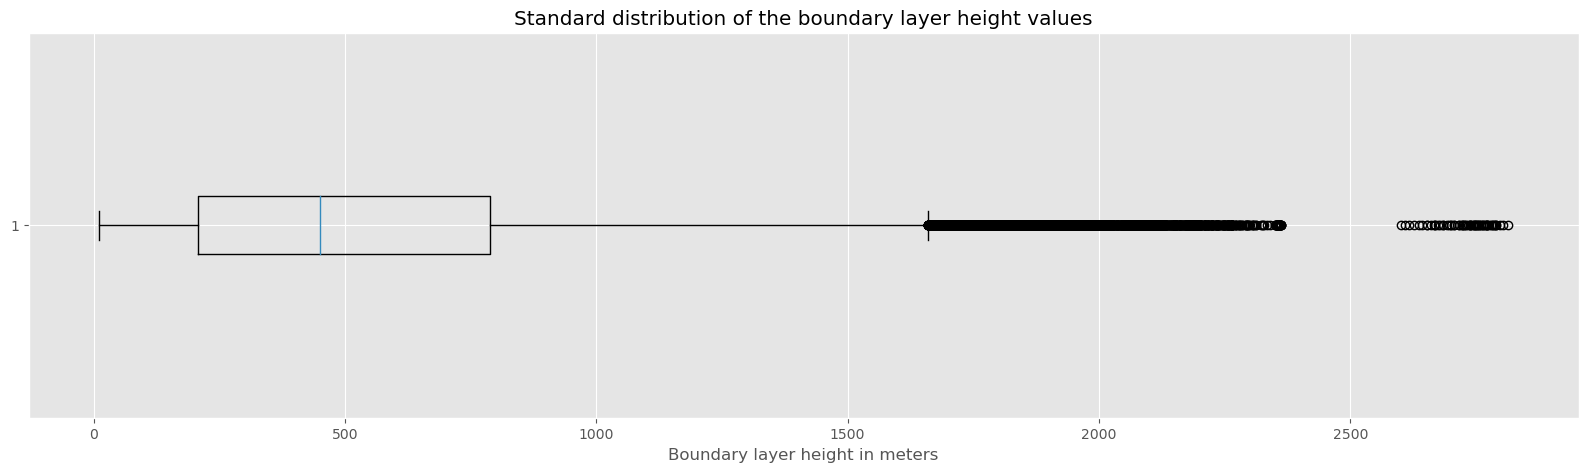

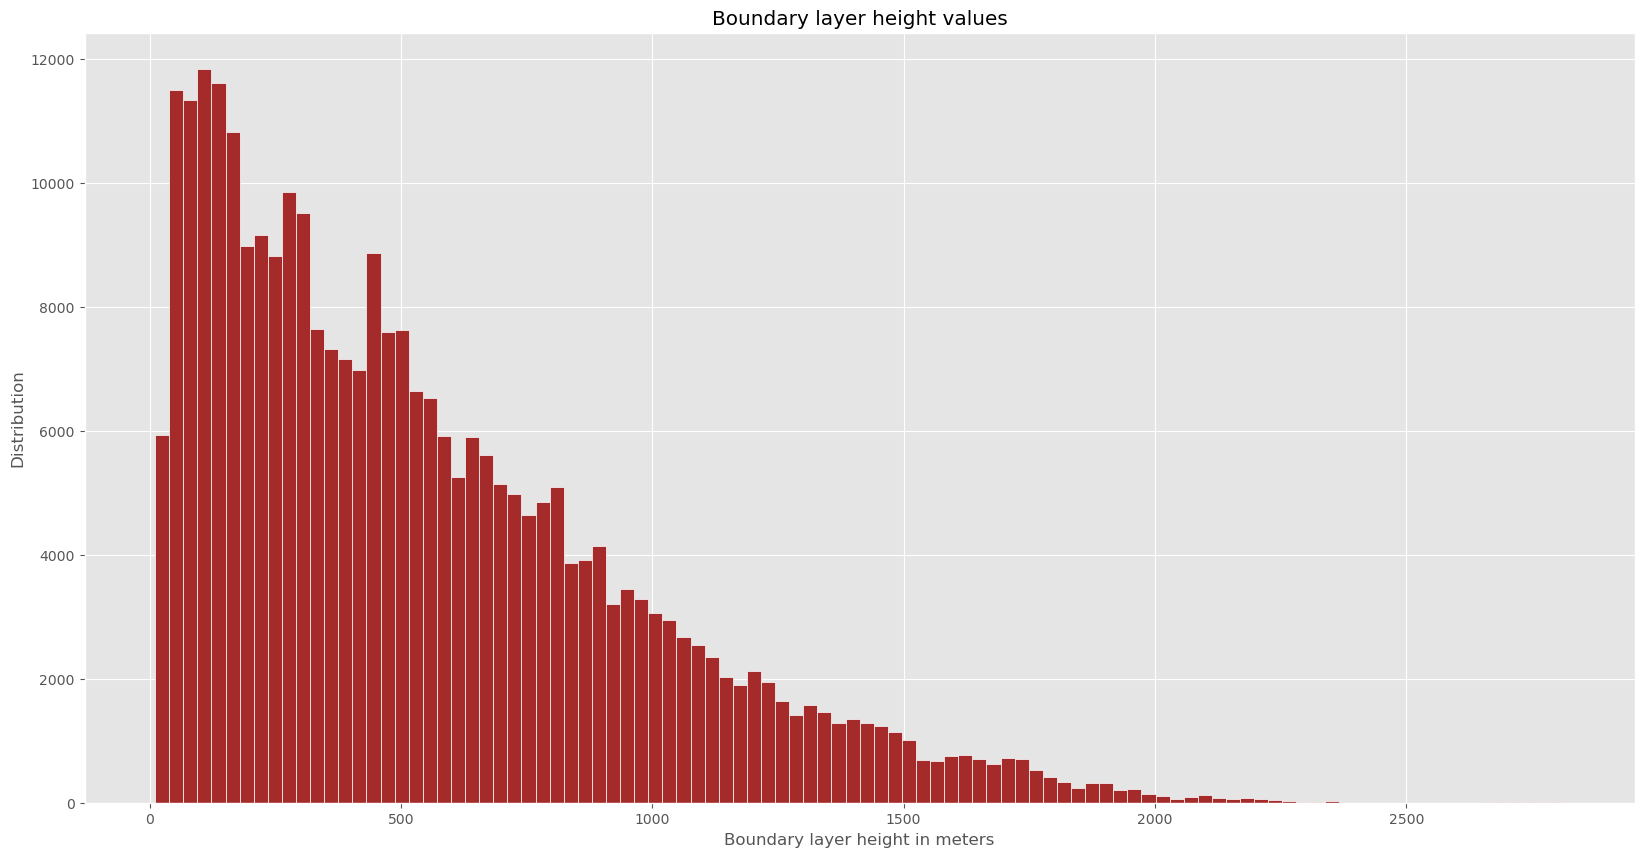

In [61]:
print("Skewness per column:")
print(df_meteo.skew(numeric_only=True))

plt.figure(figsize=(20,5))
plt.boxplot(df_meteo['blh'], vert=False)
plt.title("Standard distribution of the boundary layer height values")
plt.xlabel("Boundary layer height in meters")
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_meteo['blh'], edgecolor='white', color='brown', bins=100)
plt.title("Boundary layer height values")
plt.xlabel("Boundary layer height in meters")
plt.ylabel("Distribution")
plt.show()

The graphs represent the distribution of the boundary layer height data. The skewness of these graphs are positive. Most of the boundary layer heights are close to zero. You also don't see a lot of outliers on the bottom graph, since the tail of data is not long. This means that the distribution is devided relatively evenly.

<h4><font color=mediumvioletred>Visualize windspeed compared to solar surface radiation downwards</font></h4>

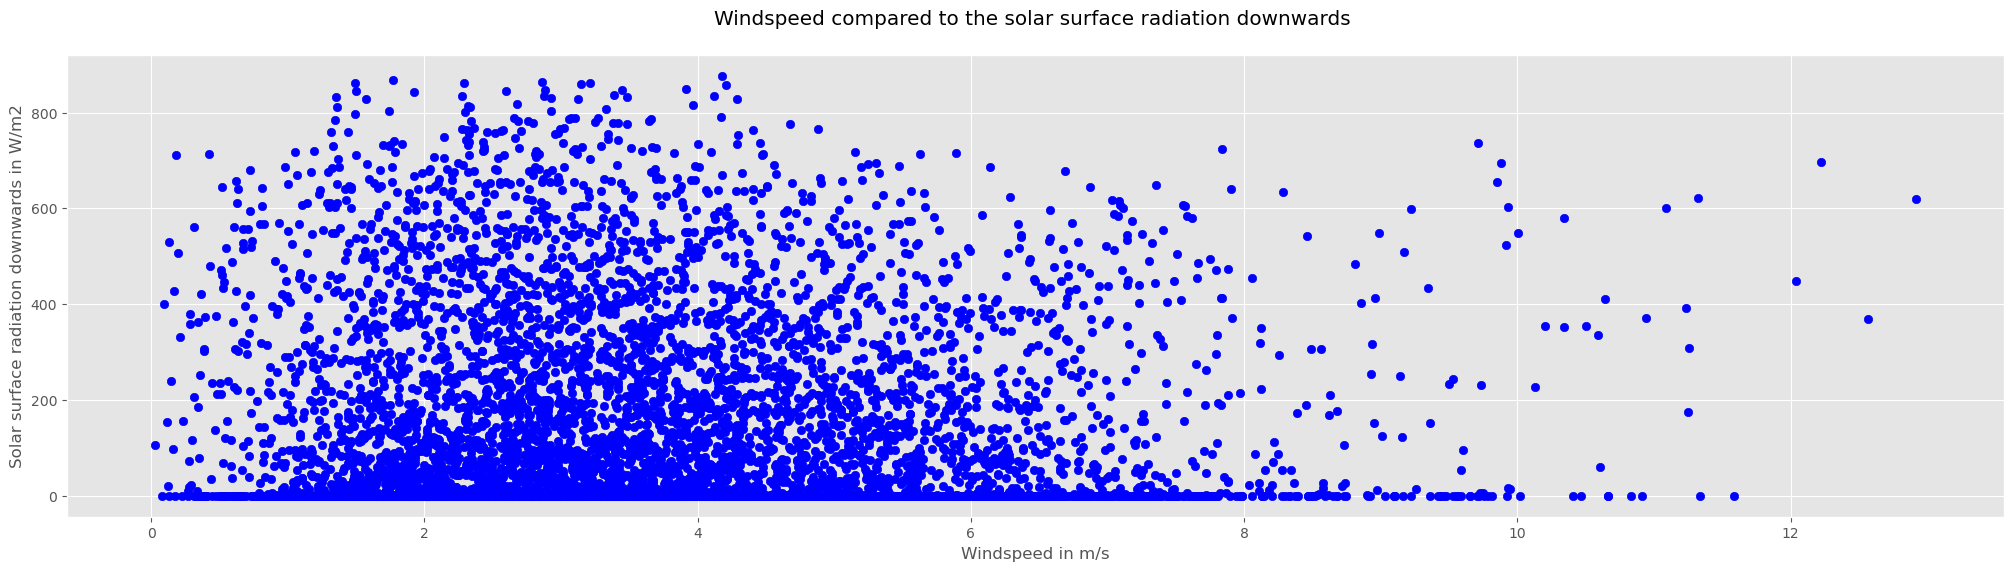

In [62]:
fig, ax = plt.subplots(figsize=(25, 6))
scatter = ax.scatter((postalcode_df_meteo["ws"]),
                list(postalcode_df_meteo["ssrd"]),
                color="blue")

ax.set(title="Windspeed compared to the solar surface radiation downwards \n",
      xlabel="Windspeed in m/s",
      ylabel="Solar surface radiation downwards in W/m2");

In the graph above you can see that the solar surface rediation downwards (ssrd) almost doesn't appear when the windspeed is above 8m/s. So there is a visable correlation between the windspeed and ssrd. It also shows the 0.000000 values of the ssrd.

<h4><font color=mediumvioletred>Visualize windspeed in September from postal code 5611</font></h4>

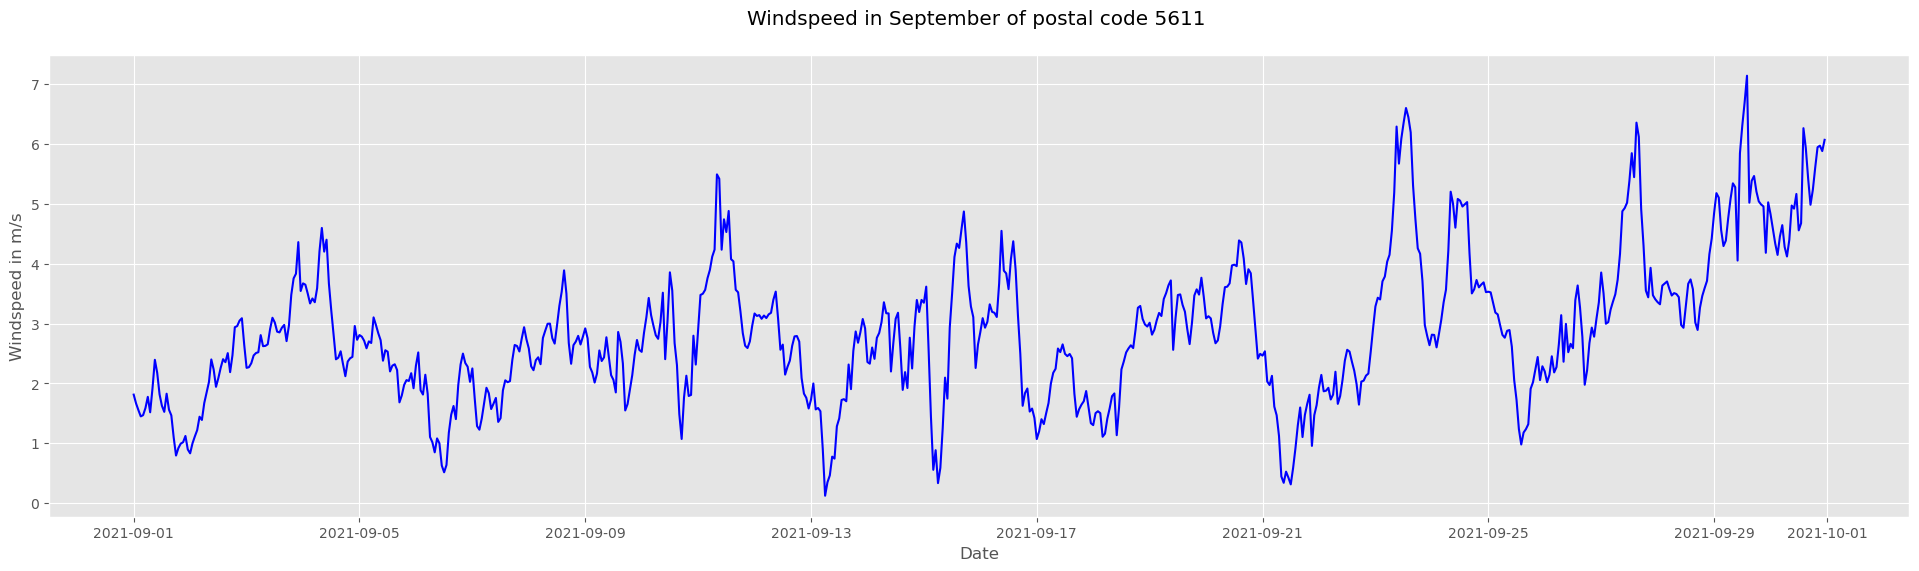

In [63]:
one_month_postalcode_df_meteo = postalcode_df_meteo[postalcode_df_meteo['date']. dt. strftime('%Y-%m')=='2021-09']

fig, ax = plt.subplots(figsize=(24, 6))
plot = ax.plot(list(one_month_postalcode_df_meteo["date"]),
                list(one_month_postalcode_df_meteo["ws"]),
                color="blue")

ax.set(title="Windspeed in September of postal code 5611 \n",
      xlabel="Date",
      ylabel="Windspeed in m/s");

No real conclusion can be drawn from just looking at the windspeed data. 

<h4><font color=mediumvioletred>Merge meteo and air pollution dataset and show sample</font></h4>

In [64]:
df_meteo_air_pollution = pd.merge(df_meteo, df_air_pollution[['PC4','date', 'pm10', 'pm2.5', 'no2',	'no', 'so2']], on=['PC4', 'date'])
df_meteo_air_pollution.sample(10)

date   PC4          wd        ws         blh       tcc  \
67836 2021-10-08 12:00:00  5655   28.207504  2.344624  733.347656  0.025319   
75876 2021-11-21 12:00:00  5658  128.971619  2.528286  599.015198  0.781715   
74303 2021-12-22 22:00:00  5657  297.076477  2.636049  149.173950  0.979124   
14429 2021-10-14 05:00:00  5617  210.136566  3.776536  305.312531  0.992090   
5683  2021-11-06 19:00:00  5613  227.180161  7.107313  973.817017  1.000000   
16518 2021-10-04 06:00:00  5621  271.113983  4.294477  369.098480  0.806086   
67172 2021-12-16 19:00:00  5654  141.925781  1.032362   49.767731  0.983472   
40027 2021-10-13 19:00:00  5632  187.967026  2.833591  402.432556  0.892364   
63289 2021-10-13 01:00:00  5653  150.264954  2.386841  140.233215  0.886045   
302   2021-10-07 14:00:00  5611    3.949022  1.186967  653.046997  0.656787   

             ssrd       pm10      pm2.5        no2         no       so2  
67836  485.621701  18.746538  16.115866  23.155566  15.149652  4.058710  
75876  121.136884   7.839937   3.141516   8.603062   5.628599  1.033268  
74303    0.000000  22.891720  41.893680  30.122469   0.477682  4.728393  
14429    0.000000  21.817394  17.070791  19.608250  12.828802  5.711623  
5683     0.000000   7.056696   4.249462  19.332429  12.648345  4.966158  
16518    0.636418  11.473091   4.985270  28.908467  18.913519  3.503602  
67172    0.000000  46.902760  61.702690  25.164176  52.749989  2.320839  
40027    0.000000   9.873612   3.870209  48.278899  31.586726  1.989984  
63289    0.000000  15.071152   9.578329  33.278081  21.772362  1.320097  
302    278.788351  20.102510   8.612182   9.738409   6.371406  0.795053

<h4><font color=mediumvioletred>Show corrolation between merged meteo and air pollution data</font></h4>

In [65]:
df_meteo_air_pollution.corr(method='spearman')

C:\Users\rawan\AppData\Local\Temp\ipykernel_36828\329891679.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



PC4        wd        ws       blh       tcc      ssrd      pm10  \
PC4    1.000000 -0.000203 -0.001175 -0.000395 -0.000085  0.000106 -0.026865   
wd    -0.000203  1.000000  0.190082  0.048322  0.050032  0.032333 -0.148475   
ws    -0.001175  0.190082  1.000000  0.807271  0.176822  0.073962 -0.607904   
blh   -0.000395  0.048322  0.807271  1.000000  0.200182  0.341155 -0.615602   
tcc   -0.000085  0.050032  0.176822  0.200182  1.000000  0.001251 -0.031441   
ssrd   0.000106  0.032333  0.073962  0.341155  0.001251  1.000000 -0.059004   
pm10  -0.026865 -0.148475 -0.607904 -0.615602 -0.031441 -0.059004  1.000000   
pm2.5 -0.028674 -0.106274 -0.472557 -0.542800  0.110042 -0.158170  0.886844   
no2   -0.034462 -0.161741 -0.591700 -0.655762 -0.105527 -0.206825  0.560476   
no    -0.027125 -0.109364 -0.499212 -0.502562 -0.186421 -0.049303  0.283385   
so2    0.004346 -0.008121 -0.212465 -0.337730 -0.208994 -0.076840  0.336788   

          pm2.5       no2        no       so2  
PC4   -0.028674 -0.034462 -0.027125  0.004346  
wd    -0.106274 -0.161741 -0.109364 -0.008121  
ws    -0.472557 -0.591700 -0.499212 -0.212465  
blh   -0.542800 -0.655762 -0.502562 -0.337730  
tcc    0.110042 -0.105527 -0.186421 -0.208994  
ssrd  -0.158170 -0.206825 -0.049303 -0.076840  
pm10   0.886844  0.560476  0.283385  0.336788  
pm2.5  1.000000  0.431592  0.014917  0.189855  
no2    0.431592  1.000000  0.735620  0.394545  
no     0.014917  0.735620  1.000000  0.371746  
so2    0.189855  0.394545  0.371746  1.000000

With the spearman method, it can be noted that the particulate matter smaller than 2.5 micrometer (pm2.5) has the most corrolation with the boundary layer height (blh), the windspeed (ws), and nitrogen dioxide in ug/m3 (no2).

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and windspeed</font></h4>

-0.4220468437258586


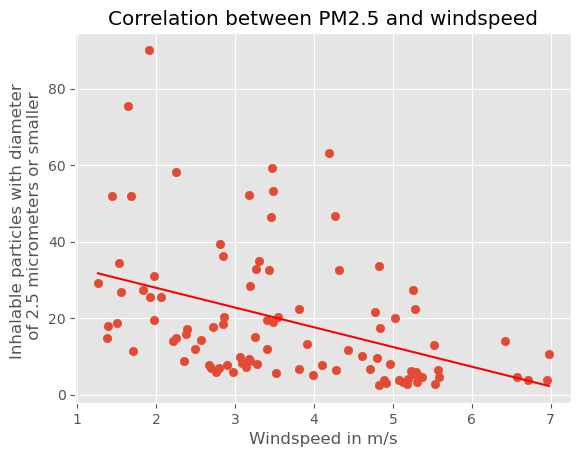

In [66]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["ws"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["ws"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["ws"]), np.poly1d(np.polyfit(group_by_day["ws"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["ws"])), color='red')
plt.title('Correlation between PM2.5 and windspeed')
plt.xlabel('Windspeed in m/s')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the windspeed keep increasing. So there is a low negative correlation between the two. Which means with higher wind speeds there are less particals of 2.5 micrometers or smaller in the air.

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and boundary layer height</font></h4>

-0.5270951619288825


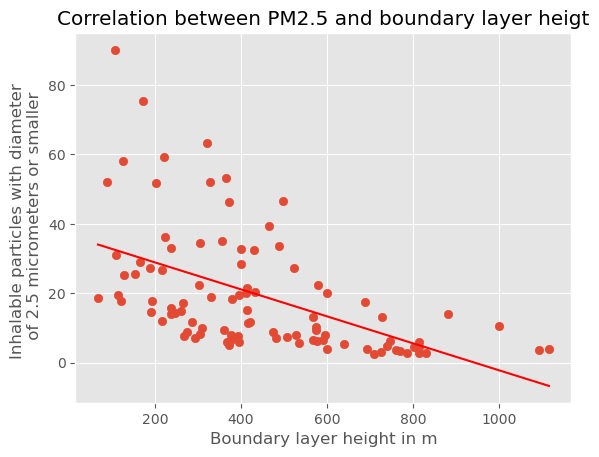

In [67]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["blh"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["blh"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["blh"]), np.poly1d(np.polyfit(group_by_day["blh"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["blh"])), color='red')
plt.title('Correlation between PM2.5 and boundary layer heigt')
plt.xlabel('Boundary layer height in m')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the boundary layer height keeps increasing. So there is a low negative correlation between the two. Which means that how higher the boundary layer, the less there are particles of 2.5 micrometer or smaller in the air.

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and solar surface radiation downwards</font></h4>

-0.44465439902953424


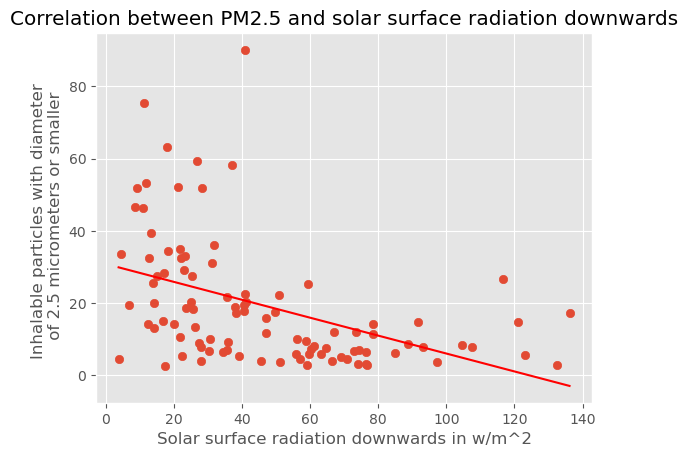

In [68]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["ssrd"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["ssrd"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["ssrd"]), np.poly1d(np.polyfit(group_by_day["ssrd"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["ssrd"])), color='red')
plt.title('Correlation between PM2.5 and solar surface radiation downwards')
plt.xlabel('Solar surface radiation downwards in w/m^2')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the solar surface radiation keep increasing. So there is a low negative correlation between the two. Which means that the higher the solar surface radiation is the less there are particles smaller than 2.5 micrometer in the air.

<h4><font color=mediumvioletred> Visualize the boundary layer height for the first week of November of postal code 5611</font></h4>

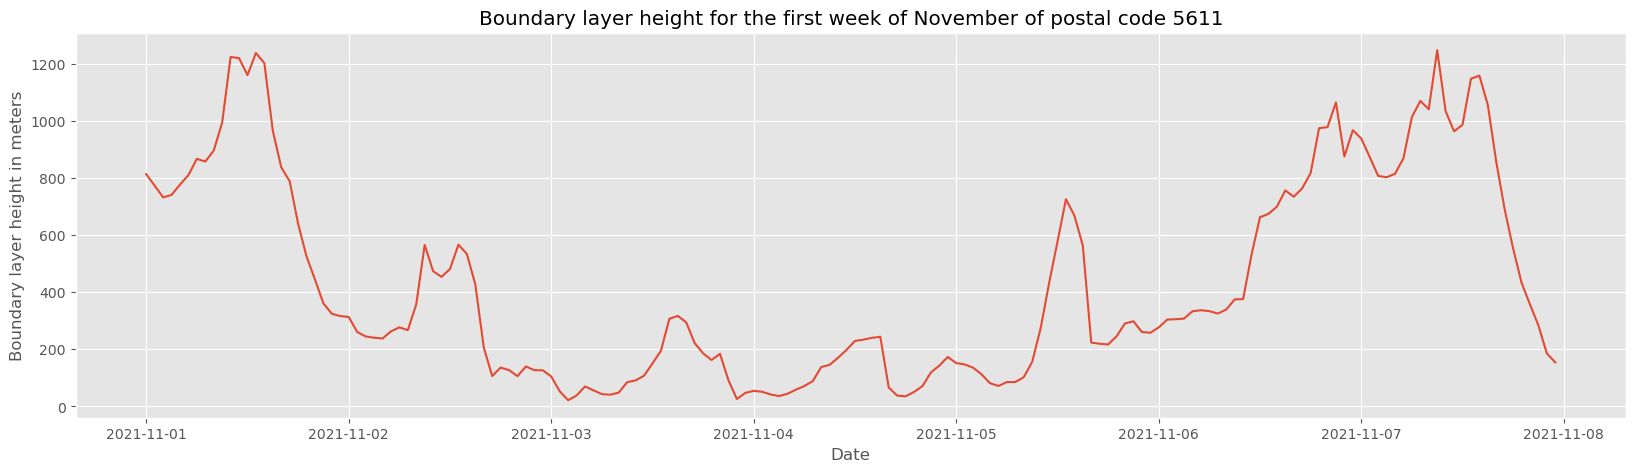

In [69]:
# Combined meto and air polution data for postalcode 5611
postalcode_df_meteo_air_polution = df_meteo_air_pollution[df_meteo_air_pollution['PC4'] == 5611]

# Combined data for the first week of november 2021 from postal code 5611 (24 * 7 = 168 entries)
one_week_postalcode_df_meteo_air_polution = postalcode_df_meteo_air_polution[postalcode_df_meteo_air_polution['date']. dt. strftime('%Y-%m')=='2021-11'].head(168)
    
plt.figure(figsize = (20 ,5))

plt.plot(one_week_postalcode_df_meteo_air_polution['date'], one_week_postalcode_df_meteo_air_polution['blh'])
 
# Adding Title to the Plot
plt.title('Boundary layer height for the first week of November of postal code 5611')

# Setting the X and Y labels
plt.xlabel('Date')
plt.ylabel('Boundary layer height in meters')
  
plt.show()

In the graph above you can see that almost every day at around noon the boundary layer height increases and decreases later at night. That is because the surface temperature at noon elevated lead to increased sensitive heat flux, and as a result, the boundary layer height will develop higher during daytime. 

<h4><font color=mediumvioletred> Visualize particulate matter smaller than 2.5 micrometers for the first week of November of postal code 5611</font></h4>

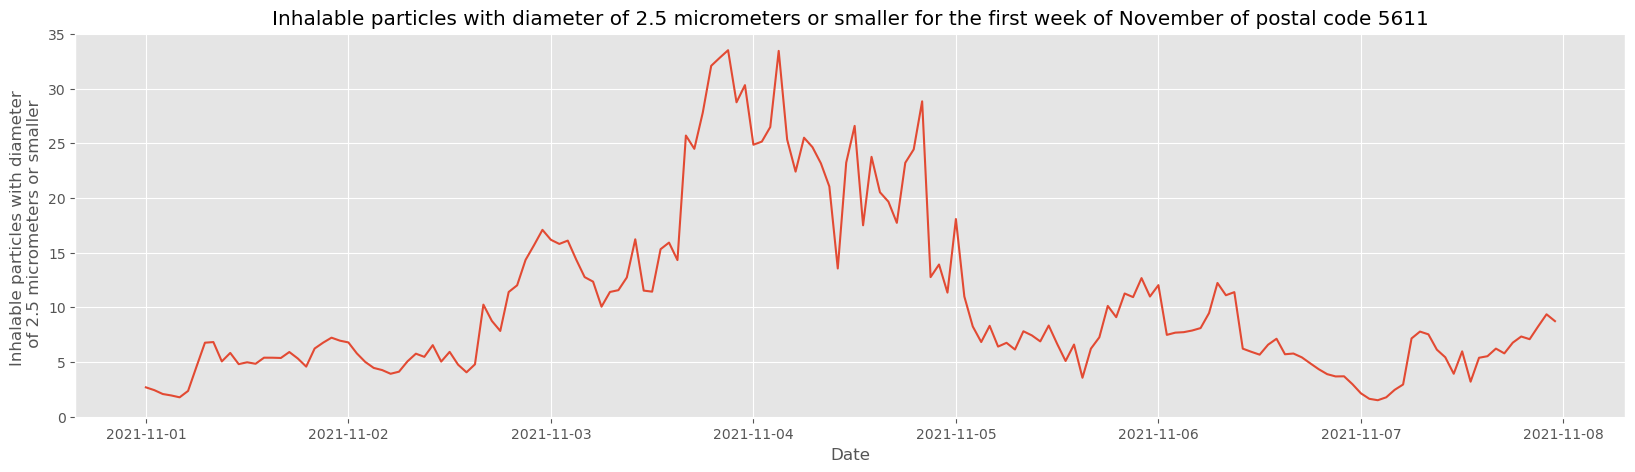

In [70]:
plt.figure(figsize = (20 ,5))

plt.plot(one_week_postalcode_df_meteo_air_polution['date'], one_week_postalcode_df_meteo_air_polution['pm2.5'])
 
# Adding Title to the Plot
plt.title('Inhalable particles with diameter of 2.5 micrometers or smaller for the first week of November of postal code 5611')

# Setting the X and Y labels
plt.xlabel('Date')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller')
  
plt.show()

In the graph above the particulate matter of 2.5 micrometer or smaller is visualized for the first week of November. You can see that almost every night the particals are lower then during the day. It is hard to see peaks in PM2.5 during the day but you can see a clearly difference between the particals at night and day. 

<h4><font color=mediumvioletred>Conclusion</font></h4>

After exploring and visualising the combined meteo- and pollution data, we came to the conclusion that the boundary layer height, the windspeed, the nitrogen dioxide in ug/m3, and the solar surface radiation downwards had the most corrolation on the PM2.5 values. Since this is the most important measurement of the pollution data, we devided that moving forward we are going to use this data in the air pollution prediction tool.

<h3><font color=steelblue>Air pollution dataset</font></h3>

<h4><font color=mediumvioletred>Read CSV files</font></h4>

In [71]:
df_ap_np = pd.read_csv('data/air_pollution.csv')
df_ap = pd.read_csv("data/air_pollution.csv", parse_dates=["date"])
df_ap_per_date_per_postalcode = df_ap.groupby([pd.Grouper(freq='D', key='date'),
                     'PC4']).mean()

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..)</font></h4>

In [72]:
df_ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76824 entries, 0 to 76823
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    76824 non-null  datetime64[ns]
 1   PC4     76824 non-null  int64         
 2   pm10    76824 non-null  float64       
 3   pm2.5   76824 non-null  float64       
 4   no2     76824 non-null  float64       
 5   no      76824 non-null  float64       
 6   so2     76824 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.1 MB


<h4><font color=mediumvioletred>Get the generate descriptive statistics of the columns</font></h4>

In [73]:
df_ap.describe()

PC4          pm10         pm2.5           no2            no  \
count  76824.000000  76824.000000  76824.000000  76824.000000  76824.000000   
mean    5633.818182     19.300461     19.306449     25.810896     14.578421   
std       15.168756     12.790363     19.325968     13.715641     12.749047   
min     5611.000000      0.491714      0.419603      1.665652      0.000398   
25%     5622.000000      9.789488      5.986320     14.671372      4.785573   
50%     5631.000000     16.246310     12.186803     23.211536     12.002913   
75%     5646.000000     26.378854     26.603072     35.263642     22.173757   
max     5658.000000     89.593300    144.709400     79.853535    145.954814   

                so2  
count  76824.000000  
mean       3.419556  
std        3.060791  
min        0.000000  
25%        1.330161  
50%        2.583675  
75%        4.383727  
max       26.323172

<h4><font color=mediumvioletred>Testing for Normality</font></h4>

Skewness per column:
PC4      0.133642
pm10     1.312018
pm2.5    2.101590
no2      0.621710
no       1.845079
so2      2.078176
dtype: float64


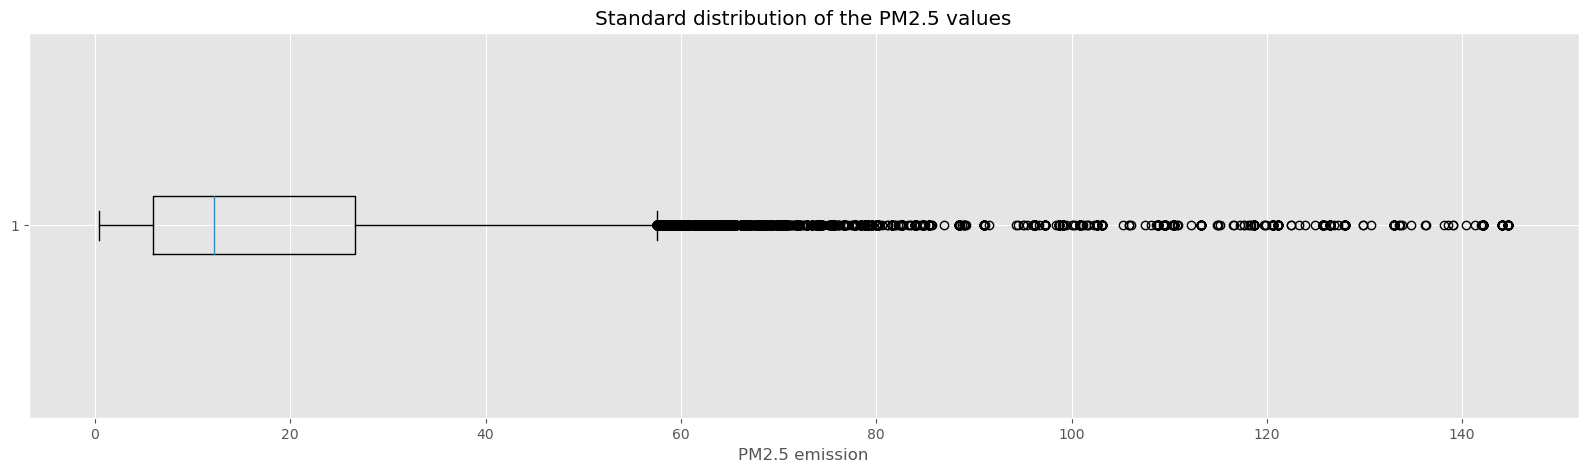

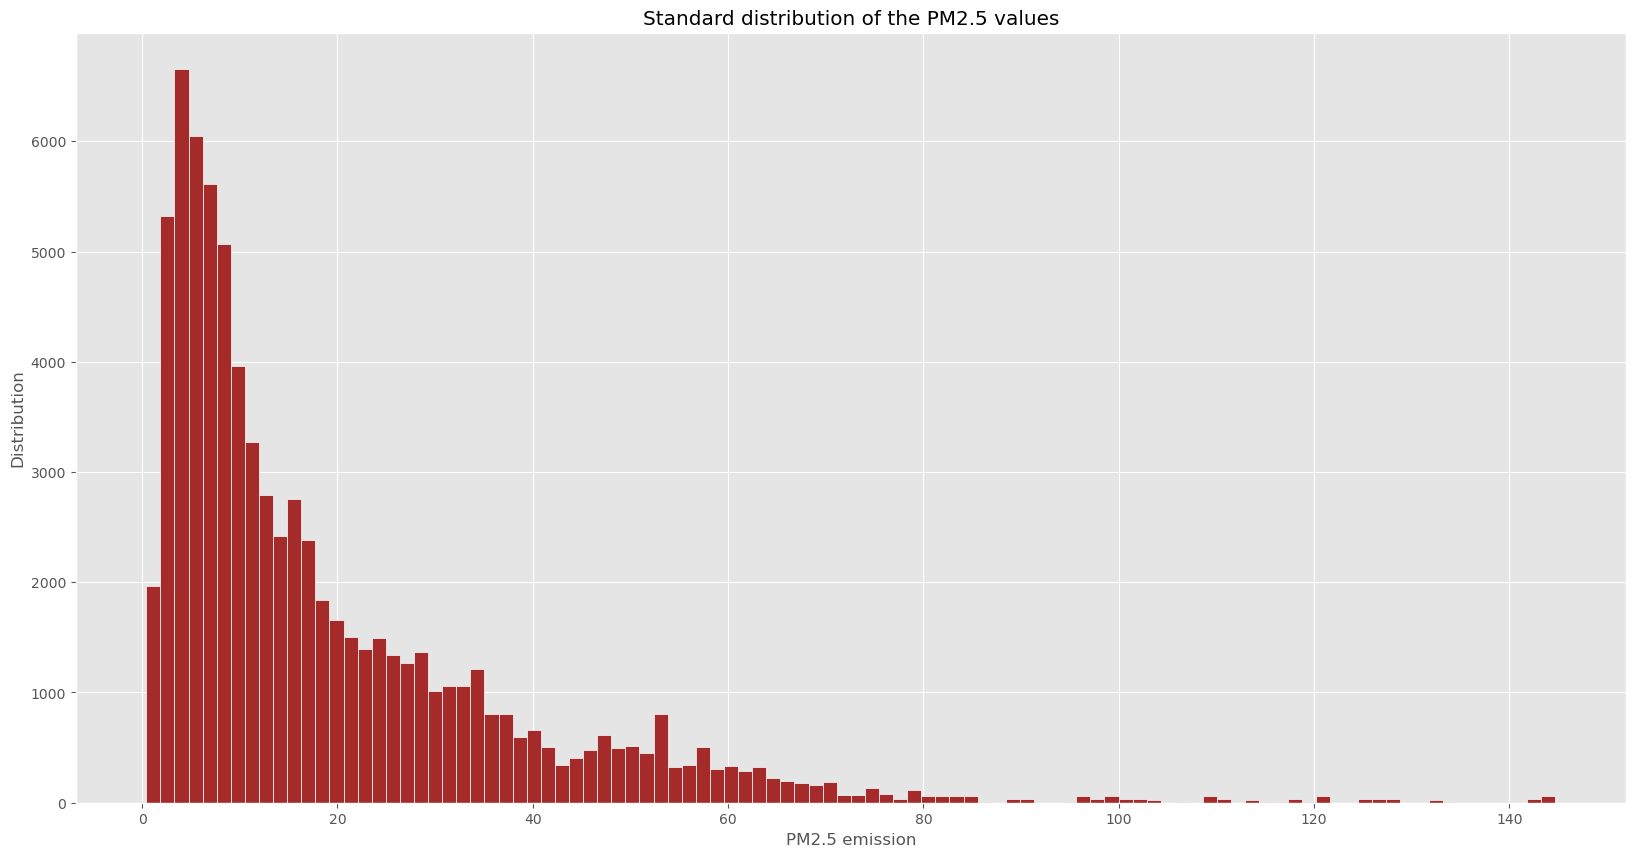

In [74]:
print("Skewness per column:")
print(df_ap.skew(numeric_only=True))

plt.figure(figsize=(20,5))
plt.boxplot( df_ap['pm2.5'], vert=False)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_ap['pm2.5'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.ylabel("Distribution")
plt.show()

Most skewed data in the dataset is the PM2.5 data.<br>
There is a peak of 144 at the end of the tail. This could imply that anomalies exist in the data.<br>
These number values are unexpectedly high compared to what would be normal.<br> 

These anomalies could cause malfunctions in future model(s). Action could be taken to minimize the effect of these anomalies.

<h4><font color=mediumvioletred>Correlations in the dataset - Correlation matrix</font></h4>

In [75]:
df_ap.corr()

C:\Users\rawan\AppData\Local\Temp\ipykernel_36828\3091418668.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



PC4      pm10     pm2.5       no2        no       so2
PC4    1.000000 -0.022215 -0.015463 -0.032789 -0.024208 -0.000279
pm10  -0.022215  1.000000  0.842424  0.443763  0.419273  0.354938
pm2.5 -0.015463  0.842424  1.000000  0.252095  0.178604  0.162552
no2   -0.032789  0.443763  0.252095  1.000000  0.674611  0.362617
no    -0.024208  0.419273  0.178604  0.674611  1.000000  0.309740
so2   -0.000279  0.354938  0.162552  0.362617  0.309740  1.000000

PM2.5 column is deeply correlated with the PM10 column.

<h4><font color=mediumvioletred>Correlations in the dataset - Testing different correlation functions on PM2.5 column</font></h4>

In [76]:
print('Pearson: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='pearson')))
print('Spearman: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='spearman')))


Pearson: 0.8424240709438275
Spearman: 0.8868444860412877


The two column excibit a high relationship both linearly and monotonically.

<h4><font color=mediumvioletred>Correlations in the dataset - Plotting the correlation between the PM10 and the PM2.5 columns</font></h4>

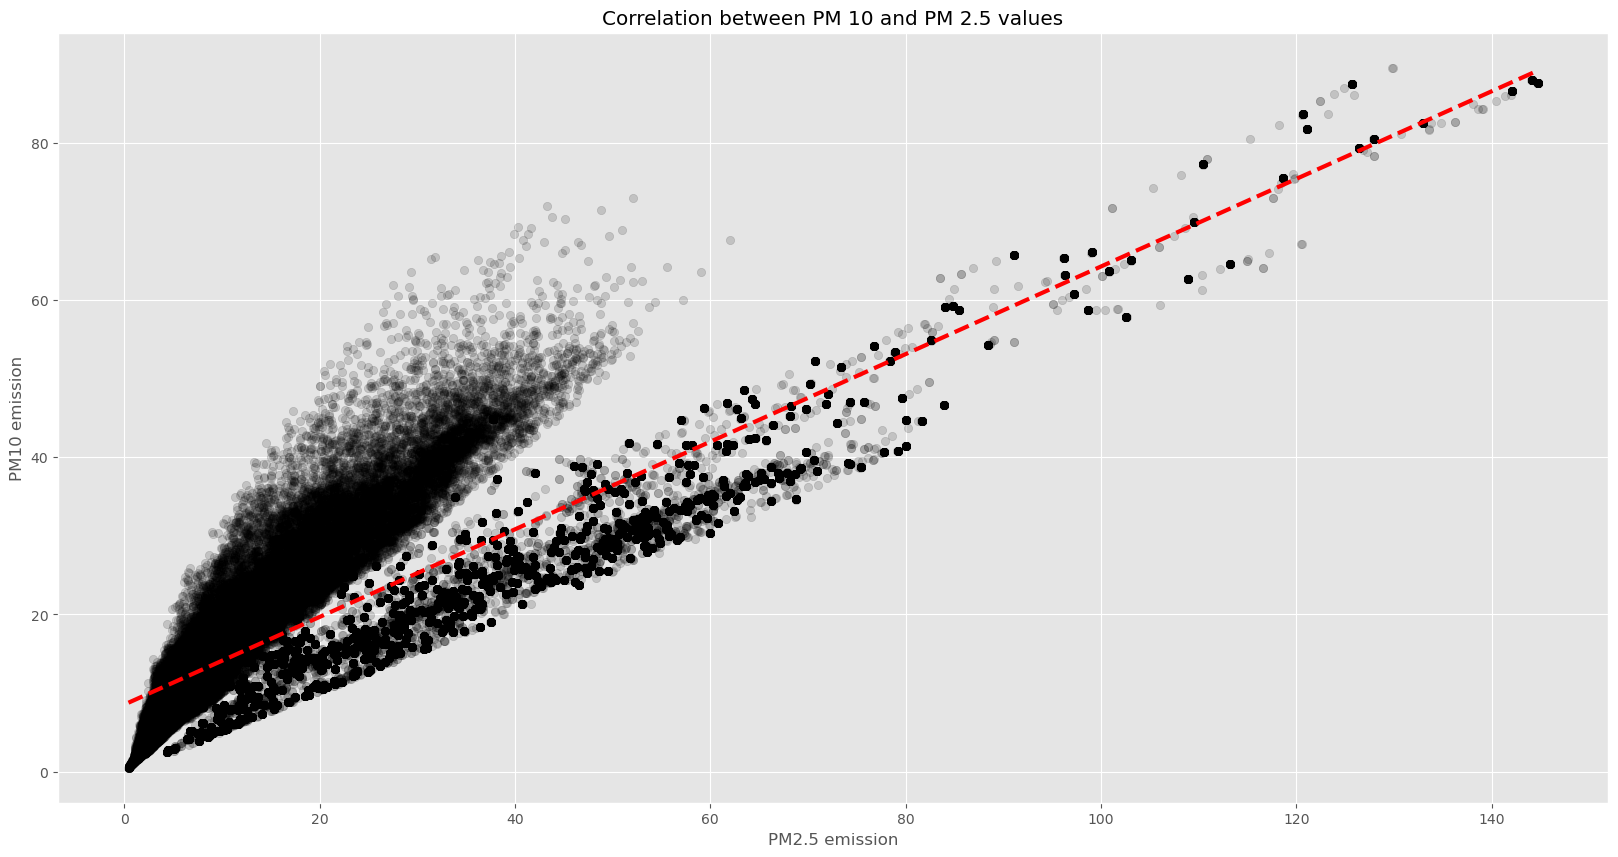

In [77]:
plt.figure(figsize=(20,10))
plt.scatter(df_ap["pm2.5"], df_ap["pm10"], alpha=.15, color='black')
plt.plot(np.unique(df_ap["pm2.5"]), np.poly1d(np.polyfit(df_ap["pm2.5"], df_ap["pm10"], 1))
         (np.unique(df_ap["pm2.5"])), color='red', linewidth=3, linestyle='dashed')
plt.xlabel('PM2.5 emission')
plt.ylabel('PM10 emission')
plt.title("Correlation between PM 10 and PM 2.5 values")
plt.show()

PM2.5 emission is deeply correlated with the PM10 emission.

<h4><font color=mediumvioletred>PM2.5 values - Daily average(mean) </font></h4>

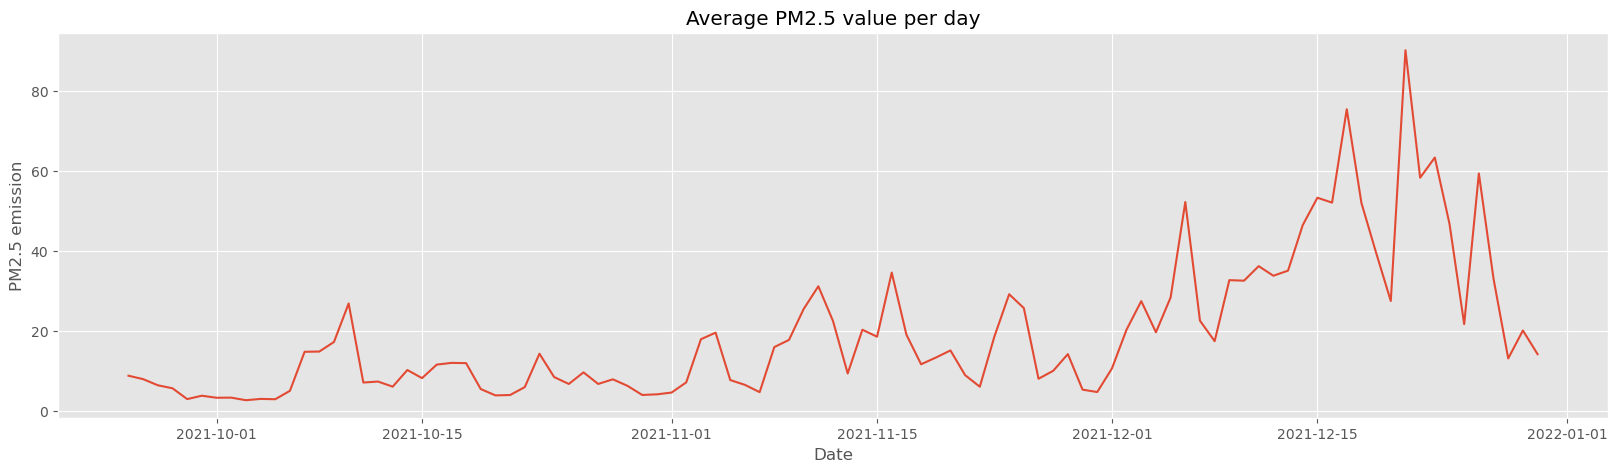

In [78]:
df_ap_day_mean = df_ap.groupby(pd.Grouper(freq='D', key='date')).mean()
plt.figure(figsize=(20,5))
plt.title("Average PM2.5 value per day")
plt.plot(df_ap_day_mean['pm2.5'])
plt.xlabel("Date")
plt.ylabel("PM2.5 emission")
plt.show()

The daily PM2.5 pollution is very high during the Holiday season. 

<h4><font color=mediumvioletred> Worst mean total pollution in different postal code areas</font></h4>

In [79]:
df_ap_sp = df_ap.groupby(['PC4']).mean(numeric_only=True)
print('Most populated areas with the pollution type:')
df_ap_sp = df_ap_sp.drop_duplicates()
df_ap_sp.reset_index().style.highlight_max(color = 'orange')

Most populated areas with the pollution type:


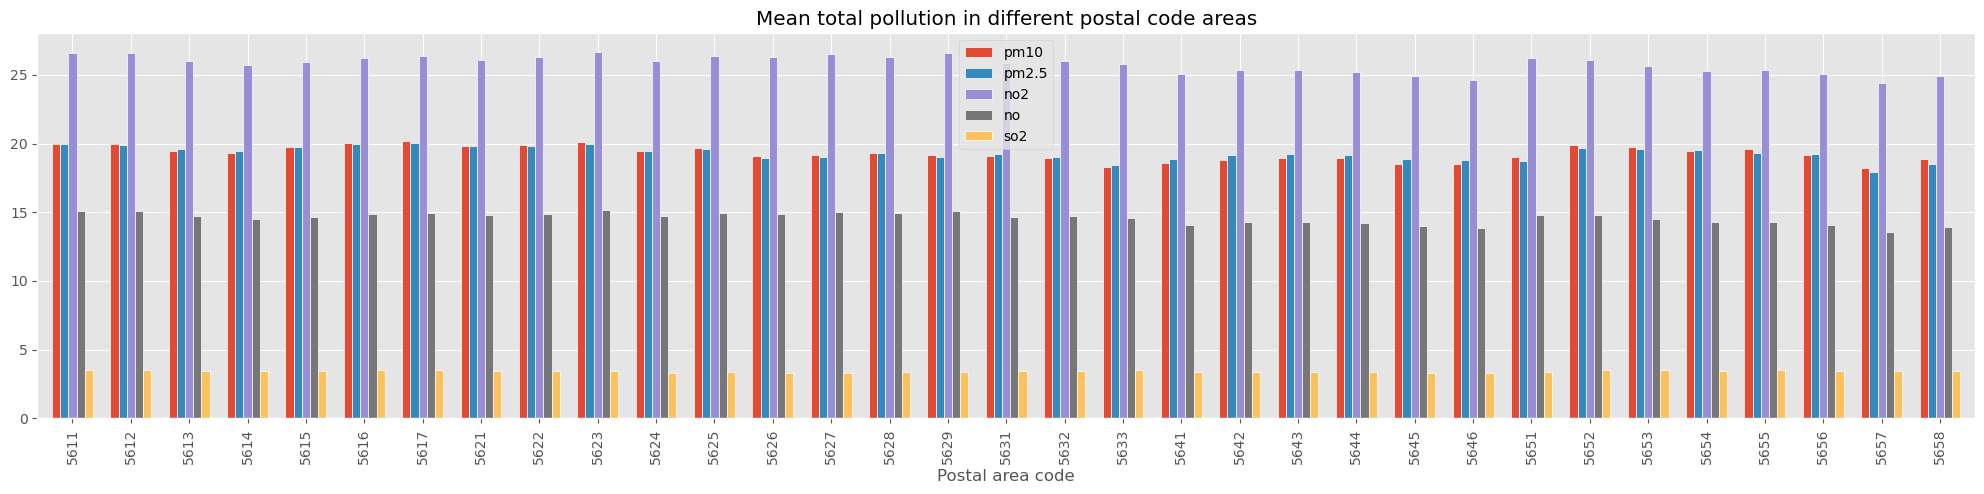

In [80]:
plot = df_ap_sp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Mean total pollution in different postal code areas")

There is a limited difference in air pollution between the different postal codes in Eindhoven.

<h4><font color=mediumvioletred> Most peak pollution in different postal code areas</font></h4>

In [81]:
df_ap_mp = df_ap.groupby(['PC4']).max(numeric_only=True)
print('Most polluted areas per pollution type:')
#Only grabs the first value, or none
print(df_ap_mp.idxmax())
df_ap_mp = df_ap_mp.drop_duplicates()
df_ap_mp.reset_index().style.highlight_max(color = 'orange')

Most polluted areas per pollution type:
pm10     5658
pm2.5    5611
no2      5658
no       5658
so2      5625
dtype: int64


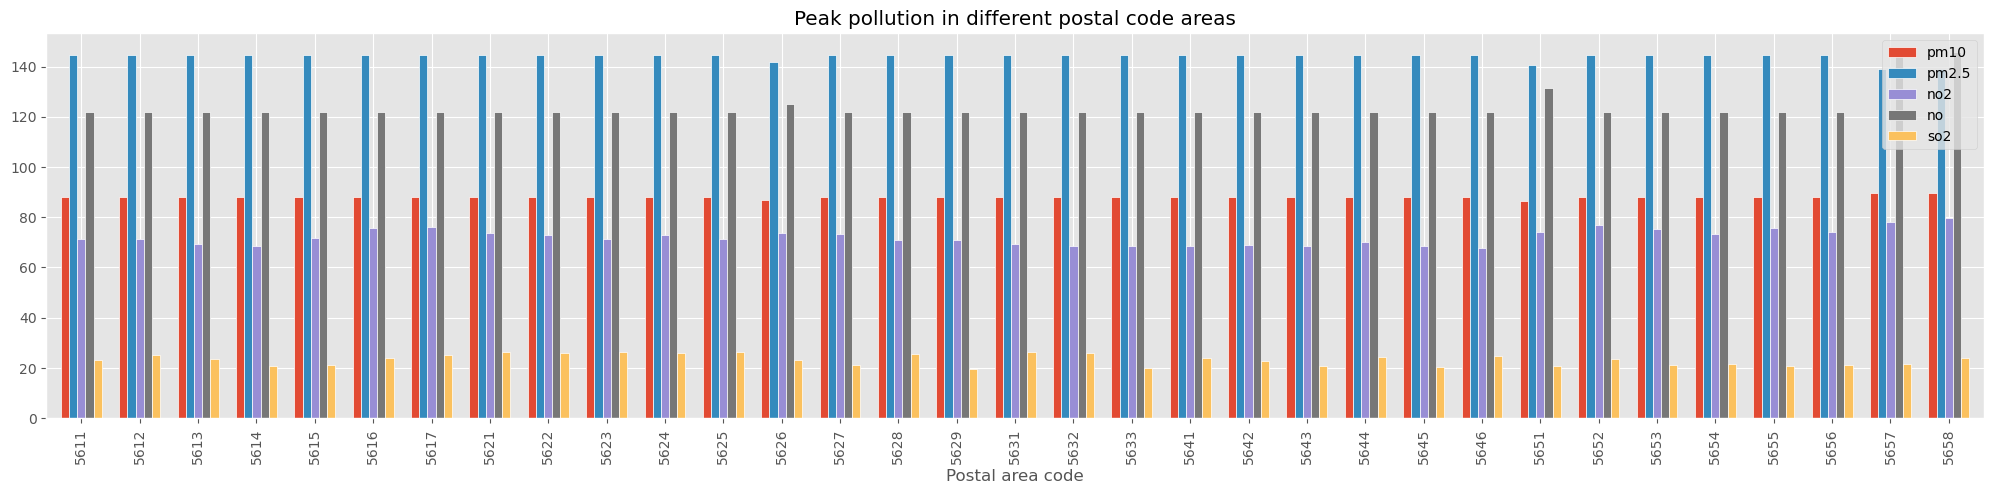

In [82]:
plot = df_ap_mp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Peak pollution in different postal code areas")

There is a limited difference in air pollution between the different postal codes in Eindhoven.

There are several instances of the PM2.5 pollution with the value of 144.709400.<br>
The PM2.5 sensor might be peaking, therefore, the taken measurement might be incorrect.

<h4><font color=mediumvioletred> Least pollution in different postal code areas</font></h4>

In [83]:
df_ap_lp = df_ap.groupby(['PC4']).min(numeric_only=True)

print('Least polluted areas per pollution type:')
#Only grabs the first value, or none
print(df_ap_lp.idxmin())

df_ap_lp = df_ap_lp.drop_duplicates()
df_ap_lp.reset_index().style.highlight_min(color = 'lightgreen')

Least polluted areas per pollution type:
pm10     5644
pm2.5    5644
no2      5646
no       5611
so2      5658
dtype: int64


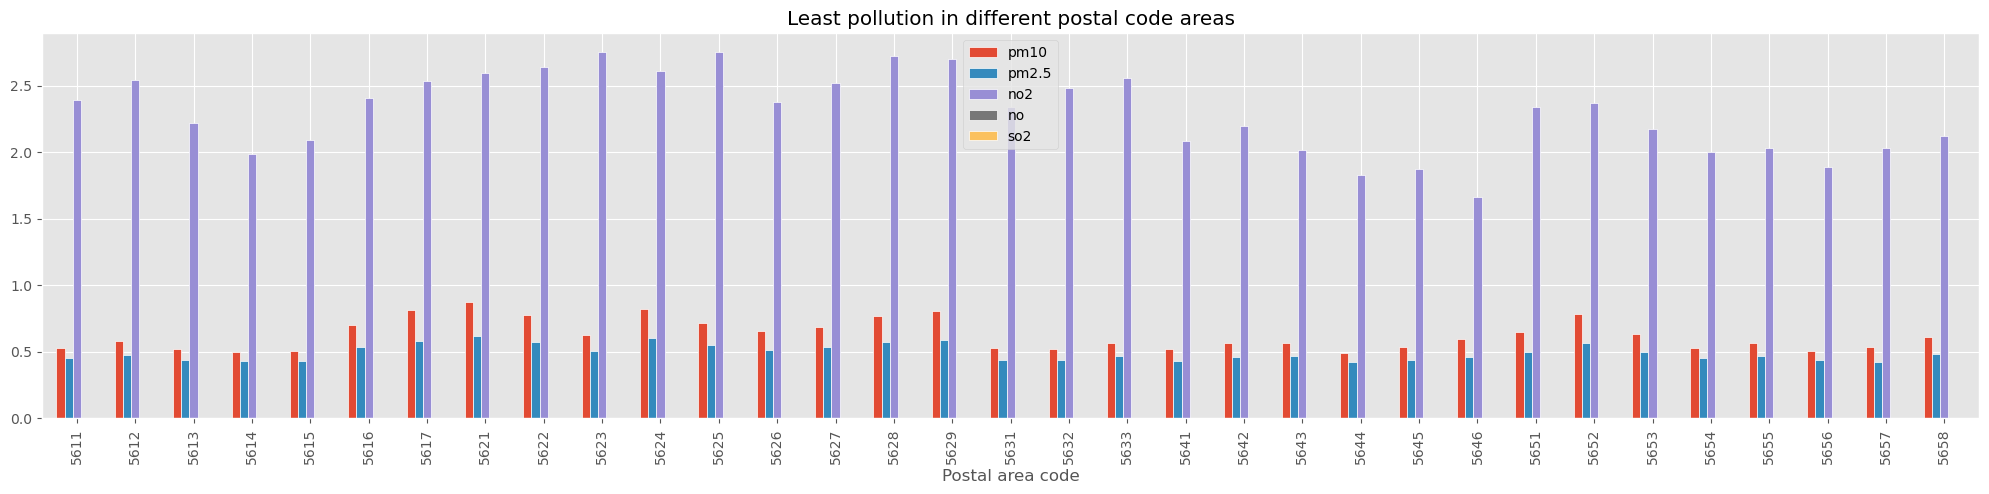

In [84]:
plot = df_ap_lp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Least pollution in different postal code areas")

There is a limited difference in air pollution between the different postal codes in Eindhoven.

The sulfur dioxide sensor is not always taking measurements.


<h4><font color=mediumvioletred>Comparing the most polluted postal code area (day mean) based on the pollution type with the same area on an average day</font></h4>

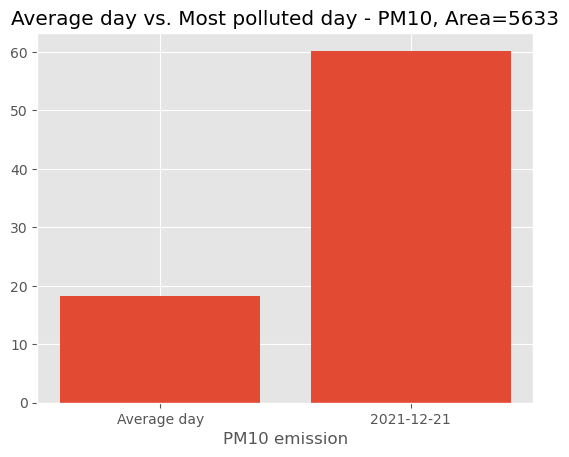

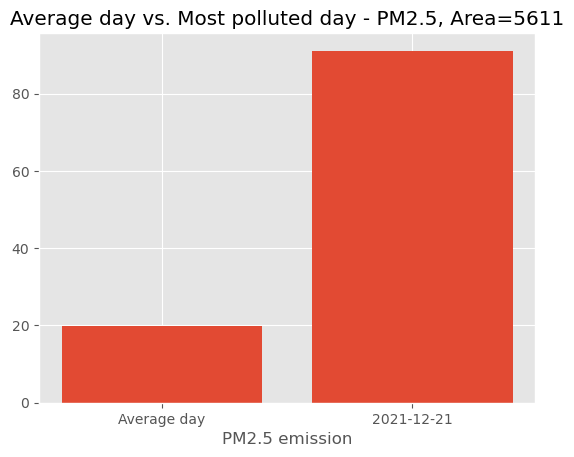

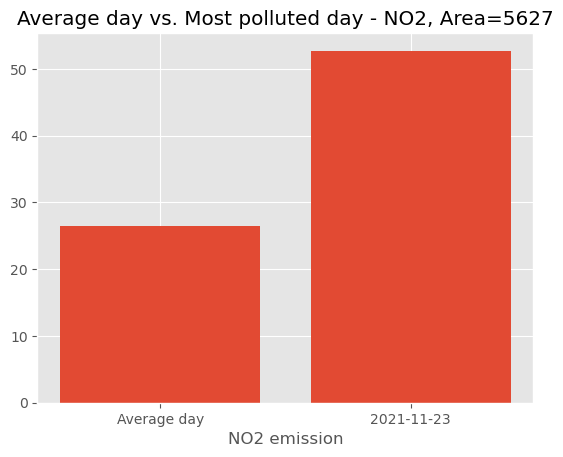

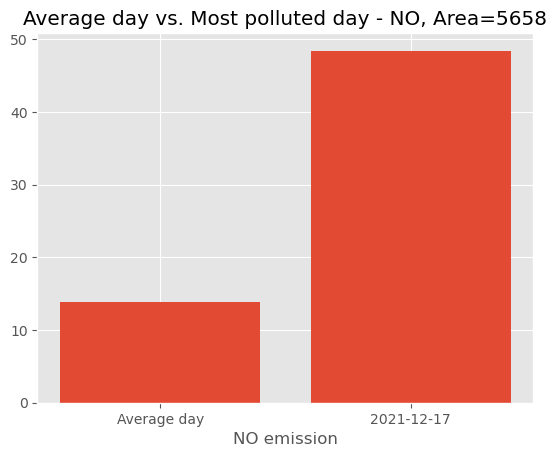

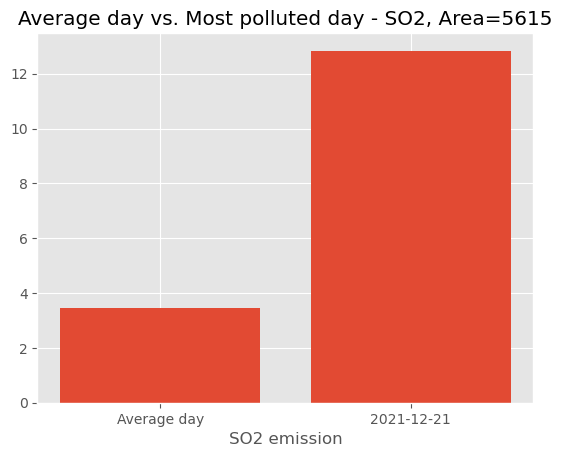

In [85]:
most_polluted_days = df_ap_per_date_per_postalcode.idxmax()

i = 0
for day in most_polluted_days:
    most_polluted_values = df_ap_per_date_per_postalcode.loc[(day[0] ,day[1]), :]
    all_for_postcode =  df_ap_per_date_per_postalcode.loc[(slice(None), day[1]), :]
    plt.bar(["Average day", str(day[0].date())], [all_for_postcode.mean()[most_polluted_days.index[i]], most_polluted_values.loc[most_polluted_days.index[i]]])
    plt.title("Average day vs. Most polluted day - " + str(most_polluted_days.index[i]).upper() + ", Area=" + str(day[1]) )
    plt.xlabel(str(most_polluted_days.index[i]).upper() + " emission")
    plt.show()
    i += 1

<h4><font color=mediumvioletred>Comparing the least polluted postal code area (day mean) based on the pollution type with the same area on an average day</font></h4>

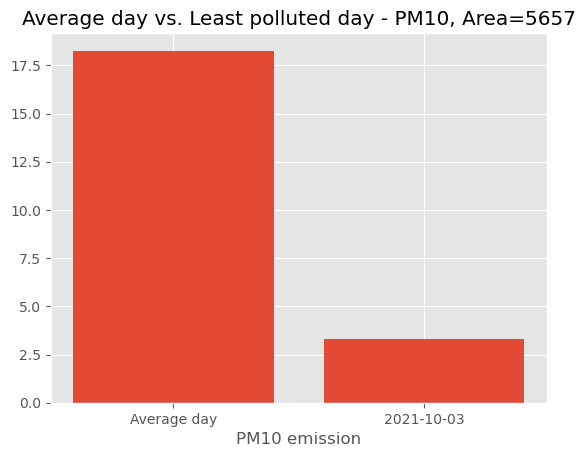

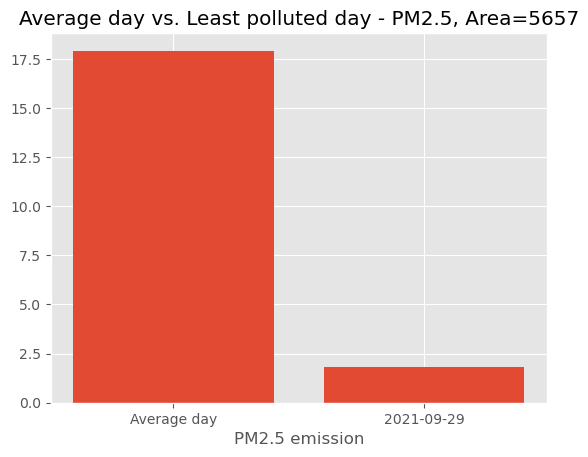

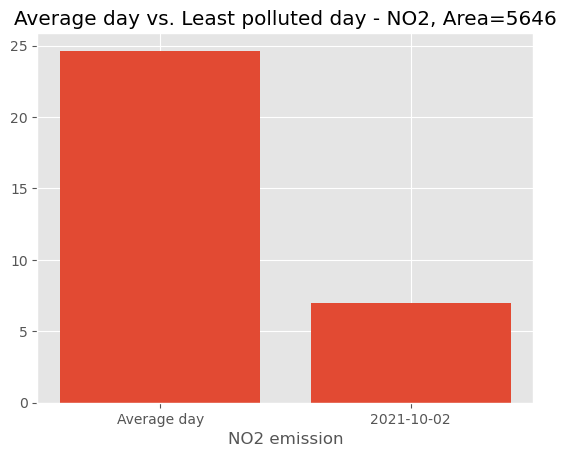

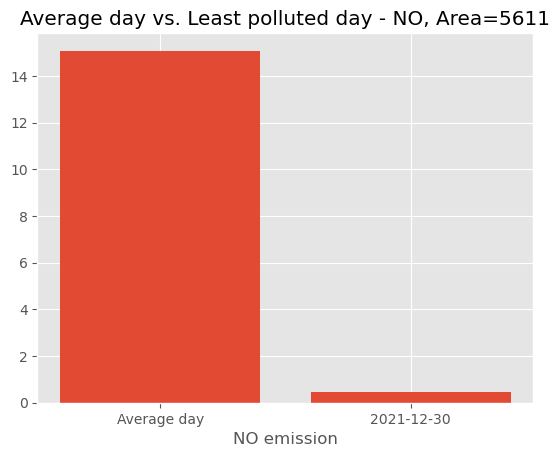

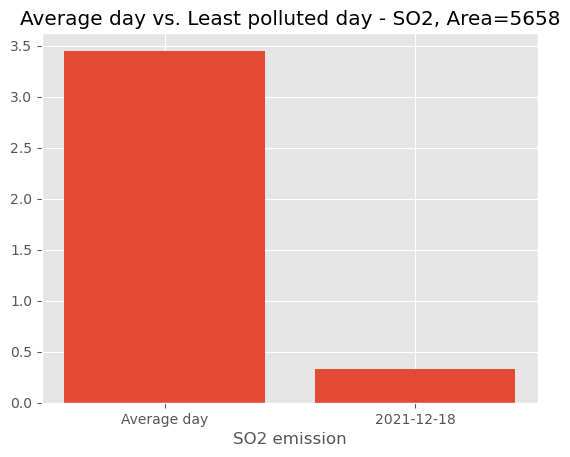

In [86]:
least_polluted_days = df_ap_per_date_per_postalcode.idxmin()

i = 0
for day in least_polluted_days:
    least_polluted_values = df_ap_per_date_per_postalcode.loc[(day[0] ,day[1]), :]
    all_for_postcode =  df_ap_per_date_per_postalcode.loc[(slice(None), day[1]), :]
    plt.bar(["Average day", str(day[0].date())], [all_for_postcode.mean()[least_polluted_days.index[i]], least_polluted_values.loc[least_polluted_days.index[i]]])
    plt.title("Average day vs. Least polluted day - " + str(least_polluted_days.index[i]).upper() + ", Area=" + str(day[1]) )
    plt.xlabel(str(least_polluted_days.index[i]).upper() + " emission")
    plt.show()
    i += 1

<h4><font color=mediumvioletred>A deeper look at the most polluted day in the most polluted area - PM2.5</font></h4>

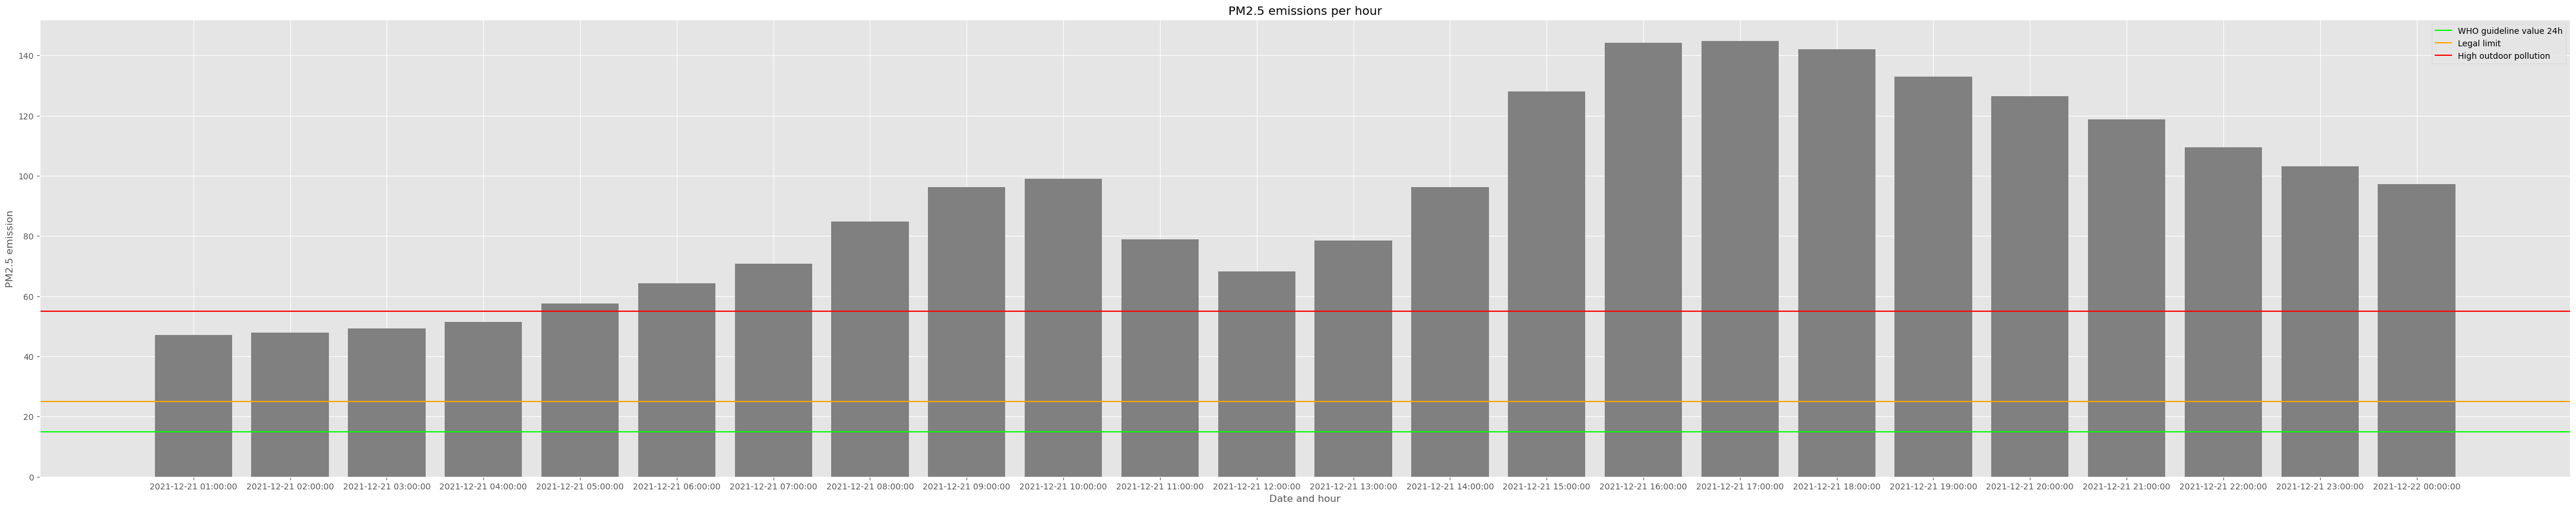

In [87]:
# DOUBLE CLICK ON THE GRAPH TO ZOOM IN #

most_polluted = df_ap_per_date_per_postalcode.idxmax()['pm2.5']
most_polluted_date = most_polluted[0].date() 
most_polluted_areacode = most_polluted[1]

START_DATE =  str(most_polluted_date + timedelta(days=-0))
END_DATE = str(most_polluted_date + timedelta(days=+1))

FIG_HEIGHT = 10
FIG_WIDTH = 55

mask = ((df_ap['date'] > START_DATE) & (df_ap['date'] <= END_DATE) & (df_ap['PC4'] <= most_polluted_areacode))
air_pollution = df_ap_np.loc[mask]

f = plt.figure()
f.set_figheight(FIG_HEIGHT)
f.set_figwidth(FIG_WIDTH)
plt.bar(air_pollution['date'], air_pollution['pm2.5'], color='gray')
plt.title("PM2.5 emissions per hour")
plt.xlabel("Date and hour")
plt.ylabel("PM2.5 emission")

healthy_level = [15]
legal_limit = [25]
unhealthy_level = [55]

plt.axhline(y = healthy_level, color = '#00FF00', linestyle = '-')
plt.axhline(y = legal_limit, color = '#FFA500', linestyle = '-')
plt.axhline(y = unhealthy_level, color = '#FF0000', linestyle = '-')
plt.legend(['WHO guideline value 24h', 'Legal limit', 'High outdoor pollution '])
plt.show()

The PM2.5 emission on the 21st of December 2021 for the postal code 5611 exceeds the daily Dutch legal limit for air pollution.<br>
However, the project group could not find a precise cause for the excessively high pollution.<br>
The project group speculates that it is caused by people travelling for Christmas related activities.<br> 

Sources for the limits <br>
Safe Limit: https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health<br>
Legal limit: https://www.indoorairhygiene.org/pm2-5-explained/ <br>
Unhealthy limit: https://smartairfilters.com/en/blog/difference-pm2-5-aqi-measurements/<br>

<h4><font color=mediumvioletred>The average emission for each selected postal code on selected days</font></h4>

In [88]:
df_heat = df_ap_np
# START_DATE =  '2021-09-25'
# END_DATE = '2021-12-31'
# PCODES = [5611, 5626, 5644, 5654, 5658]

# Select rows between start and end date for each postal code
# mask = ((df_heat['date'] > START_DATE) & (df_heat['date'] <= END_DATE))
# df_heat = df_heat.loc[mask]
# df_heat = df_heat.loc[df_heat['PC4'].isin(PCODES)]

# Group by postal code and group by day
df_heat['date'] = pd.to_datetime(df_heat['date'], format='%Y/%m/%d %H:%M:%S')
gr_by_pc4_day = df_heat.groupby(['PC4', df_heat['date'].dt.date]).mean()
print(gr_by_pc4_day)

                      pm10      pm2.5        no2         no       so2
PC4  date                                                            
5611 2021-09-25  16.089859   9.163063  27.160785  17.770088  2.539185
     2021-09-26  17.376689   8.106905  22.998390  15.046819  3.112883
     2021-09-27  11.256416   6.647947  15.691083  10.265974  2.075364
     2021-09-28  11.465175   5.887269  19.930236  13.039463  4.820231
     2021-09-29   6.452490   3.480847  20.465527  13.389680  2.821472
...                    ...        ...        ...        ...       ...
5658 2021-12-26  34.075700  59.589269  32.221544   2.907209  5.245878
     2021-12-27  17.820076  30.528690  21.651155   3.583641  1.487095
     2021-12-28   8.948837  12.570214  16.046669   2.498485  1.538497
     2021-12-29  14.963136  19.360596  20.753625  11.117488  2.826996
     2021-12-30  12.269858  12.880553  12.753498   0.475372  1.749335

[3201 rows x 5 columns]


C:\Users\rawan\AppData\Local\Temp\ipykernel_36828\1328095555.py:13: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<h4><font color=mediumvioletred>Heatmap of the average emission for each selected postal code on selected days</font></h4>

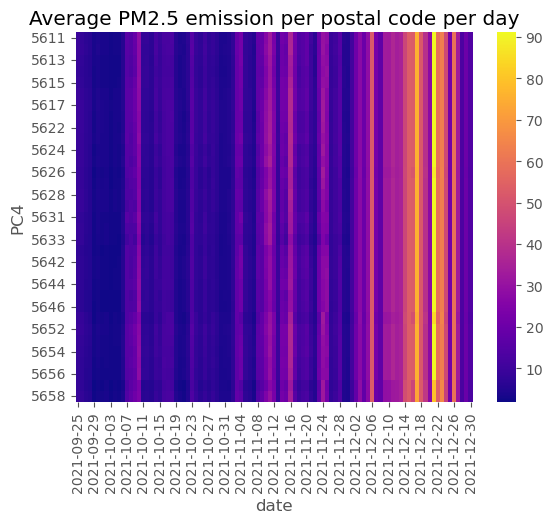

In [89]:
# Pivot the dataframe from long to wide form
heat = pd.pivot_table(gr_by_pc4_day, index='PC4', columns='date', values='pm2.5')

ax = plt.axes()
sns.heatmap(heat, annot=False, cmap='plasma', ax = ax)
ax.set_title('Average PM2.5 emission per postal code per day')
plt.show()



There is a limited difference in air pollution between different postal codes in Eindhoven.<br>
The emission of air pollutants for the city of Eindhoven is higher in December in comparison to the previous months in the dataset.


<h4><font color=mediumvioletred>Conclusion</font></h4>

The emission of air pollutants is higher during the Holiday season. 
Furthermore, there is little difference of the emission of air pollutants between postal codes in Eindhoven.
Anomalies exist in the dataset, which could lead to the malfunctioning of future model(s) based on this dataset.
Steps should be taken to minimize the risk associated with these anomalies. 

<h2><font color=slateblue> 5. Data Preparation </font></h2>

To prepare the data for the modelling process, the following steps must be taken:
1. Combine the three tables.
2. Calculate number of people per hour, for each row count (m00_30 + m30_60).
3. Separate date and time.
4. Group areas and days.
5. Extract date information day, month, year, day_of_week and day_of_year.
6. Calculate number of people per day, average per day for pm2.5, wind direction, wind speed, sun radiation, boundary layer height.
7. Handle empty values.
8. Remove/handle outliers in pm2.5.
 
The needed columns for modelling are: date (day, month, year), day_of_week, day_of_year, zipcode, average pm2.5, number of people, wind direction, wind speed, sun radiation, boundary layer height.

<h4><font color=mediumvioletred>Read the three datasets</font></h4>

In [90]:
# read zichtop dataset csv file
df_zichtop = pd.read_csv("data/zichtop.csv", 
                    parse_dates=["date"])

# read air_pollution dataset csv file
df_air_pollution = pd.read_csv("data/air_pollution.csv",
                    parse_dates=["date"])

# read meteo dataset csv file
df_meteo = pd.read_csv("data/meteo.csv",
                    parse_dates=["date"])

<h4><font color=mediumvioletred>Merge zichtop and air_pollution datasets</font></h4>

In [91]:
df_merged = pd.merge(df_zichtop[["PC4", "date", "m00_30", "m30_60"]], 
                     df_air_pollution[["PC4","date", "pm2.5"]], 
                     on=["PC4", "date"])

<h4><font color=mediumvioletred>Merge the previous result with meteo dataset</font></h4>

In [92]:
df_merged = pd.merge(df_merged[["PC4", "date", "m00_30", "m30_60", "pm2.5"]], 
                     df_meteo[["PC4","date", "wd", "ws", "ssrd", "blh"]], 
                     on=["PC4", "date"])

<h4><font color=mediumvioletred>Get a sample of the merged datasets</font></h4>

In [93]:
df_merged.sample(5)

PC4                date  m00_30  m30_60      pm2.5          wd  \
30733  5645 2021-10-10 13:00:00   198.0    18.0  20.814430  132.205627   
22703  5632 2021-10-05 23:00:00    65.0     0.0   2.518607  230.971008   
18755  5628 2021-10-06 11:00:00   568.0   111.0   5.025084  201.847397   
8326   5617 2021-10-11 22:00:00     0.0     0.0   8.768466  168.560669   
8810   5617 2021-11-01 02:00:00     0.0     0.0   2.471784  248.369217   

             ws        ssrd         blh  
30733  2.231533  473.698785  810.639038  
22703  5.919572    0.000000  797.754517  
18755  6.238843  225.041233  901.642212  
8326   2.703506    0.000000  236.250412  
8810   5.766476    0.000000  736.964661

<h4><font color=mediumvioletred>Calculate number of people per hour</font></h4>

In [94]:
df_merged["people_number"] = df_merged["m00_30"] + df_merged["m30_60"]
df_merged.sample(5)

PC4                date  m00_30  m30_60      pm2.5          wd  \
33491  5651 2021-10-15 11:00:00  1953.0   284.0   4.844388   93.730743   
38516  5655 2021-10-04 20:00:00    85.0     0.0   4.611939  276.527252   
28810  5643 2021-11-09 10:00:00   268.0    60.0  12.438796  263.085052   
39432  5655 2021-11-12 00:00:00    35.0     0.0  31.013462  295.647034   
11609  5622 2021-11-07 17:00:00   230.0    30.0   4.959540  175.408066   

             ws        ssrd         blh  people_number  
33491  2.594768  195.989306  896.384094         2237.0  
38516  4.329328    0.000000  448.696350           85.0  
28810  3.444359  163.704010  285.739716          328.0  
39432  1.697070    0.000000   75.531570           35.0  
11609  4.967470    0.000000  686.346985          260.0

<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [95]:
df_merged.rename(columns={"date": "date_time"}, inplace=True)
df_merged.sample(5)

PC4           date_time  m00_30  m30_60      pm2.5          wd  \
16185  5626 2021-10-09 09:00:00  1067.0   107.0  15.075587  358.035461   
11097  5622 2021-10-17 09:00:00   249.0     0.0  14.076631  256.503723   
39134  5655 2021-10-30 14:00:00   464.0     0.0   2.781477  272.166779   
23719  5632 2021-11-17 07:00:00   543.0    44.0  36.228184  235.208618   
5328   5615 2021-09-27 00:00:00     0.0     0.0   7.816598  244.117538   

             ws        ssrd         blh  people_number  
16185  2.637476  305.636944  291.301331         1174.0  
11097  3.055970  180.854983  265.853455          249.0  
39134  7.119921  145.673559  931.024048          464.0  
23719  3.989261    0.000000  293.454010          587.0  
5328   3.855427    0.000000  338.579468            0.0

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [96]:
df_merged["date"] = df_merged["date_time"].dt.date.astype(str)
df_merged["time"] = df_merged["date_time"].dt.time.astype(str)

<h4><font color=mediumvioletred>Drop unneeded columns</font></h4>

In [97]:
df_merged.drop(["m00_30", "m30_60", "date_time"], axis=1, inplace=True)

<h4><font color=mediumvioletred>Get a sample of the merged datasets</font></h4>

In [98]:
df_merged.sample(5)

PC4      pm2.5          wd        ws        ssrd         blh  \
22927  5632   8.872566  188.643234  4.838097    4.669967  675.334717   
27138  5642   7.917087  240.012756  3.891426    0.000000  526.098999   
8987   5617   8.149354  200.996826  2.870674  178.535503  367.153015   
3546   5613   5.257558  249.360306  4.293533    0.000000  641.673889   
11852  5622  12.785354  201.912231  3.294689    0.000000  174.352936   

       people_number        date      time  
22927          386.0  2021-10-15  07:00:00  
27138          524.0  2021-10-25  18:00:00  
8987           751.0  2021-11-08  11:00:00  
3546           413.0  2021-11-01  18:00:00  
11852           59.0  2021-11-17  20:00:00

<h4><font color=mediumvioletred>Group wind directions</font></h4> 

In [99]:
def degToCompassNumerical(num):
    val=int((num/22.5)+.5)

    return (val % 16)

df_merged['wd_group'] = df_merged.apply(lambda row: degToCompassNumerical(row.wd), axis=1)
df_merged.sample(5)

PC4      pm2.5          wd        ws        ssrd          blh  \
20753  5629  22.720188   95.322723  1.623222    0.005198   207.537445   
17850  5627  17.739412  284.503906  2.073915    0.000000   106.912285   
28710  5643   6.310576  190.878067  2.639894    0.000000    86.294167   
13156  5623  16.862942  236.367065  3.586399    0.000000   269.943634   
26436  5642   3.053482  233.392303  2.581907  397.310799  1061.125244   

       people_number        date      time  wd_group  
20753          445.0  2021-11-03  17:00:00         4  
17850          405.0  2021-10-23  18:00:00        13  
28710          253.0  2021-11-05  06:00:00         8  
13156           45.0  2021-11-17  04:00:00        11  
26436          441.0  2021-09-26  12:00:00        10

wd_group meaning which direction
0=N, 1=NNE, 2=NE, 3=ENE, 4=E, 5=ESE, 6=SE, 7=SSE, 8=S, 9=SSW, 10=SW, 11=WSW, 12=W, 13=WNW, 14=NW, 15=NNW

<h4><font color=mediumvioletred>Checking for empty values</font></h4>

In [100]:
df_merged.isnull().sum()

PC4               0
pm2.5             0
wd                0
ws                0
ssrd              0
blh               0
people_number    23
date              0
time              0
wd_group          0
dtype: int64

<h4><font color=mediumvioletred>Showing all NaN rows within the people_number column</font></h4> 

In [101]:
df_ppl_nmbr_null = df_merged[df_merged['people_number'].isnull()]
df_ppl_nmbr_null = df_ppl_nmbr_null[["PC4", "date", "people_number", "time"]]
print(df_ppl_nmbr_null)

        PC4        date  people_number      time
8016   5617  2021-09-29            NaN  00:00:00
8522   5617  2021-10-20            NaN  02:00:00
23880  5633  2021-09-30            NaN  00:00:00
23904  5633  2021-10-01            NaN  00:00:00
24025  5633  2021-10-06            NaN  01:00:00
24047  5633  2021-10-06            NaN  23:00:00
24048  5633  2021-10-07            NaN  00:00:00
24072  5633  2021-10-08            NaN  00:00:00
24096  5633  2021-10-09            NaN  00:00:00
24144  5633  2021-10-11            NaN  00:00:00
24145  5633  2021-10-11            NaN  01:00:00
24216  5633  2021-10-14            NaN  00:00:00
24240  5633  2021-10-15            NaN  00:00:00
24361  5633  2021-10-20            NaN  01:00:00
24384  5633  2021-10-21            NaN  00:00:00
24409  5633  2021-10-22            NaN  01:00:00
24504  5633  2021-10-26            NaN  00:00:00
24720  5633  2021-11-04            NaN  00:00:00
24800  5633  2021-11-07            NaN  08:00:00
39671  5656  2021-09

<h4><font color=mediumvioletred>Interpolating missing rows within the people_number column</font></h4> 

In [102]:
df_merged = df_merged.interpolate(method='linear', axis=0).bfill()

The NaN rows within people_number are interpolated.

<h4><font color=mediumvioletred>Showing NaN rows within dataset</font></h4> 

In [103]:
df_merged.isnull().sum()

PC4              0
pm2.5            0
wd               0
ws               0
ssrd             0
blh              0
people_number    0
date             0
time             0
wd_group         0
dtype: int64

The result of interpolating. There are no NaN rows within the dataset.

<h4><font color=mediumvioletred>
Dataset grouped by postal code and date</font></h4>

In [104]:
df_merged_grouped = df_merged.groupby(["PC4", "date"]).agg({"pm2.5": "mean", "wd": "mean", "ws": "mean", "ssrd": "mean", "blh": "mean", "people_number": "sum"}).reset_index()
df_merged_grouped['wd_group'] = df_merged_grouped.apply(lambda row: degToCompassNumerical(row.wd), axis=1)
df_merged_grouped = df_merged_grouped.round(decimals=2)
df_merged_grouped.sample(10)

PC4        date  pm2.5      wd    ws    ssrd     blh  people_number  \
1020  5633  2021-10-25   6.73  248.89  3.80   29.73  374.62        12045.0   
723   5627  2021-10-03   2.48  226.99  4.84   17.12  703.99        11975.0   
132   5613  2021-10-17  11.65  259.64  2.47   67.74  214.90        11997.0   
478   5622  2021-11-02   7.31  245.28  2.70   35.42  293.54         6465.0   
937   5632  2021-09-27   6.15  248.28  4.29   76.45  575.87         8588.0   
480   5622  2021-11-04  19.86  175.59  1.96   40.89  115.31         6224.0   
989   5632  2021-11-18  11.53  218.65  4.46   46.55  422.86         6623.0   
1383  5651  2021-10-03   2.31  226.72  4.83   17.23  706.12        27286.0   
1378  5651  2021-09-28   5.41  264.71  3.56  123.14  538.74        19463.0   
1540  5654  2021-09-25   8.52  278.92  2.34   90.39  275.41         5970.0   

      wd_group  
1020        11  
723         10  
132         12  
478         11  
937         11  
480          8  
989         10  
1383        10  
1378        12  
1540        12

In [105]:
df_merged_grouped.dtypes

PC4                int64
date              object
pm2.5            float64
wd               float64
ws               float64
ssrd             float64
blh              float64
people_number    float64
wd_group           int64
dtype: object

<h4><font color=mediumvioletred>Create a method to extract date information</font></h4>

Since we saw a pattern in pm2.5 over different days of week, we decided to add a column that represents the day of the week.

Monday = 0,
Tuesday = 1,
Wednesday = 2,
Thursday = 3,
Friday = 4,
Saturday = 5,
Sunday = 6

We also seperated year, month and day so they can be used in the model.

The day_of_year column was added to track events and holidays as they are usually more busy and could have an impact on air quality.

Finally, we dropped the date column as it is no longer needed.

In [106]:
def extract_date_information(df):
    # convert date type to datetime     
    df["date"] = df["date"].astype("datetime64[ns]")
    
    # sort DataFrame in date order
    df.sort_values(by=["date"], inplace=True, ascending=True)
    
    # extract date info
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.day_of_week
    df["day_of_year"] = df["date"].dt.dayofyear

    # now we've enriched our DataFrame with date time features, we can remove 'date'
    df.drop("date", axis=1, inplace=True)
    
    return df

<h4><font color=mediumvioletred>Extract date information for df_merged_grouped dataframe</font></h4>

In [107]:
df_grouped_numerical = extract_date_information(df_merged_grouped)
df_grouped_numerical.head()

PC4  pm2.5      wd    ws   ssrd     blh  people_number  wd_group  year  \
0     5611   9.16  265.46  2.35  89.61  274.87        16501.0        12  2021   
330   5617   9.93  263.83  2.35  88.94  273.98         9688.0        12  2021   
1485  5653   8.83  278.96  2.34  90.04  274.90        13399.0        12  2021   
1210  5644   7.94  278.79  2.33  91.13  276.39        21030.0        12  2021   
605   5625   9.23  263.66  2.37  87.39  272.63        12020.0        12  2021   

      month  day  day_of_week  day_of_year  
0         9   25            5          268  
330       9   25            5          268  
1485      9   25            5          268  
1210      9   25            5          268  
605       9   25            5          268

<h4><font color=mediumvioletred>Testing for normality dataframe</font></h4>

In [108]:
df_merged.describe()

PC4         pm2.5            wd            ws          ssrd  \
count  43560.000000  43560.000000  43560.000000  43560.000000  43560.000000   
mean    5633.818182     10.576616    215.411259      3.728133     64.830087   
std       15.168831      8.788656     72.181907      1.741216    107.357645   
min     5611.000000      0.419603      0.102031      0.009533      0.000000   
25%     5622.000000      4.359650    191.312931      2.387971      0.000000   
50%     5631.000000      7.555461    235.103043      3.468722      0.000000   
75%     5646.000000     14.361828    259.107620      4.958366     98.053553   
max     5658.000000     62.038277    359.859802     10.881980    517.645208   

                blh  people_number      wd_group  
count  43560.000000   43560.000000  43560.000000  
mean     484.614130     506.985376      9.383356  
std      368.450365     506.637308      3.292136  
min       16.399939       0.000000      0.000000  
25%      195.363464     101.000000      8.000000  
50%      396.686722     385.000000     10.000000  
75%      701.239014     743.000000     11.000000  
max     1945.580444    5035.000000     15.000000

In [109]:
print("Skewness per column:")
print(df_merged.skew(numeric_only=True))

Skewness per column:
PC4              0.133644
pm2.5            1.555306
wd              -1.263449
ws               0.682848
ssrd             1.784220
blh              1.013896
people_number    1.712648
wd_group        -1.355396
dtype: float64


<h4><font color=mediumvioletred>Testing for boundry layer height outliers</font></h4>

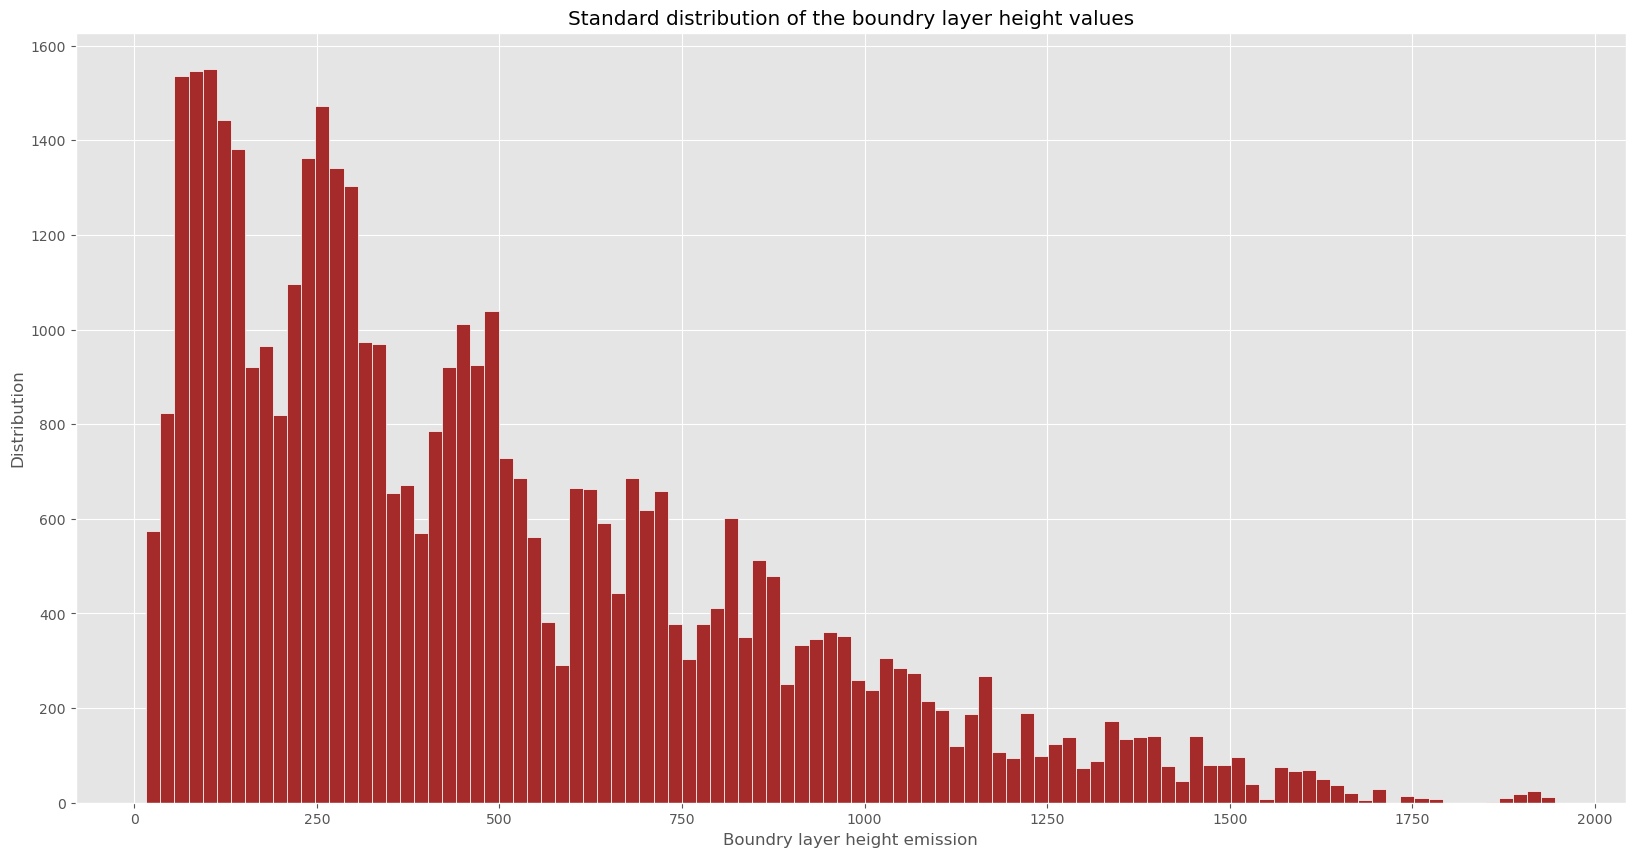

In [110]:
plt.figure(figsize=(20,10))
plt.hist(df_merged['blh'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the boundry layer height values")
plt.xlabel("Boundry layer height emission")
plt.ylabel("Distribution")
plt.show()

In [111]:
most_blh = df_merged.loc[df_merged['blh'] == df_merged['blh'].max()]
df_merged.loc[(df_merged['date'] == most_blh['date'].values[0]) & (df_merged['time'] == most_blh['time'].values[0])]


PC4     pm2.5          wd        ws        ssrd          blh  \
110    5611  3.272562  183.096069  7.141683  353.987778  1922.195190   
1430   5612  2.738851  183.073959  7.147581  353.572187  1914.542969   
2750   5613  3.002280  183.206161  7.144962  353.786319  1918.931885   
4070   5614  3.229659  183.176788  7.139929  354.145590  1925.303467   
5390   5615  3.180078  183.063019  7.137136  354.285312  1927.538940   
6710   5616  2.955970  182.939346  7.139519  354.098750  1923.656128   
8030   5617  2.604365  182.931854  7.142722  353.893264  1919.807861   
9350   5621  2.079525  182.902328  7.149207  353.482604  1912.028564   
10670  5622  2.239353  182.950867  7.152236  353.275937  1908.467407   
11990  5623  2.525014  183.061462  7.154053  353.124653  1906.317261   
13310  5624  1.990620  182.857529  7.158432  352.908715  1901.097290   
14630  5625  2.238213  183.032501  7.159682  352.745972  1899.232666   
15950  5626  1.769490  182.664139  7.160588  352.881493  1899.252563   
17270  5627  1.942845  182.719940  7.167979  352.388264  1890.423828   
18590  5628  2.112852  183.002945  7.163990  352.464410  1893.894653   
19910  5629  2.031381  182.955658  7.169833  352.097778  1886.837524   
21230  5631  2.145684  183.271942  7.154833  353.033125  1905.787598   
22550  5632  2.127146  183.213776  7.162182  352.480208  1895.602295   
23870  5633  1.816289  183.232162  7.169689  351.900000  1885.351318   
25190  5641  2.417993  183.432068  7.151211  353.374097  1912.411377   
26510  5642  2.867550  183.346649  7.147501  353.651840  1916.981079   
27830  5643  2.977880  183.253281  7.139899  354.200625  1926.454834   
29150  5644  2.586317  183.122726  7.129553  354.848646  1937.937744   
30470  5645  2.644020  183.348038  7.143139  354.022014  1923.464844   
31790  5646  2.420724  183.282654  7.136197  354.537535  1932.415527   
33110  5651  1.645850  182.620544  7.152693  353.374687  1908.276978   
34430  5652  2.394498  182.793060  7.134971  354.363160  1928.025024   
35750  5653  2.733269  182.861786  7.127544  354.807917  1936.725342   
37070  5654  2.881018  182.964035  7.128662  354.786354  1936.569336   
38390  5655  2.554878  182.848984  7.119458  355.276354  1945.580444   
39710  5656  2.577635  182.950745  7.121139  355.239792  1945.051025   
41030  5657  1.307150  182.372650  7.143480  353.969375  1918.240967   
42350  5658  1.494472  182.567108  7.134244  354.415521  1927.983032   

       people_number        date      time  wd_group  
110           1623.0  2021-09-29  14:00:00         8  
1430          1038.0  2021-09-29  14:00:00         8  
2750           834.0  2021-09-29  14:00:00         8  
4070           530.0  2021-09-29  14:00:00         8  
5390          1011.0  2021-09-29  14:00:00         8  
6710           816.0  2021-09-29  14:00:00         8  
8030           652.0  2021-09-29  14:00:00         8  
9350           632.0  2021-09-29  14:00:00         8  
10670          447.0  2021-09-29  14:00:00         8  
11990         1123.0  2021-09-29  14:00:00         8  
13310          461.0  2021-09-29  14:00:00         8  
14630          969.0  2021-09-29  14:00:00         8  
15950         1286.0  2021-09-29  14:00:00         8  
17270          757.0  2021-09-29  14:00:00         8  
18590          640.0  2021-09-29  14:00:00         8  
19910          620.0  2021-09-29  14:00:00         8  
21230          795.0  2021-09-29  14:00:00         8  
22550          877.0  2021-09-29  14:00:00         8  
23870          682.0  2021-09-29  14:00:00         8  
25190          444.0  2021-09-29  14:00:00         8  
26510          422.0  2021-09-29  14:00:00         8  
27830          448.0  2021-09-29  14:00:00         8  
29150         1059.0  2021-09-29  14:00:00         8  
30470          366.0  2021-09-29  14:00:00         8  
31790          961.0  2021-09-29  14:00:00         8  
33110         1448.0  2021-09-29  14:00:00         8  
34430         1427.0  2021-09-29  14:00:00         8  
35750          707.

The boundry layer height was relatively consistent for all postal codes on 2021-09-29.

<h4><font color=mediumvioletred>Testing for people number outliers</font></h4>

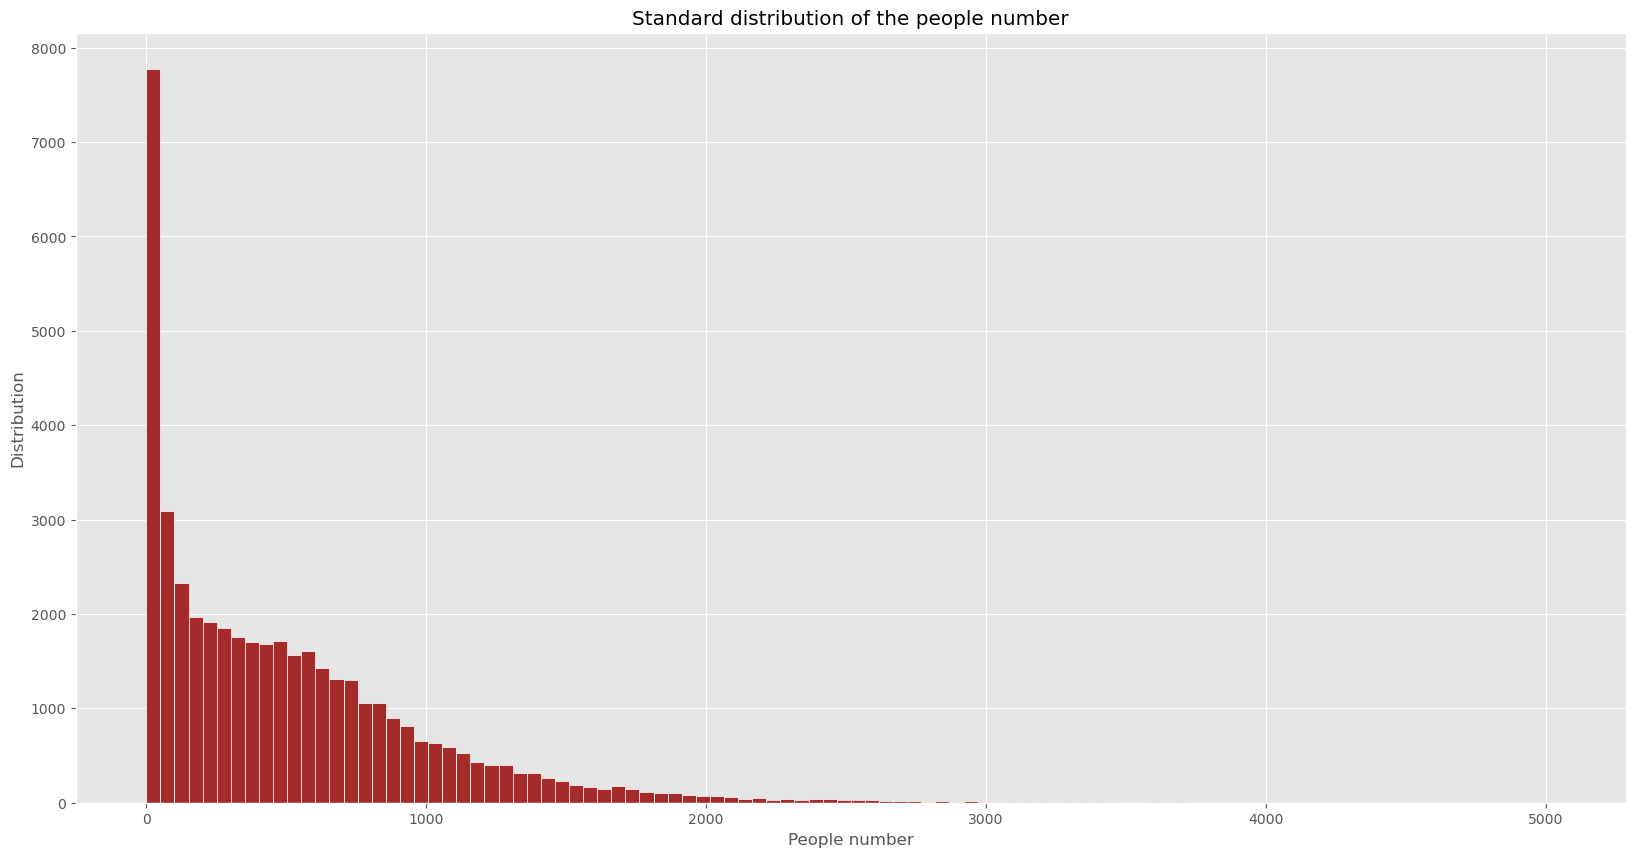

In [112]:

plt.figure(figsize=(20,10))
plt.hist(df_merged['people_number'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the people number")
plt.xlabel("People number")
plt.ylabel("Distribution")
plt.show()

<h4><font color=mediumvioletred>
Highest number of people present</font></h4>

In [113]:
most_populated = df_merged.loc[df_merged['people_number'] == df_merged['people_number'].max()]
ppl_nmbr_time = most_populated[["PC4", "people_number", "time"]]
print(ppl_nmbr_time)

        PC4  people_number      time
40424  5656         5035.0  08:00:00


The post code of high tech campus is 5656. Eight o'clock is the time most people come to work. It is therefore highly possible that the number is valid. 

<h4><font color=mediumvioletred>Accumulated PM2.5 per postal code in relation to people number</font></h4>

In [114]:
df_merged.loc[(df_merged['date'] == most_populated['date'].values[0]) & (df_merged['time'] == most_populated['time'].values[0])]


PC4      pm2.5          wd        ws       ssrd         blh  \
824    5611  11.064751  282.027649  5.629035  81.376771  566.160278   
2144   5612  11.060677  282.188416  5.646384  81.422517  565.718567   
3464   5613  10.267747  282.208405  5.616262  81.334748  565.323608   
4784   5614  10.105379  282.026917  5.608946  81.314427  565.950623   
6104   5615  10.598294  281.871704  5.625823  81.374714  566.731750   
7424   5616  11.053392  281.848145  5.653189  81.452812  567.117065   
8744   5617  11.405639  281.929321  5.660122  81.465642  566.875305   
10064  5621  11.548038  282.078491  5.676155  81.495703  566.464600   
11384  5622  11.607484  282.208160  5.674672  81.489297  565.940247   
12704  5623  11.489036  282.369415  5.662786  81.463108  565.182861   
14024  5624  11.569731  282.281586  5.698641  81.534705  565.905762   
15344  5625  11.510772  282.505432  5.679187  81.501345  564.820190   
16664  5626  11.163199  282.122131  5.725251  81.574957  566.819275   
17984  5627  11.361835  282.377228  5.730914  81.580755  565.869629   
19304  5628  11.322168  282.598816  5.692289  81.529957  564.588928   
20624  5629  11.303440  282.711029  5.709975  81.564418  564.327881   
21944  5631  10.047388  282.594025  5.633616  81.395417  564.002441   
23264  5632   9.993634  282.781189  5.663231  81.482031  563.570679   
24584  5633   9.745142  283.046478  5.682388  81.545252  562.718811   
25904  5641   9.928299  282.583588  5.592153  81.264045  563.618835   
27224  5642   9.783116  282.387085  5.595766  81.268941  564.417725   
28544  5643   9.711041  282.066101  5.592021  81.255530  565.619812   
29864  5644   9.900507  281.675232  5.596151  81.288325  567.170959   
31184  5645   9.381545  282.223999  5.580069  81.210868  564.885498   
32504  5646   9.284967  281.940125  5.572292  81.183177  565.897217   
33824  5651  11.084899  281.878937  5.719516  81.578203  567.716980   
35144  5652  11.112785  281.613708  5.671561  81.518151  568.229980   
36464  5653  10.601645  281.483215  5.649682  81.480443  568.496277   
37784  5654  10.188508  281.575104  5.630587  81.413672  567.931213   
39104  5655  10.489968  281.274536  5.641751  81.486623  569.215820   
40424  5656   9.998837  281.370453  5.621941  81.411328  568.626038   
41744  5657  10.468638  281.423157  5.744548  81.665399  569.788940   
43064  5658  10.906529  281.403625  5.707514  81.617049  569.449768   

       people_number        date      time  wd_group  
824            637.0  2021-10-29  08:00:00        13  
2144          1300.0  2021-10-29  08:00:00        13  
3464           655.0  2021-10-29  08:00:00        13  
4784           846.0  2021-10-29  08:00:00        13  
6104           977.0  2021-10-29  08:00:00        13  
7424           759.0  2021-10-29  08:00:00        13  
8744           450.0  2021-10-29  08:00:00        13  
10064          552.0  2021-10-29  08:00:00        13  
11384          426.0  2021-10-29  08:00:00        13  
12704         1318.0  2021-10-29  08:00:00        13  
14024          293.0  2021-10-29  08:00:00        13  
15344         1011.0  2021-10-29  08:00:00        13  
16664         1732.0  2021-10-29  08:00:00        13  
17984         1215.0  2021-10-29  08:00:00        13  
19304          820.0  2021-10-29  08:00:00        13  
20624         1206.0  2021-10-29  08:00:00        13  
21944         1155.0  2021-10-29  08:00:00        13  
23264          836.0  2021-10-29  08:00:00        13  
24584         1182.0  2021-10-29  08:00:00        13  
25904          489.0  2021-10-29  08:00:00        13  
27224          328.0  2021-10-29  08:00:00        13  
28544          641.0  2021-10-29  08:00:00        13  
29864         3472.0  2021-10-29  08:00:00        13  
31184          271.0  2021-10-29  08:00:00        13  
32504         2010.0  2021-10-29  08:00:00        13  
33824         3036.0  2021-10-29  08:00:00        13  
35144         2537.0  2021-10-29  08:00:00        13  
36464         1079.0  2021-10-29  08:00:00        13 

It seems that the amount of people doesn't have much impact on the accumulated pm2.5 pollution per postcode.

<h4><font color=mediumvioletred>Testing for solar surface radiation outliers</font></h4>

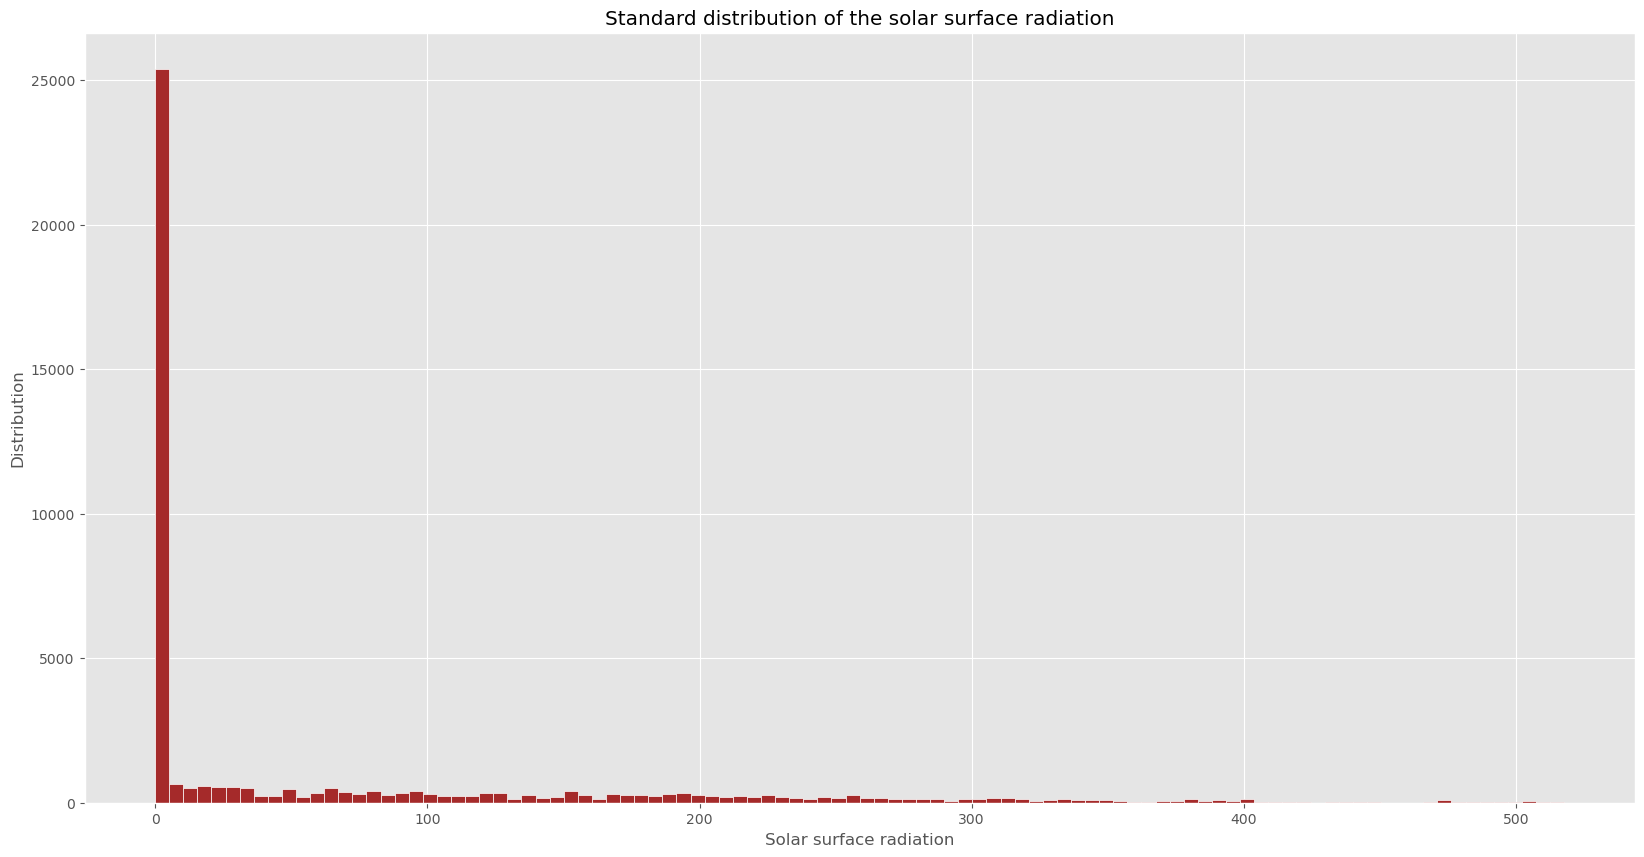

In [115]:
plt.figure(figsize=(20,10))
plt.hist(df_merged['ssrd'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the solar surface radiation")
plt.xlabel("Solar surface radiation")
plt.ylabel("Distribution")
plt.show()

There are a lot of numbers around zero. This is correct, because there is not sunshine at night. 

<h4><font color=mediumvioletred>Comparing measured solar surface radiation between postal codes</font></h4>

In [116]:
most_ssrd = df_merged.loc[df_merged['ssrd'] == df_merged['ssrd'].max()]
df_merged.loc[(df_merged['date'] == most_ssrd['date'].values[0]) & (df_merged['time'] == most_ssrd['time'].values[0])]


PC4     pm2.5          wd        ws        ssrd          blh  \
227    5611  3.560916  250.697815  5.981396  517.068993  1502.757935   
1547   5612  3.729334  250.789261  5.993948  516.968368  1504.867676   
2867   5613  3.024144  250.702240  5.971666  517.261771  1501.029663   
4187   5614  2.882185  250.636978  5.966671  517.257083  1500.244019   
5507   5615  3.045282  250.649948  5.979172  517.039549  1502.408203   
6827   5616  4.275577  250.727707  5.999463  516.769340  1505.914673   
8147   5617  4.756093  250.769272  6.004611  516.732847  1506.799316   
9467   5621  4.862335  250.855759  6.016564  516.633576  1508.865112   
10787  5622  4.541759  250.882217  6.015214  516.700486  1508.584351   
12107  5623  4.071315  250.882797  6.005798  516.884688  1506.855591   
13427  5624  4.075772  250.975662  6.033390  516.491562  1511.783936   
14747  5625  3.846159  250.965805  6.017799  516.781875  1508.896851   
16067  5626  3.216246  251.023514  6.054425  516.153333  1515.638916   
17387  5627  3.186317  251.102478  6.058269  516.201632  1516.228394   
18707  5628  3.573124  251.028717  6.027470  516.692604  1510.556885   
20027  5629  3.298301  251.110809  6.040662  516.564861  1512.843262   
21347  5631  2.519661  250.843674  5.983162  517.263576  1502.786987   
22667  5632  2.512386  250.977341  6.004468  517.063646  1506.354858   
23987  5633  2.194209  251.095520  6.017557  517.000972  1508.437256   
25307  5641  1.830356  250.715820  5.952850  517.645208  1497.633545   
26627  5642  2.256850  250.682190  5.956228  517.526389  1498.326538   
27947  5643  2.394568  250.595840  5.954335  517.428715  1498.149536   
29267  5644  2.046469  250.512436  5.957654  517.242292  1498.784668   
30587  5645  1.705106  250.597778  5.945387  517.601354  1496.589478   
31907  5646  1.633063  250.507904  5.940455  517.556979  1495.881836   
33227  5651  3.174827  250.945267  6.050178  516.116979  1514.928345   
34547  5652  3.977029  250.725296  6.013152  516.505590  1508.313232   
35867  5653  3.231433  250.623596  5.996526  516.674861  1505.386353   
37187  5654  2.835097  250.589569  5.982584  516.887569  1503.001099   
38507  5655  2.571140  250.544510  5.990218  516.682396  1504.248657   
39827  5656  2.171329  250.510391  5.975932  516.900208  1501.831909   
41147  5657  2.155160  250.907776  6.069044  515.699826  1518.303467   
42467  5658  2.958431  250.783554  6.040179  516.075347  1513.076660   

       people_number        date      time  wd_group  
227           1223.0  2021-10-04  11:00:00        11  
1547           981.0  2021-10-04  11:00:00        11  
2867          1013.0  2021-10-04  11:00:00        11  
4187           784.0  2021-10-04  11:00:00        11  
5507           768.0  2021-10-04  11:00:00        11  
6827           611.0  2021-10-04  11:00:00        11  
8147           493.0  2021-10-04  11:00:00        11  
9467           775.0  2021-10-04  11:00:00        11  
10787          534.0  2021-10-04  11:00:00        11  
12107          856.0  2021-10-04  11:00:00        11  
13427          177.0  2021-10-04  11:00:00        11  
14747          912.0  2021-10-04  11:00:00        11  
16067         1413.0  2021-10-04  11:00:00        11  
17387          767.0  2021-10-04  11:00:00        11  
18707          444.0  2021-10-04  11:00:00        11  
20027          693.0  2021-10-04  11:00:00        11  
21347          598.0  2021-10-04  11:00:00        11  
22667          840.0  2021-10-04  11:00:00        11  
23987          783.0  2021-10-04  11:00:00        11  
25307          595.0  2021-10-04  11:00:00        11  
26627          715.0  2021-10-04  11:00:00        11  
27947          553.0  2021-10-04  11:00:00        11  
29267          819.0  2021-10-04  11:00:00        11  
30587          369.0  2021-10-04  11:00:00        11  
31907         1028.0  2021-10-04  11:00:00        11  
33227         1668.0  2021-10-04  11:00:00        11  
34547         1442.0  2021-10-04  11:00:00        11  
35867         1085.

The high solar surface radiation corresponds to a sunny day, which explains the high value. Furthermore, there was little to no difference in solar surface radiation between different postal codes.

<h4><font color=mediumvioletred>Testing for PM2.5 emission outliers</font></h4>

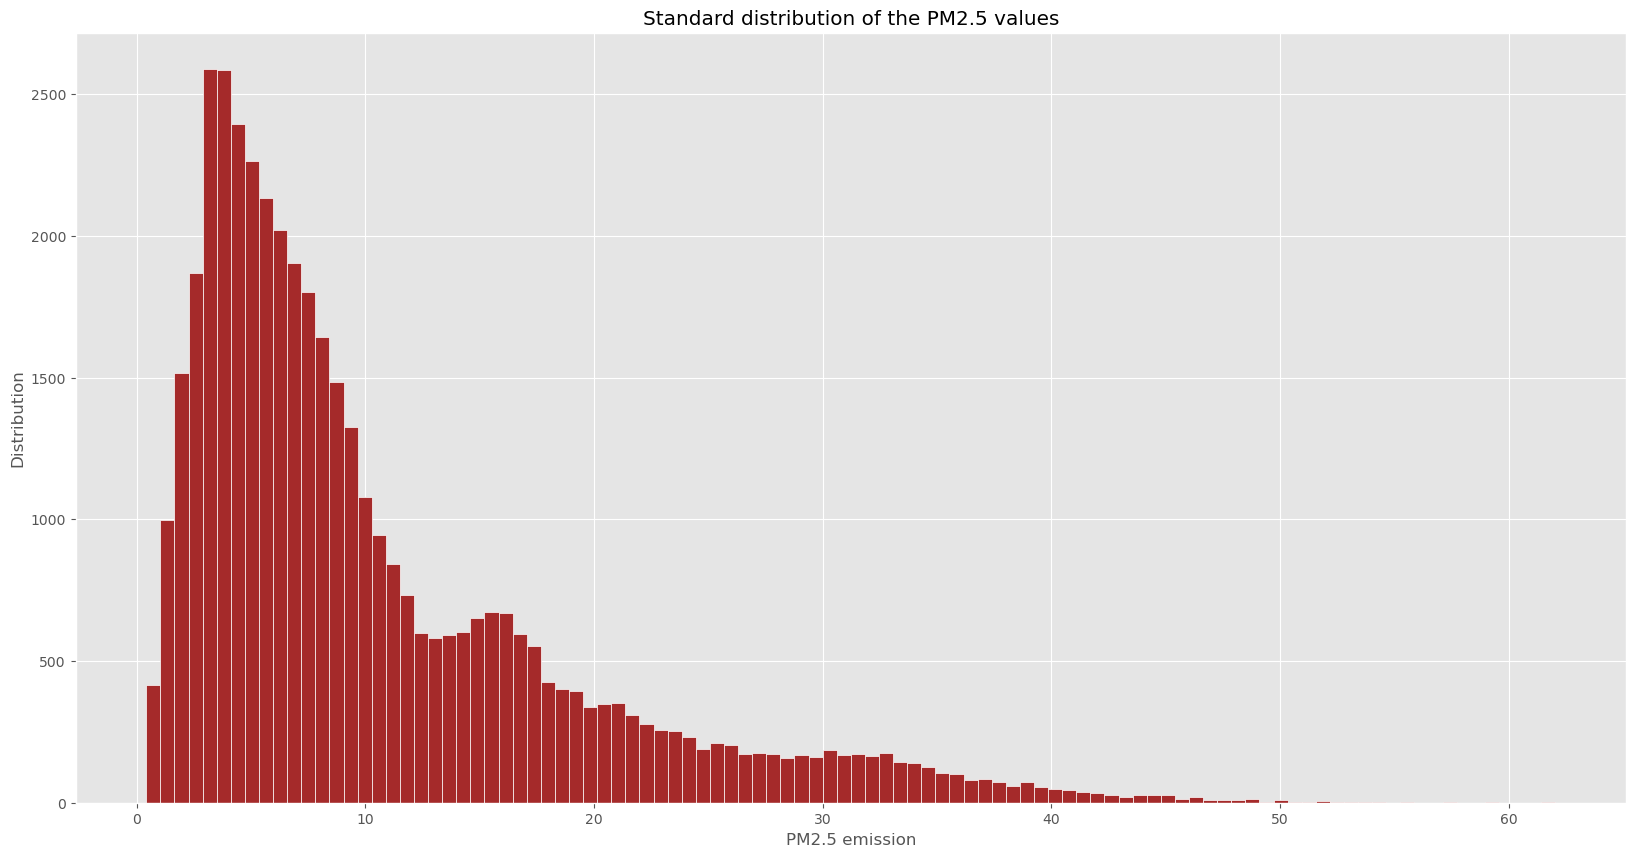

In [117]:
most_pm = df_merged.loc[df_merged['pm2.5'] == df_merged['pm2.5'].max()]

plt.figure(figsize=(20,10))
plt.hist(df_merged['pm2.5'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.ylabel("Distribution")
plt.show()

<h4><font color=mediumvioletred>
Comparing maximum PM2.5 emissions between different postal codes</font></h4>

In [118]:
most_pm2_5 = df_merged.loc[df_merged['pm2.5'] == df_merged['pm2.5'].max()]
df_merged.loc[(df_merged['date'] == most_pm2_5['date'].values[0]) & (df_merged['time'] == most_pm2_5['time'].values[0])]

PC4      pm2.5         wd        ws        ssrd         blh  \
321    5611  40.209557  23.281149  1.534867  201.783455  151.983780   
1641   5612  36.347561  22.937794  1.537891  201.558368  151.801910   
2961   5613  39.580055  23.423393  1.531258  201.736406  151.952728   
4281   5614  43.082806  23.607363  1.530470  201.930955  152.091400   
5601   5615  43.580147  23.395134  1.534942  201.901545  152.087738   
6921   5616  44.328453  22.955906  1.540974  201.752865  151.954239   
8241   5617  46.249634  22.807446  1.542036  201.673611  151.871246   
9561   5621  36.676926  22.480095  1.544699  201.520347  151.700714   
10881  5622  31.959091  22.457138  1.543803  201.429618  151.636765   
12201  5623  30.956799  22.601851  1.540622  201.331997  151.613159   
13521  5624  35.633698  22.023081  1.548482  201.322934  151.463974   
14841  5625  34.318417  22.281336  1.543548  201.153281  151.448685   
16161  5626  46.352295  21.619768  1.554614  201.455521  151.404465   
17481  5627  57.154690  21.430172  1.554691  201.249462  151.230637   
18801  5628  47.716076  22.029623  1.545941  201.031875  151.325317   
20121  5629  59.040752  21.692320  1.549211  200.897656  151.165497   
21441  5631  31.580202  23.017853  1.533534  201.253802  151.650482   
22761  5632  43.907173  22.472622  1.539246  200.899844  151.387924   
24081  5633  62.038277  22.082558  1.542498  200.513993  151.140259   
25401  5641  42.748943  23.694799  1.524463  201.580920  151.879089   
26721  5642  41.172634  23.695122  1.525993  201.747465  151.965118   
28041  5643  42.841084  23.864407  1.526534  202.050660  152.159424   
29361  5644  48.439499  23.953474  1.529428  202.254479  152.354034   
30681  5645  41.299385  23.999229  1.523154  202.041146  152.136505   
32001  5646  46.490974  24.221943  1.522663  202.349705  152.331757   
33321  5651  38.765270  21.816805  1.554614  201.608837  151.573700   
34641  5652  45.568459  22.753803  1.546170  201.778264  151.988022   
35961  5653  41.632961  23.179623  1.542320  201.908715  152.180496   
37281  5654  44.097618  23.446775  1.537621  202.004392  152.229385   
38601  5655  40.540318  23.412252  1.541934  201.999844  152.342545   
39921  5656  47.371132  23.683813  1.536986  202.125660  152.391693   
41241  5657  37.708042  21.600395  1.562336  201.770590  151.699158   
42561  5658  40.948971  22.248877  1.554928  201.752535  151.914124   

       people_number        date      time  wd_group  
321           1251.0  2021-10-08  09:00:00         1  
1641          1195.0  2021-10-08  09:00:00         1  
2961          1173.0  2021-10-08  09:00:00         1  
4281          1082.0  2021-10-08  09:00:00         1  
5601           719.0  2021-10-08  09:00:00         1  
6921           710.0  2021-10-08  09:00:00         1  
8241           617.0  2021-10-08  09:00:00         1  
9561           709.0  2021-10-08  09:00:00         1  
10881          471.0  2021-10-08  09:00:00         1  
12201         1377.0  2021-10-08  09:00:00         1  
13521          257.0  2021-10-08  09:00:00         1  
14841         1234.0  2021-10-08  09:00:00         1  
16161         1711.0  2021-10-08  09:00:00         1  
17481          797.0  2021-10-08  09:00:00         1  
18801          784.0  2021-10-08  09:00:00         1  
20121          801.0  2021-10-08  09:00:00         1  
21441          988.0  2021-10-08  09:00:00         1  
22761          905.0  2021-10-08  09:00:00         1  
24081         1070.0  2021-10-08  09:00:00         1  
25401          569.0  2021-10-08  09:00:00         1  
26721          577.0  2021-10-08  09:00:00         1  
28041          412.0  2021-10-08  09:00:00         1  
29361         1239.0  2021-10-08  09:00:00         1  
30681          131.0  2021-10-08  09:00:00         1  
32001          927.0  2021-10-08  09:00:00         1  
33321         2187.0  2021-10-08  09:00:00         1  
34641         1412.0  2021-10-08  09:00:00         1  
35961          793.0  2021-10-08  09:00:00         1 

The maximum PM2.5 for all postal codes for 2021-10-08 were all relatively high compared to the legal limit.

<h4><font color=mediumvioletred>Testing for wind speed outliers</font></h4>

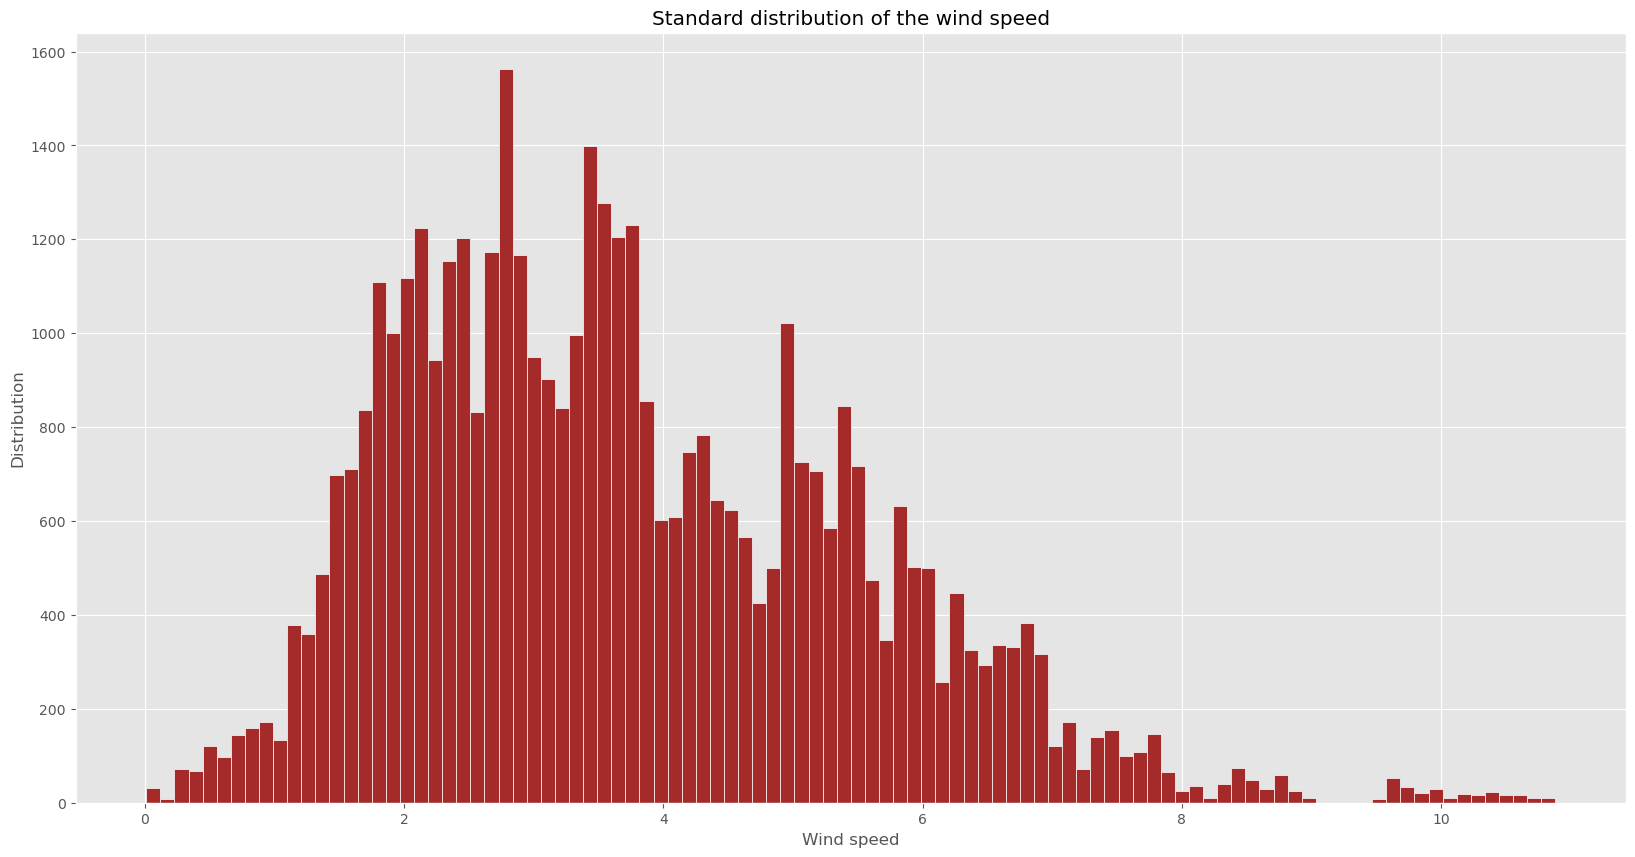

In [119]:
most_pm = df_merged.loc[df_merged['ws'] == df_merged['ws'].max()]

plt.figure(figsize=(20,10))
plt.hist(df_merged['ws'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the wind speed")
plt.xlabel("Wind speed")
plt.ylabel("Distribution")
plt.show()

<h4><font color=mediumvioletred>
Comparing maximum wind speed between different postal codes</font></h4>

In [120]:
most_ws = df_merged.loc[df_merged['ws'] == df_merged['ws'].max()]
df_merged.loc[(df_merged['date'] == most_ws['date'].values[0]) & (df_merged['time'] == most_ws['time'].values[0])]

PC4     pm2.5          wd         ws  ssrd          blh  \
628    5611  0.825657  240.062286  10.664748   0.0  1377.905273   
1948   5612  0.919883  239.976196  10.709381   0.0  1380.261963   
3268   5613  0.745730  240.191315  10.652555   0.0  1380.912964   
4588   5614  0.659098  240.200989  10.625680   0.0  1378.111694   
5908   5615  0.721870  240.052673  10.647873   0.0  1375.474976   
7228   5616  0.934558  239.855240  10.698986   0.0  1374.771240   
8548   5617  0.947204  239.821655  10.717788   0.0  1375.970215   
9868   5621  0.815432  239.736374  10.758528   0.0  1378.134644   
11188  5622  0.816137  239.776215  10.764726   0.0  1380.230713   
12508  5623  0.912744  239.901215  10.753502   0.0  1382.967773   
13828  5624  0.653800  239.615723  10.815088   0.0  1381.091919   
15148  5625  0.733837  239.815582  10.794330   0.0  1384.958862   
16468  5626  0.612788  239.376465  10.853476   0.0  1378.128540   
17788  5627  0.658604  239.393204  10.881980   0.0  1382.177490   
19108  5628  0.679482  239.743057  10.825777   0.0  1386.305542   
20428  5629  0.669624  239.640686  10.867061   0.0  1387.905518   
21748  5631  0.825115  240.167084  10.713627   0.0  1386.898315   
23068  5632  0.789934  240.007095  10.784048   0.0  1389.614136   
24388  5633  0.662445  239.944794  10.839969   0.0  1393.724243   
25708  5641  0.665450  240.449814  10.632115   0.0  1387.117188   
27028  5642  0.688328  240.374390  10.625125   0.0  1383.951904   
28348  5643  0.666211  240.324478  10.595244   0.0  1378.903809   
29668  5644  0.629131  240.217621  10.576631   0.0  1372.719238   
30988  5645  0.635192  240.440445  10.582725   0.0  1381.507568   
32308  5646  0.640557  240.427551  10.547498   0.0  1377.102905   
33628  5651  0.605337  239.369308  10.826040   0.0  1374.306152   
34948  5652  0.799403  239.680511  10.718343   0.0  1370.821533   
36268  5653  0.758042  239.817520  10.668054   0.0  1369.077148   
37588  5654  0.693030  239.965714  10.637226   0.0  1370.759277   
38908  5655  0.641272  239.842621  10.639260   0.0  1365.927612   
40228  5656  0.615536  239.993439  10.607063   0.0  1367.675415   
41548  5657  0.547610  239.101822  10.842334   0.0  1366.639893   
42868  5658  0.588348  239.381760  10.772365   0.0  1366.961426   

       people_number        date      time  wd_group  
628            441.0  2021-10-21  04:00:00        11  
1948           445.0  2021-10-21  04:00:00        11  
3268           426.0  2021-10-21  04:00:00        11  
4588           253.0  2021-10-21  04:00:00        11  
5908           113.0  2021-10-21  04:00:00        11  
7228           191.0  2021-10-21  04:00:00        11  
8548           172.0  2021-10-21  04:00:00        11  
9868           192.0  2021-10-21  04:00:00        11  
11188          102.0  2021-10-21  04:00:00        11  
12508          352.0  2021-10-21  04:00:00        11  
13828           74.0  2021-10-21  04:00:00        11  
15148          274.0  2021-10-21  04:00:00        11  
16468          661.0  2021-10-21  04:00:00        11  
17788          329.0  2021-10-21  04:00:00        11  
19108          176.0  2021-10-21  04:00:00        11  
20428          348.0  2021-10-21  04:00:00        11  
21748          536.0  2021-10-21  04:00:00        11  
23068          347.0  2021-10-21  04:00:00        11  
24388          337.0  2021-10-21  04:00:00        11  
25708          216.0  2021-10-21  04:00:00        11  
27028          118.0  2021-10-21  04:00:00        11  
28348          211.0  2021-10-21  04:00:00        11  
29668          505.0  2021-10-21  04:00:00        11  
30988          123.0  2021-10-21  04:00:00        11  
32308          246.0  2021-10-21  04:00:00        11  
33628          653.0  2021-10-21  04:00:00        11  
34948          444.0  2021-10-21  04:00:00        11  
36268          302.0  2021-10-21  04:00:00        11  
37588          155.0  2021-10-21  04:00:00        11  
38908          301.0  2021-10-21  04:00:00        11  
40228          668.0  20

The wind speed for 2021-10-21 was consistent among all postal codes. Furthermore, the wind direction was the same for all postal codes.

<h4><font color=mediumvioletred>Conclusion</font></h4>
There were no null values found by the project group. Furthermore, there were outliers, but they were consistent among all postal codes. The project group has therefore not made any changes to the values within the dataset.

<h4><font color=mediumvioletred>Export prepared dataframe to CSV</font></h4>

In [121]:
# Export prepared dataframe
df_grouped_numerical.to_csv("data/df_prepared.csv", index=False)

<h2><font color=slateblue> 6. Modelling </font></h2>

Link to [Scikit-learn Modelling](scikit_learn_modelling.ipynb)

Link to [AutoSkLearn Modelling](autosklearn_notebook.ipynb)